In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import requests
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

In [2]:
crypto = pd.read_csv("crypto_hourly.csv")
crypto.head()

Assets                 Date     open     high      low    close  \
0  BTCUSDT  2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02   
1  BTCUSDT  2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27   
2  BTCUSDT  2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85   
3  BTCUSDT  2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01   
4  BTCUSDT  2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27   

       volume               close_time  quote_asset_volume  number_of_trades  \
0  511.814901  2020-01-01 00:59:59.999        3.675857e+06              7640   
1  883.052603  2020-01-01 01:59:59.999        6.365953e+06              9033   
2  655.156809  2020-01-01 02:59:59.999        4.736719e+06              7466   
3  783.724867  2020-01-01 03:59:59.999        5.667367e+06              8337   
4  467.812578  2020-01-01 04:59:59.999        3.379094e+06              5896   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                   226.153126                  1.624289e+06       0  
1                   570.721419                  4.114804e+06       0  
2                   357.180263                  2.582514e+06       0  
3                   394.810811                  2.854987e+06       0  
4                   243.514706                  1.759053e+06       0

In [3]:
crypto_prices =\
(
    crypto
    .reset_index()
    .pivot(index = "Date",
           columns = "Assets",
           values = "close")
)

crypto_prices.index = pd.to_datetime(crypto_prices.index)
crypto_prices.head()

Assets               ADAUSDT  BCHUSDT  BNBUSDT  BTCUSDT  EOSUSDT  ETHUSDT  \
Date                                                                        
2020-01-01 00:00:00  0.03278   204.43  13.6981  7177.02   2.5882   128.87   
2020-01-01 01:00:00  0.03299   206.19  13.7995  7216.27   2.6161   130.64   
2020-01-01 02:00:00  0.03317   207.38  13.8478  7242.85   2.6223   130.85   
2020-01-01 03:00:00  0.03303   205.71  13.8170  7225.01   2.6085   130.20   
2020-01-01 04:00:00  0.03299   206.20  13.7922  7217.27   2.6165   130.20   

Assets               LINKUSDT  LTCUSDT  NOTUSDT  SOLUSDT  XLMUSDT  XRPUSDT  \
Date                                                                         
2020-01-01 00:00:00    1.7638    41.28      NaN      NaN  0.04488  0.19248   
2020-01-01 01:00:00    1.7831    41.62      NaN      NaN  0.04517  0.19371   
2020-01-01 02:00:00    1.8004    41.85      NaN      NaN  0.04523  0.19418   
2020-01-01 03:00:00    1.7932    41.53      NaN      NaN  0.04517  0.19397   
2020-01-01 04:00:00    1.7968    41.59      NaN      NaN  0.04511  0.19363   

Assets               YGGUSDT  
Date                          
2020-01-01 00:00:00      NaN  
2020-01-01 01:00:00      NaN  
2020-01-01 02:00:00      NaN  
2020-01-01 03:00:00      NaN  
2020-01-01 04:00:00      NaN

### 1. Drop nan data

In [4]:
missing_values_per_column = crypto_prices.isna().sum()

missing_values_per_column

Assets
ADAUSDT         0
BCHUSDT         0
BNBUSDT         0
BTCUSDT         0
EOSUSDT         0
ETHUSDT         0
LINKUSDT        0
LTCUSDT         0
NOTUSDT     38308
SOLUSDT      5346
XLMUSDT         0
XRPUSDT         0
YGGUSDT     15145
dtype: int64

In [5]:
missing_values_per_column = crypto_prices.isna().sum()

columns_without_missing_values = missing_values_per_column[missing_values_per_column == 0].index

crypto_prices_cleaned = crypto_prices[columns_without_missing_values]

crypto_prices_cleaned

Assets               ADAUSDT  BCHUSDT   BNBUSDT   BTCUSDT  EOSUSDT  ETHUSDT  \
Date                                                                          
2020-01-01 00:00:00  0.03278   204.43   13.6981   7177.02   2.5882   128.87   
2020-01-01 01:00:00  0.03299   206.19   13.7995   7216.27   2.6161   130.64   
2020-01-01 02:00:00  0.03317   207.38   13.8478   7242.85   2.6223   130.85   
2020-01-01 03:00:00  0.03303   205.71   13.8170   7225.01   2.6085   130.20   
2020-01-01 04:00:00  0.03299   206.20   13.7922   7217.27   2.6165   130.20   
...                      ...      ...       ...       ...      ...      ...   
2024-05-30 20:00:00  0.44740   467.30  594.0000  68475.99   0.8130  3737.69   
2024-05-30 21:00:00  0.44800   467.70  595.3000  68416.76   0.8112  3751.36   
2024-05-30 22:00:00  0.44790   466.50  595.0000  68314.93   0.8118  3747.44   
2024-05-30 23:00:00  0.44650   465.10  595.1000  68352.17   0.8092  3747.91   
2024-05-31 00:00:00  0.44620   464.60  595.5000  68460.00   0.8051  3752.74   

Assets               LINKUSDT  LTCUSDT  XLMUSDT  XRPUSDT  
Date                                                      
2020-01-01 00:00:00    1.7638    41.28  0.04488  0.19248  
2020-01-01 01:00:00    1.7831    41.62  0.04517  0.19371  
2020-01-01 02:00:00    1.8004    41.85  0.04523  0.19418  
2020-01-01 03:00:00    1.7932    41.53  0.04517  0.19397  
2020-01-01 04:00:00    1.7968    41.59  0.04511  0.19363  
...                       ...      ...      ...      ...  
2024-05-30 20:00:00   17.9090    84.01  0.10670  0.51880  
2024-05-30 21:00:00   17.8310    84.55  0.10700  0.52020  
2024-05-30 22:00:00   17.9020    84.42  0.10690  0.51970  
2024-05-30 23:00:00   17.9440    84.42  0.10670  0.51860  
2024-05-31 00:00:00   17.9070    84.38  0.10670  0.51980  

[38657 rows x 10 columns]

In [6]:
norm_prices = crypto_prices_cleaned.divide(crypto_prices_cleaned.iloc[-1])
norm_prices

Assets                ADAUSDT   BCHUSDT   BNBUSDT   BTCUSDT   EOSUSDT  \
Date                                                                    
2020-01-01 00:00:00  0.073465  0.440013  0.023003  0.104835  3.214756   
2020-01-01 01:00:00  0.073935  0.443801  0.023173  0.105409  3.249410   
2020-01-01 02:00:00  0.074339  0.446362  0.023254  0.105797  3.257111   
2020-01-01 03:00:00  0.074025  0.442768  0.023202  0.105536  3.239970   
2020-01-01 04:00:00  0.073935  0.443823  0.023161  0.105423  3.249907   
...                       ...       ...       ...       ...       ...   
2024-05-30 20:00:00  1.002689  1.005811  0.997481  1.000234  1.009812   
2024-05-30 21:00:00  1.004034  1.006672  0.999664  0.999368  1.007577   
2024-05-30 22:00:00  1.003810  1.004090  0.999160  0.997881  1.008322   
2024-05-30 23:00:00  1.000672  1.001076  0.999328  0.998425  1.005093   
2024-05-31 00:00:00  1.000000  1.000000  1.000000  1.000000  1.000000   

Assets                ETHUSDT  LINKUSDT   LTCUSDT   XLMUSDT   XRPUSDT  
Date                                                                   
2020-01-01 00:00:00  0.034340  0.098498  0.489215  0.420619  0.370296  
2020-01-01 01:00:00  0.034812  0.099576  0.493245  0.423336  0.372663  
2020-01-01 02:00:00  0.034868  0.100542  0.495971  0.423899  0.373567  
2020-01-01 03:00:00  0.034695  0.100140  0.492178  0.423336  0.373163  
2020-01-01 04:00:00  0.034695  0.100341  0.492889  0.422774  0.372509  
...                       ...       ...       ...       ...       ...  
2024-05-30 20:00:00  0.995990  1.000112  0.995615  1.000000  0.998076  
2024-05-30 21:00:00  0.999632  0.995756  1.002015  1.002812  1.000770  
2024-05-30 22:00:00  0.998588  0.999721  1.000474  1.001874  0.999808  
2024-05-30 23:00:00  0.998713  1.002066  1.000474  1.000000  0.997691  
2024-05-31 00:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  

[38657 rows x 10 columns]

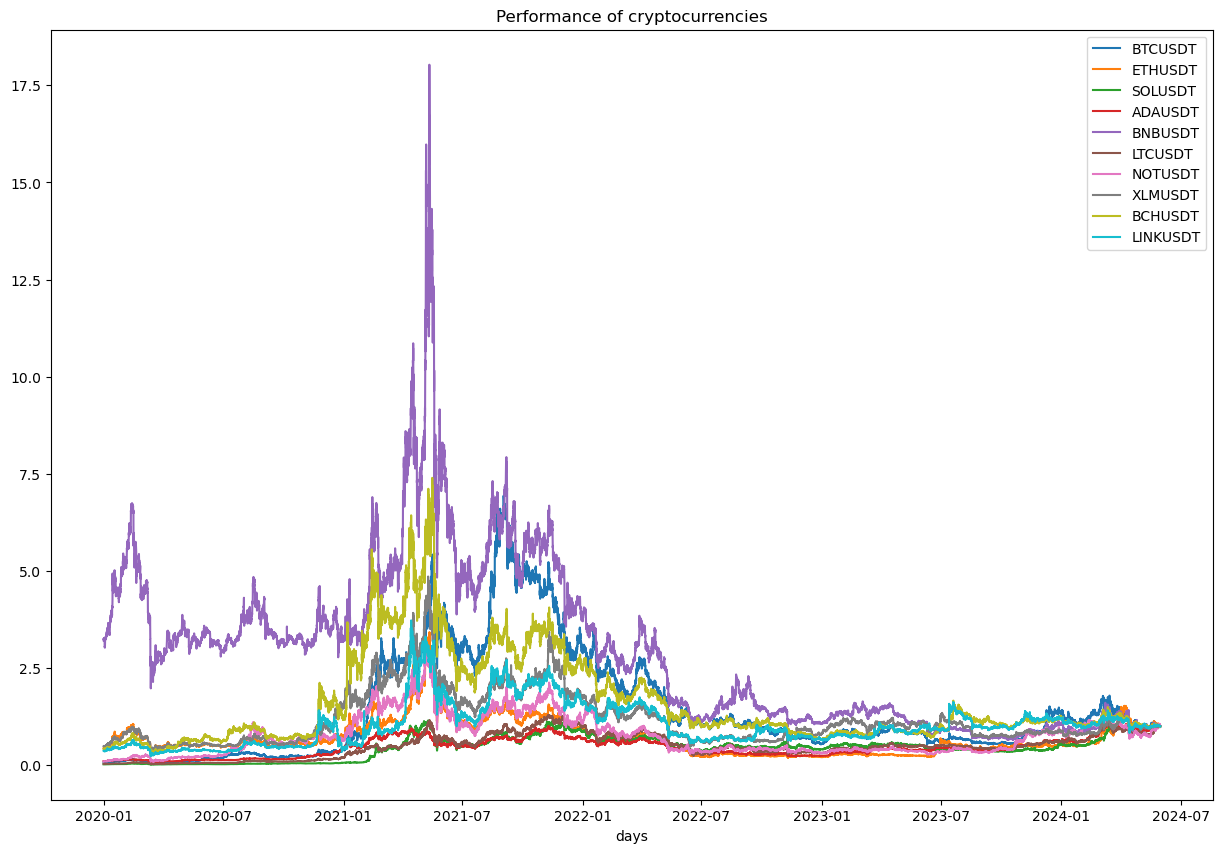

In [7]:
assets = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'ADAUSDT', 'BNBUSDT', 
          'LTCUSDT', 'NOTUSDT','XLMUSDT','BCHUSDT',
          'LINKUSDT','XRPUSDT','YGGUSDT','EOSUSDT']
plt.figure(figsize = (15, 10))
plt.plot(norm_prices)

plt.xlabel('days')
plt.title('Performance of cryptocurrencies')
plt.legend(assets)

plt.show()

In [8]:
import statsmodels.api as sm;
import statsmodels.tsa.stattools as ts

crypto_2021 = crypto_prices_cleaned.loc['2020-01-01':'2021-12-31']
crypto_2122 = crypto_prices_cleaned.loc['2021-01-01':'2022-12-31']
crypto_2223 = crypto_prices_cleaned.loc['2022-01-01':'2023-12-31']

### 2. Check cointegration ( Use tarining data)

In [9]:
def cointegration_test(dataframe, p_value_threshold=0.05):
    p_value = {}
    columns = dataframe.columns
    for a1 in columns:
        for a2 in columns:
            if a1 != a2:
                test_result = ts.coint(dataframe[a1], dataframe[a2])
                p_value[a1 + ' and ' + a2] = test_result[1]
                
    p_value_df = pd.DataFrame(list(p_value.items()), columns=['Pair', 'P-Value'])
    filtered_df = p_value_df[p_value_df["P-Value"] < p_value_threshold]
    
    return filtered_df

In [10]:
coin_crypto_2021 = cointegration_test(crypto_2021)
coin_crypto_2122 = cointegration_test(crypto_2122)
coin_crypto_2223 = cointegration_test(crypto_2223)

In [15]:
a = pd.concat([coin_crypto_2021,coin_crypto_2122,coin_crypto_2223],axis = 1)

In [16]:
print(a)

                    Pair   P-Value     Period                  Pair   P-Value  \
0    BCHUSDT and EOSUSDT  0.024216  2020-2021   BCHUSDT and EOSUSDT  0.000562   
1    BCHUSDT and XLMUSDT  0.031336  2020-2021   BCHUSDT and XLMUSDT  0.001403   
2    BCHUSDT and XRPUSDT  0.030084  2020-2021   EOSUSDT and BCHUSDT  0.000281   
3    EOSUSDT and BCHUSDT  0.005472  2020-2021  EOSUSDT and LINKUSDT  0.001349   
4   EOSUSDT and LINKUSDT  0.047426  2020-2021   EOSUSDT and LTCUSDT  0.005068   
5    EOSUSDT and LTCUSDT  0.044026  2020-2021   EOSUSDT and XLMUSDT  0.001951   
6    EOSUSDT and XLMUSDT  0.049787  2020-2021  LINKUSDT and LTCUSDT  0.000020   
7    EOSUSDT and XRPUSDT  0.028499  2020-2021  LINKUSDT and XLMUSDT  0.000009   
8   LINKUSDT and LTCUSDT  0.020414  2020-2021  LTCUSDT and LINKUSDT  0.000015   
9   LINKUSDT and XLMUSDT  0.000976  2020-2021   LTCUSDT and XLMUSDT  0.000026   
10  LTCUSDT and LINKUSDT  0.020920  2020-2021  XLMUSDT and LINKUSDT  0.000009   
11   LTCUSDT and XLMUSDT  0.

In [11]:
pd.concat([coin_crypto_2021,coin_crypto_2122,coin_crypto_2223],axis = 1)

Pair   P-Value                  Pair   P-Value  \
12   BCHUSDT and EOSUSDT  0.024216   BCHUSDT and EOSUSDT  0.000562   
16   BCHUSDT and XLMUSDT  0.031336   BCHUSDT and XLMUSDT  0.001403   
17   BCHUSDT and XRPUSDT  0.030084                   NaN       NaN   
37   EOSUSDT and BCHUSDT  0.005472   EOSUSDT and BCHUSDT  0.000281   
41  EOSUSDT and LINKUSDT  0.047426  EOSUSDT and LINKUSDT  0.001349   
42   EOSUSDT and LTCUSDT  0.044026   EOSUSDT and LTCUSDT  0.005068   
43   EOSUSDT and XLMUSDT  0.049787   EOSUSDT and XLMUSDT  0.001951   
44   EOSUSDT and XRPUSDT  0.028499                   NaN       NaN   
60  LINKUSDT and LTCUSDT  0.020414  LINKUSDT and LTCUSDT  0.000020   
61  LINKUSDT and XLMUSDT  0.000976  LINKUSDT and XLMUSDT  0.000009   
69  LTCUSDT and LINKUSDT  0.020920  LTCUSDT and LINKUSDT  0.000015   
70   LTCUSDT and XLMUSDT  0.000195   LTCUSDT and XLMUSDT  0.000026   
78  XLMUSDT and LINKUSDT  0.001279  XLMUSDT and LINKUSDT  0.000009   
79   XLMUSDT and LTCUSDT  0.000217   XLMUSDT and LTCUSDT  0.000028   
82   XRPUSDT and BCHUSDT  0.049144   XRPUSDT and BCHUSDT  0.022791   
83   XRPUSDT and BNBUSDT  0.022600                   NaN       NaN   
14                   NaN       NaN  BCHUSDT and LINKUSDT  0.002749   
15                   NaN       NaN   BCHUSDT and LTCUSDT  0.018880   
55                   NaN       NaN  LINKUSDT and BCHUSDT  0.002185   
58                   NaN       NaN  LINKUSDT and EOSUSDT  0.002036   
64                   NaN       NaN   LTCUSDT and BCHUSDT  0.014131   
67                   NaN       NaN   LTCUSDT and EOSUSDT  0.006256   
73                   NaN       NaN   XLMUSDT and BCHUSDT  0.000913   
76                   NaN       NaN   XLMUSDT and EOSUSDT  0.002494   
85                   NaN       NaN   XRPUSDT and EOSUSDT  0.041654   
21                   NaN       NaN                   NaN       NaN   
53                   NaN       NaN                   NaN       NaN   

                   Pair   P-Value  
12                  NaN       NaN  
16                  NaN       NaN  
17  BCHUSDT and XRPUSDT  0.019152  
37                  NaN       NaN  
41                  NaN       NaN  
42                  NaN       NaN  
43                  NaN       NaN  
44                  NaN       NaN  
60                  NaN       NaN  
61                  NaN       NaN  
69                  NaN       NaN  
70                  NaN       NaN  
78                  NaN       NaN  
79                  NaN       NaN  
82  XRPUSDT and BCHUSDT  0.022002  
83                  NaN       NaN  
14                  NaN       NaN  
15                  NaN       NaN  
55                  NaN       NaN  
58                  NaN       NaN  
64                  NaN       NaN  
67                  NaN       NaN  
73                  NaN       NaN  
76                  NaN       NaN  
85                  NaN       NaN  
21  BNBUSDT and EOSUSDT  0.014410  
53  ETHUSDT and XRPUSDT  0.036256

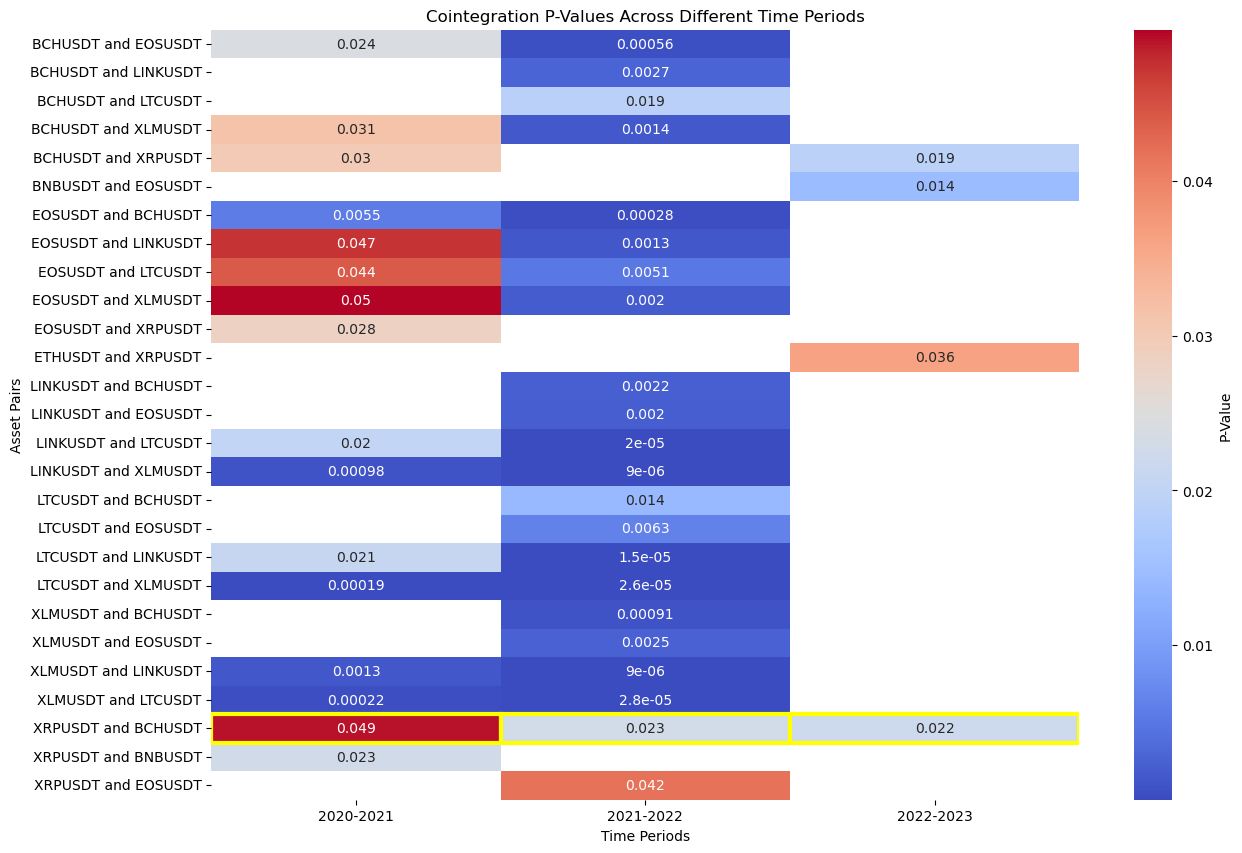

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 coin_crypto_2021, coin_crypto_2122 和 coin_crypto_2223 已经存在
coin_crypto_2021 = pd.DataFrame({
    'Pair': ['BCHUSDT and EOSUSDT', 'BCHUSDT and XLMUSDT', 'BCHUSDT and XRPUSDT', 'EOSUSDT and BCHUSDT', 
             'EOSUSDT and LINKUSDT', 'EOSUSDT and LTCUSDT', 'EOSUSDT and XLMUSDT', 'EOSUSDT and XRPUSDT',
             'LINKUSDT and LTCUSDT', 'LINKUSDT and XLMUSDT', 'LTCUSDT and LINKUSDT', 'LTCUSDT and XLMUSDT',
             'XLMUSDT and LINKUSDT', 'XLMUSDT and LTCUSDT', 'XRPUSDT and BCHUSDT', 'XRPUSDT and BNBUSDT'],
    'P-Value': [0.024216, 0.031336, 0.030084, 0.005472, 0.047426, 0.044026, 0.049787, 0.028499,
                0.020414, 0.000976, 0.020920, 0.000195, 0.001279, 0.000217, 0.049144, 0.022600]
})

coin_crypto_2122 = pd.DataFrame({
    'Pair': ['BCHUSDT and EOSUSDT', 'BCHUSDT and XLMUSDT', 'EOSUSDT and BCHUSDT', 'EOSUSDT and LINKUSDT', 
             'EOSUSDT and LTCUSDT', 'EOSUSDT and XLMUSDT', 'LINKUSDT and LTCUSDT', 'LINKUSDT and XLMUSDT',
             'LTCUSDT and LINKUSDT', 'LTCUSDT and XLMUSDT', 'XLMUSDT and LINKUSDT', 'XLMUSDT and LTCUSDT',
             'XRPUSDT and BCHUSDT', 'XRPUSDT and EOSUSDT', 'BCHUSDT and LINKUSDT', 'BCHUSDT and LTCUSDT', 
             'LINKUSDT and BCHUSDT', 'LINKUSDT and EOSUSDT', 'LTCUSDT and BCHUSDT', 'LTCUSDT and EOSUSDT', 
             'XLMUSDT and BCHUSDT', 'XLMUSDT and EOSUSDT'],
    'P-Value': [0.000562, 0.001403, 0.000281, 0.001349, 0.005068, 0.001951, 0.000020, 0.000009,
                0.000015, 0.000026, 0.000009, 0.000028, 0.022791, 0.041654, 0.002749, 0.018880,
                0.002185, 0.002036, 0.014131, 0.006256, 0.000913, 0.002494]
})

coin_crypto_2223 = pd.DataFrame({
    'Pair': ['BCHUSDT and XRPUSDT', 'XRPUSDT and BCHUSDT', 'BNBUSDT and EOSUSDT', 'ETHUSDT and XRPUSDT'],
    'P-Value': [0.019152, 0.022002, 0.014410, 0.036256]
})

# 合并三个数据框并添加时间段列
coin_crypto_2021['Period'] = '2020-2021'
coin_crypto_2122['Period'] = '2021-2022'
coin_crypto_2223['Period'] = '2022-2023'

combined_df = pd.concat([coin_crypto_2021, coin_crypto_2122, coin_crypto_2223])

# 创建一个透视表
pivot_df = combined_df.pivot(index='Pair', columns='Period', values='P-Value')

# 使用热图可视化
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', cbar_kws={'label': 'P-Value'})

# 高亮显示 XRPUSDT 和 BCHUSDT
highlight_pair = 'XRPUSDT and BCHUSDT'
for period in pivot_df.columns:
    if highlight_pair in pivot_df.index:
        plt.gca().add_patch(plt.Rectangle((pivot_df.columns.get_loc(period), pivot_df.index.get_loc(highlight_pair)),
                                          1, 1, fill=False, edgecolor='yellow', lw=3))

plt.title('Cointegration P-Values Across Different Time Periods')
plt.xlabel('Time Periods')
plt.ylabel('Asset Pairs')
plt.show()

KeyError: (25, 3)

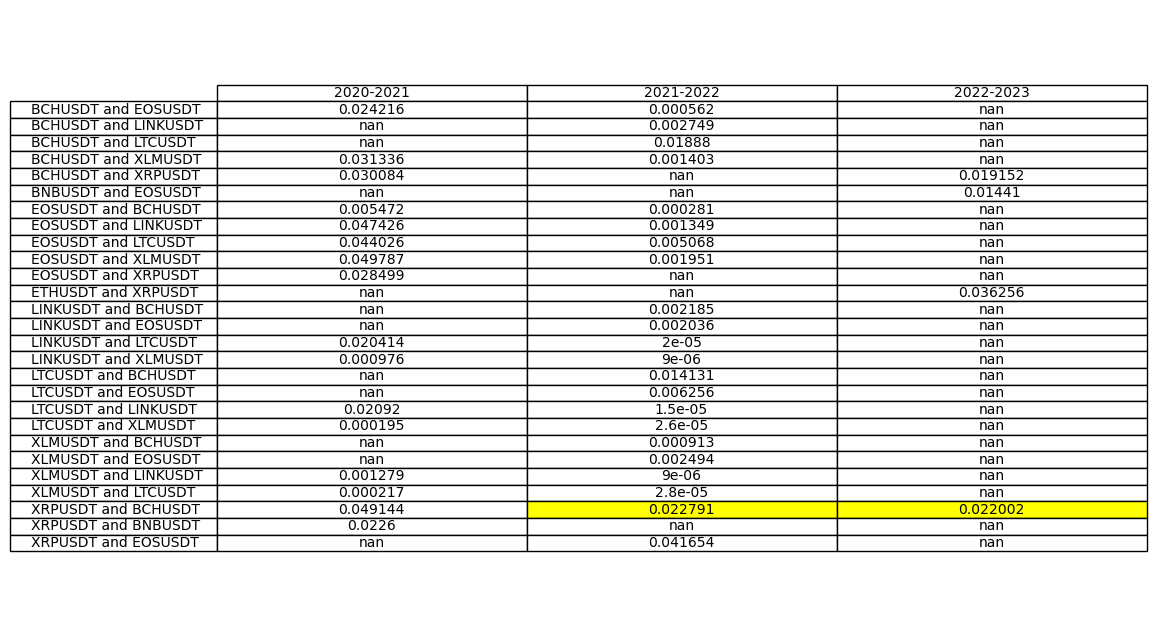

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 创建数据框
coin_crypto_2021 = pd.DataFrame({
    'Pair': ['BCHUSDT and EOSUSDT', 'BCHUSDT and XLMUSDT', 'BCHUSDT and XRPUSDT', 'EOSUSDT and BCHUSDT', 
             'EOSUSDT and LINKUSDT', 'EOSUSDT and LTCUSDT', 'EOSUSDT and XLMUSDT', 'EOSUSDT and XRPUSDT',
             'LINKUSDT and LTCUSDT', 'LINKUSDT and XLMUSDT', 'LTCUSDT and LINKUSDT', 'LTCUSDT and XLMUSDT',
             'XLMUSDT and LINKUSDT', 'XLMUSDT and LTCUSDT', 'XRPUSDT and BCHUSDT', 'XRPUSDT and BNBUSDT'],
    'P-Value': [0.024216, 0.031336, 0.030084, 0.005472, 0.047426, 0.044026, 0.049787, 0.028499,
                0.020414, 0.000976, 0.020920, 0.000195, 0.001279, 0.000217, 0.049144, 0.022600],
    'Period': '2020-2021'
})

coin_crypto_2122 = pd.DataFrame({
    'Pair': ['BCHUSDT and EOSUSDT', 'BCHUSDT and XLMUSDT', 'EOSUSDT and BCHUSDT', 'EOSUSDT and LINKUSDT', 
             'EOSUSDT and LTCUSDT', 'EOSUSDT and XLMUSDT', 'LINKUSDT and LTCUSDT', 'LINKUSDT and XLMUSDT',
             'LTCUSDT and LINKUSDT', 'LTCUSDT and XLMUSDT', 'XLMUSDT and LINKUSDT', 'XLMUSDT and LTCUSDT',
             'XRPUSDT and BCHUSDT', 'XRPUSDT and EOSUSDT', 'BCHUSDT and LINKUSDT', 'BCHUSDT and LTCUSDT', 
             'LINKUSDT and BCHUSDT', 'LINKUSDT and EOSUSDT', 'LTCUSDT and BCHUSDT', 'LTCUSDT and EOSUSDT', 
             'XLMUSDT and BCHUSDT', 'XLMUSDT and EOSUSDT'],
    'P-Value': [0.000562, 0.001403, 0.000281, 0.001349, 0.005068, 0.001951, 0.000020, 0.000009,
                0.000015, 0.000026, 0.000009, 0.000028, 0.022791, 0.041654, 0.002749, 0.018880,
                0.002185, 0.002036, 0.014131, 0.006256, 0.000913, 0.002494],
    'Period': '2021-2022'
})

coin_crypto_2223 = pd.DataFrame({
    'Pair': ['BCHUSDT and XRPUSDT', 'XRPUSDT and BCHUSDT', 'BNBUSDT and EOSUSDT', 'ETHUSDT and XRPUSDT'],
    'P-Value': [0.019152, 0.022002, 0.014410, 0.036256],
    'Period': '2022-2023'
})

# 合并三个数据框并添加时间段列
coin_crypto_2021['Period'] = '2020-2021'
coin_crypto_2122['Period'] = '2021-2022'
coin_crypto_2223['Period'] = '2022-2023'

combined_df = pd.concat([coin_crypto_2021, coin_crypto_2122, coin_crypto_2223])

# 创建一个透视表
pivot_df = combined_df.pivot(index='Pair', columns='Period', values='P-Value')

# 创建一个布尔掩码，标记所有 period 都有值的行
mask = pivot_df.notna().all(axis=1)

# 绘制表格
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制表格的网格线
table = ax.table(cellText=pivot_df.values, 
                 rowLabels=pivot_df.index, 
                 colLabels=pivot_df.columns, 
                 cellLoc='center', 
                 loc='center')

# 设置表格属性
ax.axis('off')

# 高亮显示所有 period 都有值的行
for i, row in enumerate(pivot_df.index):
    if mask[row]:
        for j in range(len(pivot_df.columns)):
            cell = table[(i + 1, j + 1)]  # 表格索引从1开始
            cell.set_facecolor('yellow')

plt.title('Cointegration P-Values Across Different Time Periods', pad=20)
plt.show()


### 3. Best Pair: XRPUSDT & BCHUSDT

In [12]:
pairs_1 = crypto_prices_cleaned[['XRPUSDT',"BCHUSDT"]]
pairs_1

Assets               XRPUSDT  BCHUSDT
Date                                 
2020-01-01 00:00:00  0.19248   204.43
2020-01-01 01:00:00  0.19371   206.19
2020-01-01 02:00:00  0.19418   207.38
2020-01-01 03:00:00  0.19397   205.71
2020-01-01 04:00:00  0.19363   206.20
...                      ...      ...
2024-05-30 20:00:00  0.51880   467.30
2024-05-30 21:00:00  0.52020   467.70
2024-05-30 22:00:00  0.51970   466.50
2024-05-30 23:00:00  0.51860   465.10
2024-05-31 00:00:00  0.51980   464.60

[38657 rows x 2 columns]

In [14]:
csv_path = r"C:\Users\夏天\Desktop\AlgoTrading Project\pairs.csv"
pairs_1.to_csv(csv_path)

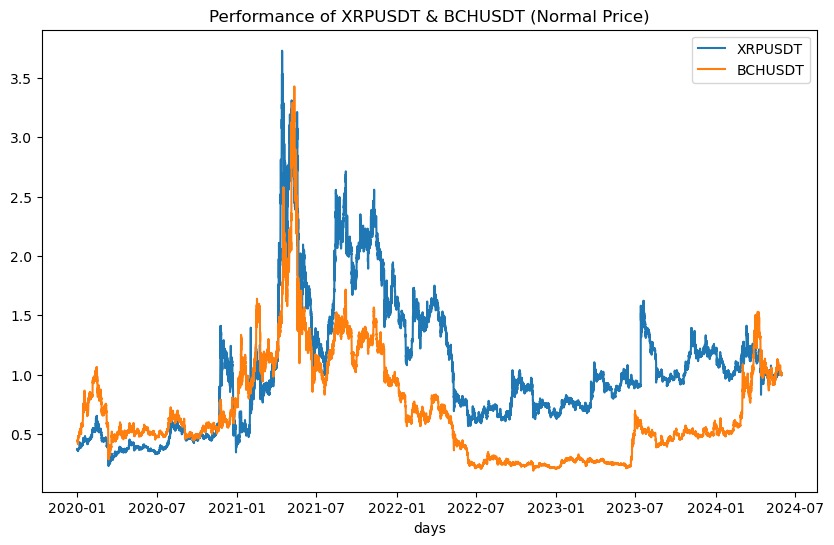

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(norm_prices[['XRPUSDT',"BCHUSDT"]])
plt.xlabel('days')
plt.title('Performance of XRPUSDT & BCHUSDT (Normal Price)')
plt.legend(pairs_1.columns)
plt.show()

### 4. Train Data（2021-2023）

In [16]:
pairs1_train_2123 = pairs_1.loc['2020-01-01':'2023-12-31']
pairs1_train_2123

Assets               XRPUSDT  BCHUSDT
Date                                 
2020-01-01 00:00:00  0.19248   204.43
2020-01-01 01:00:00  0.19371   206.19
2020-01-01 02:00:00  0.19418   207.38
2020-01-01 03:00:00  0.19397   205.71
2020-01-01 04:00:00  0.19363   206.20
...                      ...      ...
2023-12-31 19:00:00  0.62060   261.40
2023-12-31 20:00:00  0.61830   260.50
2023-12-31 21:00:00  0.61930   261.30
2023-12-31 22:00:00  0.61140   256.00
2023-12-31 23:00:00  0.61560   259.70

[35032 rows x 2 columns]

### 4.1 Pairs Trading Strategy

In [17]:
def calculate_rolling_beta(data, y_col, x_col, window):
    y = data[y_col]
    x = data[x_col]

    def rolling_ols_beta(y, x):
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        return model.params[1] 

    rolling_beta = y.rolling(window=window).apply(lambda y: rolling_ols_beta(y, x[y.index]), raw=False)
    return rolling_beta

def calculate_rolling_intercept(data, y_col, x_col, window):
    y = data[y_col]
    x = data[x_col]

    def rolling_ols_intercept(y, x):
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        return model.params[0] 

    rolling_intercept = y.rolling(window=window).apply(lambda y: rolling_ols_intercept(y, x[y.index]), raw=False)
    return rolling_intercept

In [21]:
def pairs_trading_strategy(data,label1,label2, z_signal_in, z_signal_out, min_spread, MA_window, OLS_window):
    data['beta'] = calculate_rolling_beta(data, label1, label2, OLS_window)
    data['intercept'] = calculate_rolling_intercept(data, label1, label2, OLS_window)
    data = data.dropna()
    
    data['spread'] = ((data[label1] - data['beta'] * data[label2]) - data['intercept'])
    data['Spread_MA'] = data['spread'].rolling(window=MA_window).mean()
    data['Spread_Std'] = data['spread'].rolling(window=MA_window).std()
    
    data['zscors'] = (data['spread'] - data['Spread_MA']) / data['Spread_Std']
    
    data['signal'] = np.nan
    data.loc[(data['zscors'] > z_signal_in) & (np.abs(data['spread']) > min_spread), 'signal'] = -1
    data.loc[(data['zscors'] < -z_signal_in) & (np.abs(data['spread']) > min_spread), 'signal'] = 1
    data.loc[data['zscors'].abs() < z_signal_out, 'signal'] = 0
    
    data['position'] = data['signal'].fillna(method='ffill').fillna(0).astype(int)
    
    data['return_Y'] = np.log(data[label1] / data[label1].shift(1)) 
    data['return_X'] = np.log(data[label2] / data[label2].shift(1)) 
    data['position_Y'] = data['position']
    data['position_Y'] = data['position_Y'].shift(1)
    data['position_X'] = data['position'] * data['beta'] * (-1)
    data['position_X'] = data['position_X'].shift(1)
    data['hourlypnl'] = (data['position_Y'] * data['return_Y'] + data['position_X'] * data['return_X'])
    data['cumpnl'] = data['hourlypnl'].cumsum()
    data['max_cumpnl'] = data['cumpnl'].cummax()
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(data.index, data['spread'], label='Spread')
#     plt.xlabel('Date')
#     plt.ylabel('Spread')
#     plt.title(f'Spread of Pairs ({label1} & {label2})')
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(10, 6))
#     plt.plot(data.index, data['zscors'], label='Z-scores')
#     plt.xlabel('Date')
#     plt.ylabel('Z-score')
#     plt.title(f'Z-scores of Pairs ({label1} & {label2})')
#     plt.axhline(y=0, color='red', linestyle='--')
#     plt.legend()
#     plt.show()

#     change = data['position'].diff().fillna(0)
#     plt.figure(figsize=(10, 6))
#     plt.plot(data.index, data['spread'], label='Spread')
#     buy_signals = data.index[change == 1]
#     sell_signals = data.index[change == -1]
#     buy_signal_y_value = data['spread'].min() - 0.05
#     sell_signal_y_value = data['spread'].min() - 0.08
#     plt.scatter(buy_signals, data['spread'][buy_signals], color='red', marker='^', s=50, label='Buy Signal')
#     plt.scatter(sell_signals, data['spread'][sell_signals], color='green', marker='o', s=50, label='Sell Signal')
    
#     plt.scatter(buy_signals, [buy_signal_y_value] * len(buy_signals), color='red', marker='^', s=50)
#     plt.scatter(sell_signals, [sell_signal_y_value] * len(sell_signals), color='green', marker='o', s=50)
#     plt.axhline(buy_signal_y_value, color='black', linestyle='--', linewidth=0.5)
#     plt.axhline(sell_signal_y_value, color='black', linestyle='--', linewidth=0.5)
#     plt.xlabel('Date')
#     plt.ylabel('Spread')
#     plt.title(f'Trading Signals of Pairs ({label1} & {label2})')
#     plt.legend()
#     plt.show()
    
    return data

### 4.1.1 Setting Parameters

In [19]:
z_signal_in = 1.96
z_signal_out = 0.25
min_spread = 0.005
MA_window = 90
OLS_window = 365*24

### 4.2 Backtest

### 4.2.1 Train Data (2021-2023)

### 4.2.1.1 Calculate Positions

In [22]:
pairs1_train_2123 = pairs_trading_strategy(pairs1_train_2123,'XRPUSDT','BCHUSDT',z_signal_in, 
                                           z_signal_out, min_spread, MA_window, OLS_window
                                          )
pairs1_train_2123

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-01-02 00:00:00   0.8460    446.6  0.001340   0.056398  0.191128   
2022-01-02 01:00:00   0.8424    447.5  0.001340   0.056656  0.186215   
2022-01-02 02:00:00   0.8436    449.4  0.001339   0.056913  0.184763   
2022-01-02 03:00:00   0.8438    448.4  0.001339   0.057169  0.186196   
2022-01-02 04:00:00   0.8390    444.7  0.001339   0.057422  0.186245   
...                      ...      ...       ...        ...       ...   
2023-12-31 14:00:00   0.6223    262.7  0.001242   0.288524  0.007517   
2023-12-31 16:00:00   0.6229    263.3  0.001242   0.288601  0.007383   
2023-12-31 19:00:00   0.6206    261.4  0.001241   0.288718  0.007459   
2023-12-31 20:00:00   0.6183    260.5  0.001241   0.288757  0.006281   
2023-12-31 21:00:00   0.6193    261.3  0.001241   0.288796  0.006294   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2022-01-02 00:00:00        NaN         NaN       NaN     NaN         0   
2022-01-02 01:00:00        NaN         NaN       NaN     NaN         0   
2022-01-02 02:00:00        NaN         NaN       NaN     NaN         0   
2022-01-02 03:00:00        NaN         NaN       NaN     NaN         0   
2022-01-02 04:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2023-12-31 14:00:00   0.035235    0.019843 -1.396899     NaN         1   
2023-12-31 16:00:00   0.034998    0.020048 -1.377459     NaN         1   
2023-12-31 19:00:00   0.034785    0.020239 -1.350190     NaN         1   
2023-12-31 20:00:00   0.034568    0.020440 -1.383883     NaN         1   
2023-12-31 21:00:00   0.034288    0.020654 -1.355366     NaN         1   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2022-01-02 00:00:00       NaN       NaN         NaN         NaN        NaN   
2022-01-02 01:00:00 -0.004264  0.002013         0.0   -0.000000  -0.000000   
2022-01-02 02:00:00  0.001423  0.004237         0.0   -0.000000   0.000000   
2022-01-02 03:00:00  0.000237 -0.002228         0.0   -0.000000   0.000000   
2022-01-02 04:00:00 -0.005705 -0.008286         0.0   -0.000000   0.000000   
...                       ...       ...         ...         ...        ...   
2023-12-31 14:00:00  0.003058 -0.059841         1.0   -0.001247   0.003132   
2023-12-31 16:00:00  0.000964  0.002281         1.0   -0.001242   0.000961   
2023-12-31 19:00:00 -0.003699 -0.007242         1.0   -0.001242  -0.003690   
2023-12-31 20:00:00 -0.003713 -0.003449         1.0   -0.001241  -0.003709   
2023-12-31 21:00:00  0.001616  0.003066         1.0   -0.001241   0.001612   

Assets                 cumpnl  max_cumpnl  
Date                                       
2022-01-02 00:00:00       NaN         NaN  
2022-01-02 01:00:00  0.000000    0.000000  
2022-01-02 02:00:00  0.000000    0.000000  
2022-01-02 03:00:00  0.000000    0.000000  
2022-01-02 04:00:00  0.000000    0.000000  
...                       ...         ...  
2023-12-31 14:00:00 -0.342630    0.020365  
2023-12-31 16:00:00 -0.341670    0.020365  
2023-12-31 19:00:00 -0.345360    0.020365  
2023-12-31 20:00:00 -0.349069    0.020365  
2023-12-31 21:00:00 -0.347456    0.020365  

[4343 rows x 17 columns]

### 4.2.1.2 Performance

In [88]:
def pnlPerformance(pnl, pairs,label,year,stop_loss):
    cumpnl = pnl.cumsum(skipna=True)
    max_cumpnl = cumpnl.cummax(skipna=True)
    sharpe = pnl.mean() / np.std(pnl)
    sharpe = sharpe * np.sqrt(24 * 252)
    
    average_annual_returns = pnl.mean() * 24 * 252 * 100
    total_returns = pnl.sum() * 100
    
    highwatermark_df = cumpnl.cummax()
    drawdown_df = cumpnl - highwatermark_df
    maxdrawdown = drawdown_df.min()
    
    max_drawdown_start = drawdown_df.idxmin()
    max_drawdown_end = \
       drawdown_df[drawdown_df == 0].index[0] if not drawdown_df[drawdown_df == 0].empty else max_drawdown_start
    max_drawdown_period = max_drawdown_end - max_drawdown_start
    
    performance_stats = {'Year': year,
                         'Stop-Loss':stop_loss,
                         'Sharpe Ratio': sharpe,
                         'Average Annual Returns (%)': average_annual_returns,
                         'Total Returns (%)': total_returns,
                         'Max Drawdown (%)': maxdrawdown * 100,
                         'Max Drawdown Period': max_drawdown_period
                        }
    
    performance_df = pd.DataFrame(performance_stats, index=[label])
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumpnl.values, label='Cumulative PnL')
    plt.plot(max_cumpnl.values, label='Max Cumulative PnL')
    plt.legend()
    plt.title(f"Performance of Pairs {pairs}")
    plt.show()
    
    return performance_df

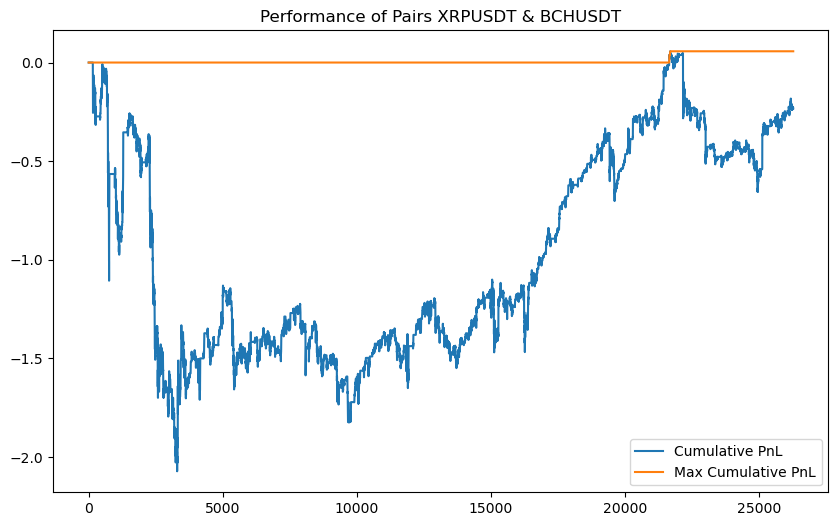

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021-2023        No     -0.072397                   -5.352018   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         -23.248711       -207.200261 -138 days +07:00:00

In [89]:
pairs1_train_2123_performance = \
   pnlPerformance(pairs1_train_2123['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Train','2021-2023','No')
pairs1_train_2123_performance

### 4.2.2 Train Data (2022-2023) - Drop Extreme Market

### 4.2.2.1 Calculate Positions

In [90]:
pairs1_train_2223 = pairs_1.loc['2021-01-01':'2023-12-31']
pairs1_train_2223

Assets               XRPUSDT  BCHUSDT
Date                                 
2021-01-01 00:00:00  0.22162   341.44
2021-01-01 01:00:00  0.22382   349.71
2021-01-01 02:00:00  0.22361   354.37
2021-01-01 03:00:00  0.22730   350.95
2021-01-01 04:00:00  0.23898   348.21
...                      ...      ...
2023-12-31 19:00:00  0.62060   261.40
2023-12-31 20:00:00  0.61830   260.50
2023-12-31 21:00:00  0.61930   261.30
2023-12-31 22:00:00  0.61140   256.00
2023-12-31 23:00:00  0.61560   259.70

[26266 rows x 2 columns]

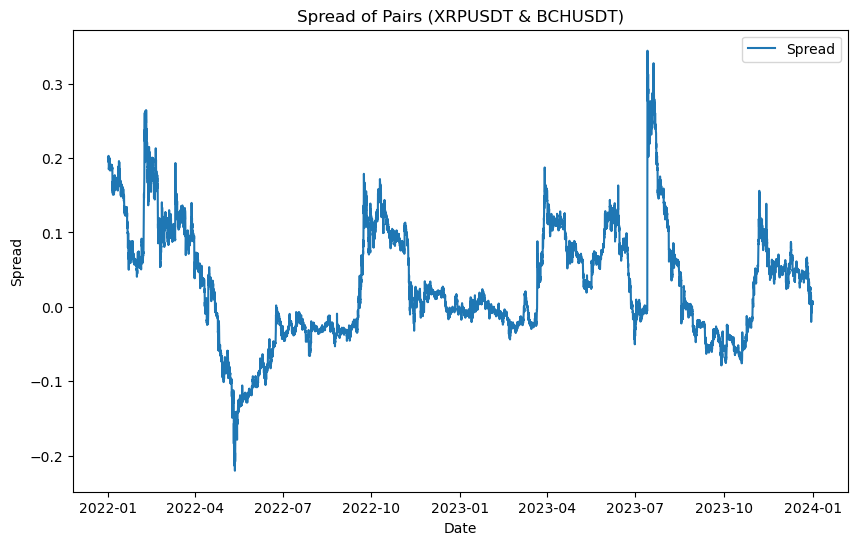

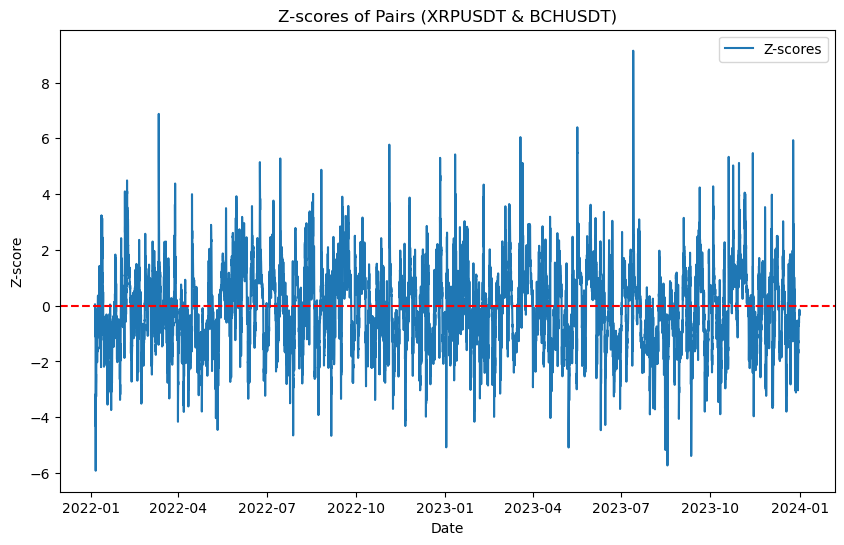

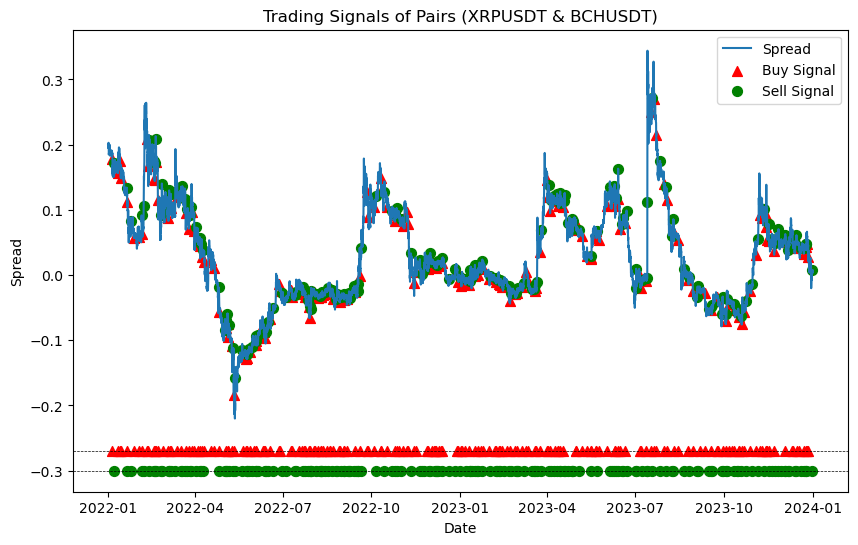

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-01-01 12:00:00   0.8425    438.5  0.001344   0.053213  0.199841   
2022-01-01 13:00:00   0.8409    437.2  0.001344   0.053485  0.199873   
2022-01-01 14:00:00   0.8399    440.1  0.001344   0.053755  0.194861   
2022-01-01 15:00:00   0.8425    441.4  0.001343   0.054026  0.195600   
2022-01-01 16:00:00   0.8448    442.7  0.001343   0.054293  0.196041   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00   0.6206    261.4  0.001241   0.288718  0.007459   
2023-12-31 20:00:00   0.6183    260.5  0.001241   0.288757  0.006281   
2023-12-31 21:00:00   0.6193    261.3  0.001241   0.288796  0.006294   
2023-12-31 22:00:00   0.6114    256.0  0.001241   0.288835  0.004976   
2023-12-31 23:00:00   0.6156    259.7  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2022-01-01 12:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 13:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 14:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 15:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 16:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0         0   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0         0   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0         0   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN         0   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN         0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2022-01-01 12:00:00       NaN       NaN         NaN         NaN        NaN   
2022-01-01 13:00:00 -0.001901 -0.002969         0.0        -0.0        0.0   
2022-01-01 14:00:00 -0.001190  0.006611         0.0        -0.0       -0.0   
2022-01-01 15:00:00  0.003091  0.002950         0.0        -0.0        0.0   
2022-01-01 16:00:00  0.002726  0.002941         0.0        -0.0        0.0   
...                       ...       ...         ...         ...        ...   
2023-12-31 19:00:00 -0.000805 -0.007242         0.0        -0.0        0.0   
2023-12-31 20:00:00 -0.003713 -0.003449         0.0        -0.0        0.0   
2023-12-31 21:00:00  0.001616  0.003066         0.0        -0.0        0.0   
2023-12-31 22:00:00 -0.012838 -0.020492         0.0        -0.0        0.0   
2023-12-31 23:00:00  0.006846  0.014350         0.0        -0.0        0.0   

Assets                 cumpnl  max_cumpnl  
Date                                       
2022-01-01 12:00:00       NaN         NaN  
2022-01-01 13:00:00  0.000000    0.000000  
2022-01-01 14:00:00  0.000000    0.000000  
2022-01-01 15:00:00  0.000000    0.000000  
2022-01-01 16:00:00  0.000000    0.000000  
...                       ...         ...  
2023-12-31 19:00:00  1.251415    1.540951  
2023-12-31 20:00:00  1.251415    1.540951  
2023-12-31 21:00:00  1.251415    1.540951  
2023-12-31 22:00:00  1.251415    1.540951  
2023-12-31 23:00:00  1.251415    1.540951  

[17507 rows x 17 columns]

In [91]:
pairs1_train_2223 = \
   pairs_trading_strategy(pairs1_train_2223,'XRPUSDT','BCHUSDT',z_signal_in, 
                          z_signal_out, min_spread, MA_window, OLS_window
                         )
pairs1_train_2223

### 4.2.2.2 Performance

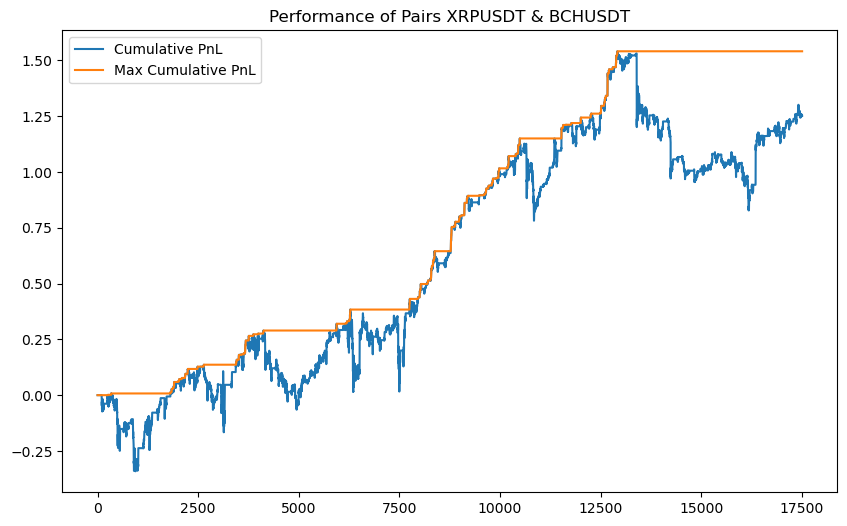

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022-2023        No      0.804799                   43.234076   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         125.141491        -71.267322 -675 days +16:00:00

In [92]:
pairs1_train_2223_performance = \
   pnlPerformance(pairs1_train_2223['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Train','2022-2023','No')
pairs1_train_2223_performance

### 4.3 Stop-Loss Strategy

### 4.3.1 Stop-Loss Strategy 1

In [93]:
def stop_loss_strategy1(data, label1,label2, num_consecutive_losses=4):
    stoploss_data = data.copy()
    new_data = data.copy()

    stoploss_data['stop_loss_signal'] = np.nan
    for i in range(3, len(stoploss_data)):
        if (stoploss_data['hourlypnl'].iloc[i-3] < 0 and
            stoploss_data['hourlypnl'].iloc[i-2] < 0 and
            stoploss_data['hourlypnl'].iloc[i-1] < 0 and
            stoploss_data['hourlypnl'].iloc[i] < 0):
            stoploss_data['stop_loss_signal'].iloc[i] = 0

    new_data['signal'].update(stoploss_data['stop_loss_signal'])

    new_data['position'] = new_data['signal'].fillna(method='ffill').fillna(0).astype(int)
    new_data['position'] = new_data['position'].shift(1)

    new_data['return_XR'] = np.log(new_data['XRPUSDT'] / new_data['XRPUSDT'].shift(1))
    new_data['return_BC'] = np.log(new_data['BCHUSDT'] / new_data['BCHUSDT'].shift(1))

    new_data['XRposition'] = new_data['position']
    new_data['BCposition'] = new_data['position'] * new_data['beta'] * (-1)
    new_data['hourlypnl'] = (new_data['XRposition'] * new_data['return_XR'] +
                             new_data['BCposition'] * new_data['return_BC']
                            )
    
    new_data['cumpnl'] = new_data['hourlypnl'].cumsum()
    new_data['max_cumpnl'] = new_data['cumpnl'].cummax()
    
    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['spread'], label='Spread')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title(f'Spread of Pairs ({label1} & {label2})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['zscors'], label='Z-scores')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.title(f'Z-scores of Pairs ({label1} & {label2})')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.show()

    change = new_data['position'].diff().fillna(0)
    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['spread'], label='Spread')
    buy_signals = new_data.index[change == 1]
    sell_signals = new_data.index[change == -1]
    buy_signal_y_value = new_data['spread'].min() - 0.05
    sell_signal_y_value = new_data['spread'].min() - 0.08
    plt.scatter(buy_signals, new_data['spread'][buy_signals], color='red', marker='^', s=50, label='Buy Signal')
    plt.scatter(sell_signals, new_data['spread'][sell_signals], color='green', marker='o', s=50, label='Sell Signal')
    
    plt.scatter(buy_signals, [buy_signal_y_value] * len(buy_signals), color='red', marker='^', s=50, label='Buy Signal')
    plt.scatter(sell_signals, [sell_signal_y_value] * len(sell_signals), color='green', marker='o', s=50, label='Sell Signal')
    plt.axhline(buy_signal_y_value, color='black', linestyle='--', linewidth=0.5)
    plt.axhline(sell_signal_y_value, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title(f'Trading Signals of Pairs ({label1} & {label2})')
    plt.legend()
    plt.show()
        
    return new_data


### 4.3.1.1  Stop-Loss Strategy 1 - Train Data (2021-2023)

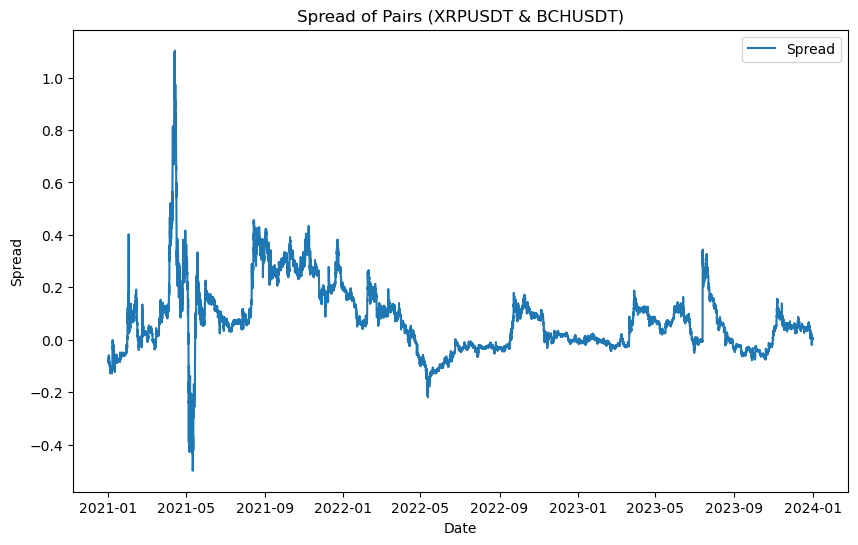

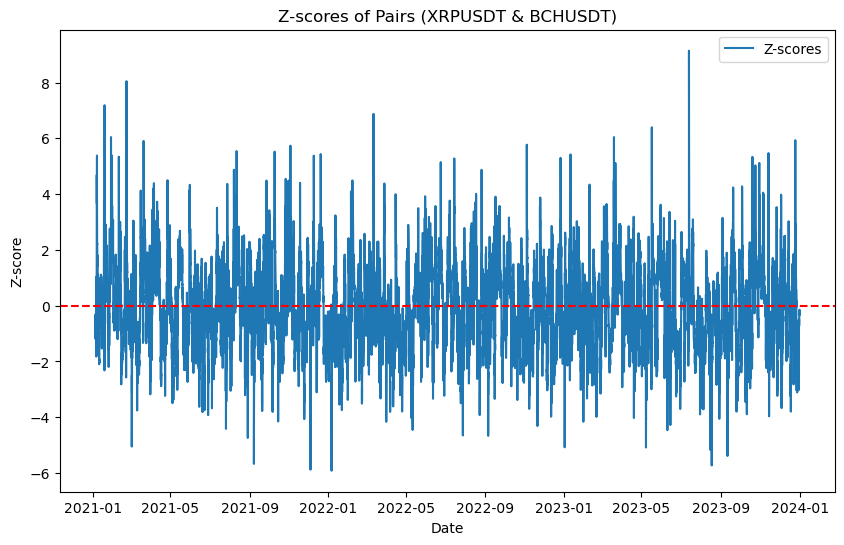

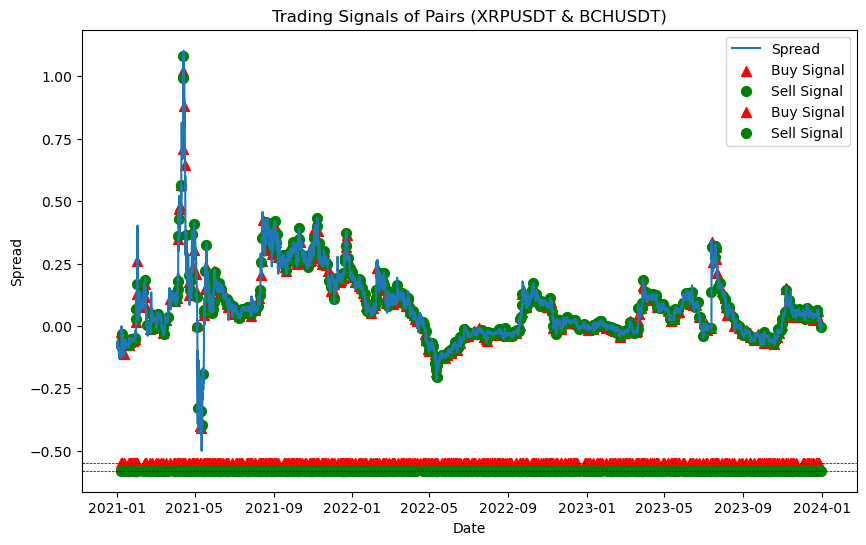

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2020-12-31 17:00:00  0.21814   342.45  0.000648   0.082809 -0.086668   
2020-12-31 18:00:00  0.21825   342.90  0.000648   0.082877 -0.086822   
2020-12-31 19:00:00  0.21910   342.39  0.000648   0.082944 -0.085614   
2020-12-31 20:00:00  0.22109   341.34  0.000647   0.083009 -0.082918   
2020-12-31 21:00:00  0.22448   342.86  0.000647   0.083073 -0.080487   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00  0.62060   261.40  0.001241   0.288718  0.007459   
2023-12-31 20:00:00  0.61830   260.50  0.001241   0.288757  0.006281   
2023-12-31 21:00:00  0.61930   261.30  0.001241   0.288796  0.006294   
2023-12-31 22:00:00  0.61140   256.00  0.001241   0.288835  0.004976   
2023-12-31 23:00:00  0.61560   259.70  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  ...  \
Date                                                                    ...   
2020-12-31 17:00:00        NaN         NaN       NaN     NaN       NaN  ...   
2020-12-31 18:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2020-12-31 19:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2020-12-31 20:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2020-12-31 21:00:00        NaN         NaN       NaN     NaN       0.0  ...   
...                        ...         ...       ...     ...       ...  ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0       0.0  ...   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0       0.0  ...   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0       0.0  ...   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN       0.0  ...   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN       0.0  ...   

Assets               return_X  position_Y  position_X  hourlypnl    cumpnl  \
Date                                                                         
2020-12-31 17:00:00       NaN         NaN         NaN        NaN       NaN   
2020-12-31 18:00:00  0.001313         0.0        -0.0        0.0  0.000000   
2020-12-31 19:00:00 -0.001488         0.0        -0.0        0.0  0.000000   
2020-12-31 20:00:00 -0.003071         0.0        -0.0        0.0  0.000000   
2020-12-31 21:00:00  0.004443         0.0        -0.0        0.0  0.000000   
...                       ...         ...         ...        ...       ...   
2023-12-31 19:00:00 -0.007242         0.0        -0.0        0.0 -0.771619   
2023-12-31 20:00:00 -0.003449         0.0        -0.0        0.0 -0.771619   
2023-12-31 21:00:00  0.003066         0.0        -0.0        0.0 -0.771619   
2023-12-31 22:00:00 -0.020492         0.0        -0.0        0.0 -0.771619   
2023-12-31 23:00:00  0.014350         0.0        -0.0        0.0 -0.771619   

Assets               max_cumpnl  return_XR  return_BC  XRposition  BCposition  
Date                                                                           
2020-12-31 17:00:00         NaN        NaN        NaN         NaN         NaN  
2020-12-31 18:00:00         0.0   0.000504   0.001313         0.0        -0.0  
2020-12-31 19:00:00         0.0   0.003887  -0.001488         0.0        -0.0  
2020-12-31 20:00:00         0.0   0.009042  -0.003071         0.0        -0.0  
2020-12-31 21:00:00         0.0   0.015217   0.004443         0.0        -0.0  
...                         ...        ...        ...         ...         ...  
2023-12-31 19:00:00         0.0  -0.000805  -0.007242         0.0        -0.0  
2023-12-31 20:00:00         0.0  -0.003713  -0.003449         0.0        -0.0  
2023-12-31 21:00:00         0.0   0.001616   0.003066         0.0        -0.0  
2023-12-31 22:00:00         0.0  -0.012838  -0.020492         0.0        -0.0  
2023-12-31 23:00:00         0.0   0.006846   0.014350       

In [94]:
stoploss1_pairs1_train_2123 = \
   stop_loss_strategy1(pairs1_train_2123, 'XRPUSDT','BCHUSDT',num_consecutive_losses=4)
stoploss1_pairs1_train_2123

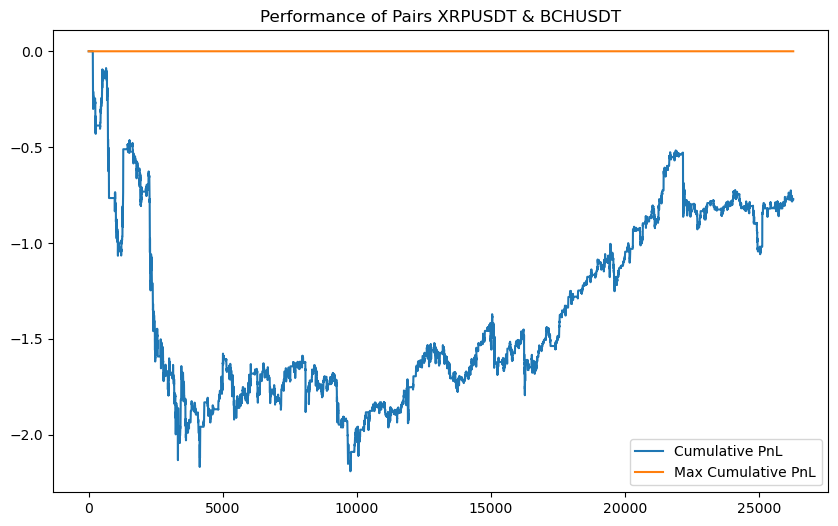

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021-2023  Strategy 1     -0.280951                  -17.763218   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         -77.161916       -219.061716 -408 days +20:00:00

In [95]:
pairs1_train_2123_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_train_2123['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2021-2023','Strategy 1')
pairs1_train_2123_stoploss1_performance

### 4.3.1.2 Stop-Loss Strategy 1 - Train Data (2022-2023)

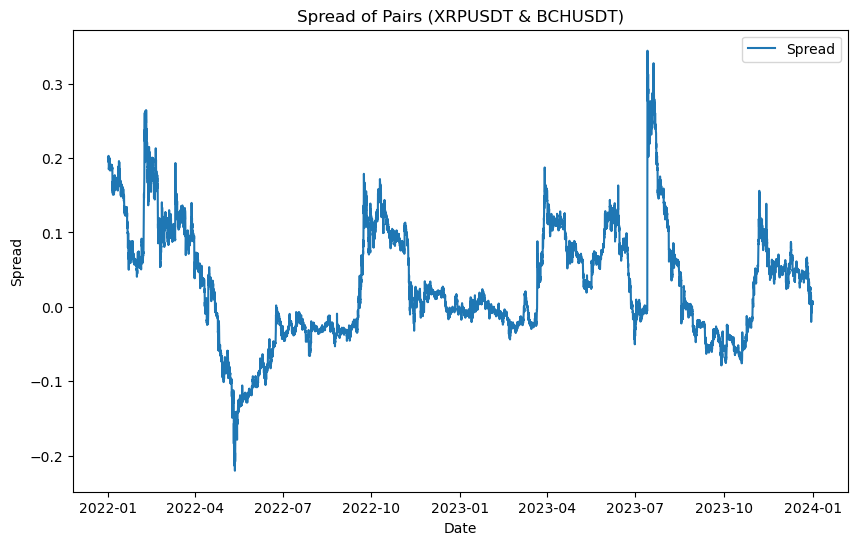

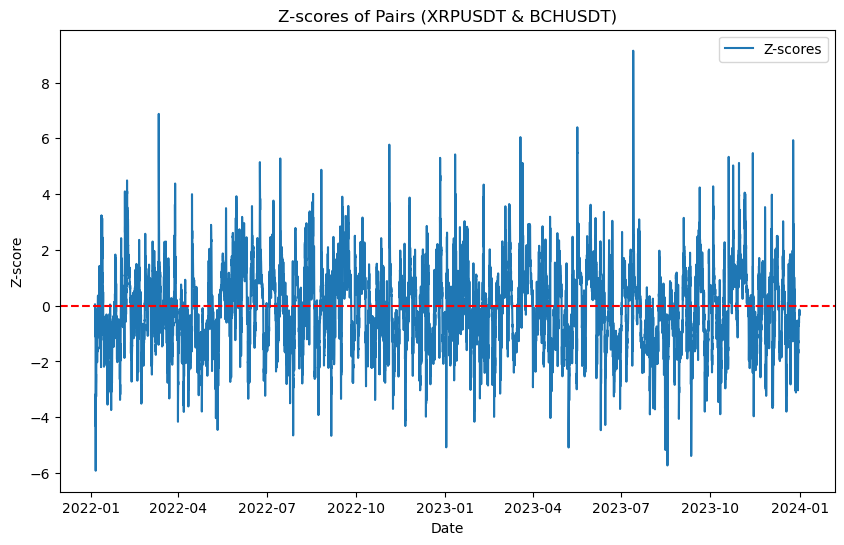

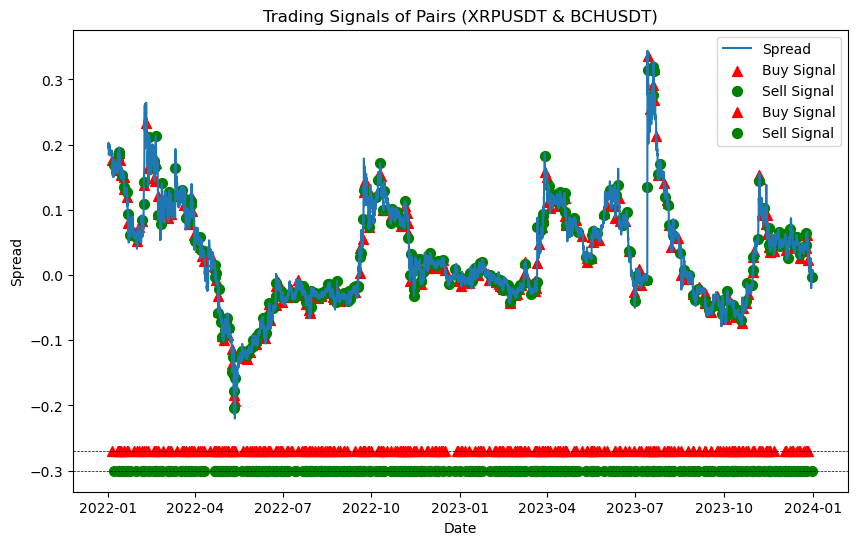

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-01-01 12:00:00   0.8425    438.5  0.001344   0.053213  0.199841   
2022-01-01 13:00:00   0.8409    437.2  0.001344   0.053485  0.199873   
2022-01-01 14:00:00   0.8399    440.1  0.001344   0.053755  0.194861   
2022-01-01 15:00:00   0.8425    441.4  0.001343   0.054026  0.195600   
2022-01-01 16:00:00   0.8448    442.7  0.001343   0.054293  0.196041   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00   0.6206    261.4  0.001241   0.288718  0.007459   
2023-12-31 20:00:00   0.6183    260.5  0.001241   0.288757  0.006281   
2023-12-31 21:00:00   0.6193    261.3  0.001241   0.288796  0.006294   
2023-12-31 22:00:00   0.6114    256.0  0.001241   0.288835  0.004976   
2023-12-31 23:00:00   0.6156    259.7  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  ...  \
Date                                                                    ...   
2022-01-01 12:00:00        NaN         NaN       NaN     NaN       NaN  ...   
2022-01-01 13:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2022-01-01 14:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2022-01-01 15:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2022-01-01 16:00:00        NaN         NaN       NaN     NaN       0.0  ...   
...                        ...         ...       ...     ...       ...  ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0       0.0  ...   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0       0.0  ...   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0       0.0  ...   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN       0.0  ...   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN       0.0  ...   

Assets               return_X  position_Y  position_X  hourlypnl    cumpnl  \
Date                                                                         
2022-01-01 12:00:00       NaN         NaN         NaN        NaN       NaN   
2022-01-01 13:00:00 -0.002969         0.0        -0.0        0.0  0.000000   
2022-01-01 14:00:00  0.006611         0.0        -0.0       -0.0  0.000000   
2022-01-01 15:00:00  0.002950         0.0        -0.0        0.0  0.000000   
2022-01-01 16:00:00  0.002941         0.0        -0.0        0.0  0.000000   
...                       ...         ...         ...        ...       ...   
2023-12-31 19:00:00 -0.007242         0.0        -0.0        0.0  0.926484   
2023-12-31 20:00:00 -0.003449         0.0        -0.0        0.0  0.926484   
2023-12-31 21:00:00  0.003066         0.0        -0.0        0.0  0.926484   
2023-12-31 22:00:00 -0.020492         0.0        -0.0        0.0  0.926484   
2023-12-31 23:00:00  0.014350         0.0        -0.0        0.0  0.926484   

Assets               max_cumpnl  return_XR  return_BC  XRposition  BCposition  
Date                                                                           
2022-01-01 12:00:00         NaN        NaN        NaN         NaN         NaN  
2022-01-01 13:00:00    0.000000  -0.001901  -0.002969         0.0        -0.0  
2022-01-01 14:00:00    0.000000  -0.001190   0.006611         0.0        -0.0  
2022-01-01 15:00:00    0.000000   0.003091   0.002950         0.0        -0.0  
2022-01-01 16:00:00    0.000000   0.002726   0.002941         0.0        -0.0  
...                         ...        ...        ...         ...         ...  
2023-12-31 19:00:00    1.180971  -0.000805  -0.007242         0.0        -0.0  
2023-12-31 20:00:00    1.180971  -0.003713  -0.003449         0.0        -0.0  
2023-12-31 21:00:00    1.180971   0.001616   0.003066         0.0        -0.0  
2023-12-31 22:00:00    1.180971  -0.012838  -0.020492         0.0        -0.0  
2023-12-31 23:00:00    1.180971   0.006846   0.014350       

In [96]:
stoploss1_pairs1_train_2223 = \
   stop_loss_strategy1(pairs1_train_2223, 'XRPUSDT','BCHUSDT',num_consecutive_losses=4)
stoploss1_pairs1_train_2223

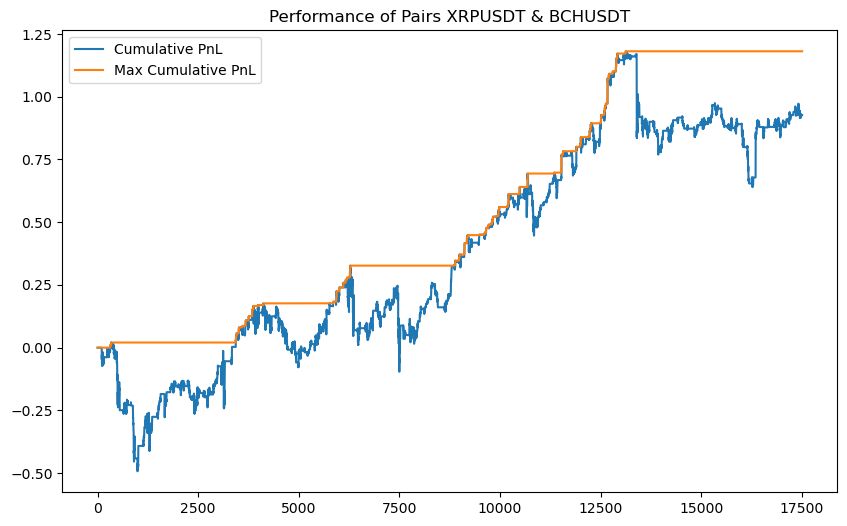

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022-2023  Strategy 1      0.682684                   32.008314   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          92.648404        -54.134008 -679 days +23:00:00

In [97]:
pairs1_train_2223_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_train_2223['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2022-2023','Strategy 1'
                 )
pairs1_train_2223_stoploss1_performance

### 4.3.2 Stop-Loss Strategy 2

In [98]:
def bollinger_band_stop_loss(data,pnl_label,label1,label2,boll_window,std_multiplier):
    stoploss_data = data.copy()
    new_data = data.copy()
    stoploss_data['Rolling_mean'] = stoploss_data[pnl_label].rolling(boll_window).mean()
    stoploss_data['Rolling_std'] = stoploss_data[pnl_label].rolling(boll_window).std()
    stoploss_data['Upper_band'] = stoploss_data['Rolling_mean'] + std_multiplier * stoploss_data['Rolling_std']
    stoploss_data['Lower_band'] = stoploss_data['Rolling_mean'] - std_multiplier * stoploss_data['Rolling_std']
    stoploss_data['Stop_Loss'] = np.where((stoploss_data[pnl_label] < stoploss_data['Lower_band']) | 
                                          (stoploss_data[pnl_label] > stoploss_data['Upper_band']),
                                          0, np.nan)

    new_data['stop_loss_signal'] = stoploss_data['Stop_Loss']
    new_data['signal'].update(new_data['stop_loss_signal'])
    
    new_data['position'] = new_data['signal'].fillna(method='ffill').fillna(0).astype(int)
    new_data['position'] = new_data['position'].shift(1)
    
    new_data['return_Y'] = np.log(new_data[label1] / new_data[label1].shift(1)) 
    new_data['return_X'] = np.log(new_data[label2] / new_data[label2].shift(1)) 
    new_data['position_Y'] = new_data['position']
    new_data['position_X'] = new_data['position'] * new_data['beta'] * (-1)
    new_data['hourlypnl'] = (new_data['position_Y'] * new_data['return_Y'] 
                             + new_data['position_X'] * new_data['return_X'])
    new_data['cumpnl'] = new_data['hourlypnl'].cumsum()
    new_data['max_cumpnl'] = new_data['cumpnl'].cummax()
    
    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['spread'], label='Spread')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title(f'Spread of Pairs ({label1} & {label2})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['zscors'], label='Z-scores')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.title(f'Z-scores of Pairs ({label1} & {label2})')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.show()

    change = new_data['position'].diff().fillna(0)
    plt.figure(figsize=(10, 6))
    plt.plot(new_data.index, new_data['spread'], label='Spread')
    buy_signals = new_data.index[change == 1]
    sell_signals = new_data.index[change == -1]
    buy_signal_y_value = new_data['spread'].min() - 0.05
    sell_signal_y_value = new_data['spread'].min() - 0.07
    plt.scatter(buy_signals, new_data['spread'][buy_signals], color='red', marker='^', s=50, label='Buy Signal')
    plt.scatter(sell_signals, new_data['spread'][sell_signals], color='green', marker='o', s=50, label='Sell Signal')
    plt.scatter(buy_signals, [buy_signal_y_value] * len(buy_signals), color='red', marker='^', s=50, label='Buy Signal')
    plt.scatter(sell_signals, [sell_signal_y_value] * len(sell_signals), color='green', marker='o', s=50, label='Sell Signal')
    plt.axhline(buy_signal_y_value, color='black', linestyle='--', linewidth=0.5)
    plt.axhline(sell_signal_y_value, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title(f'Trading Signals of Pairs ({label1} & {label2})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(stoploss_data.index, stoploss_data[pnl_label], label='Cumulative PnL')
    plt.plot(stoploss_data.index, stoploss_data['Rolling_mean'], label='Rolling Mean', linestyle='--')
    plt.plot(stoploss_data.index, stoploss_data['Upper_band'], label='Upper Band', linestyle='--')
    plt.plot(stoploss_data.index, stoploss_data['Lower_band'], label='Lower Band', linestyle='--')
    plt.fill_between(stoploss_data.index, stoploss_data['Lower_band'], stoploss_data['Upper_band'], color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.title('Bollinger Bands for Cumulative PnL')
    plt.legend()
    plt.show()
    
    return new_data

In [99]:
boll_window = 15
std_multiplier = 1.96

### 4.3.2.1 Stop-Loss Strategy 2 - Train Data (2021-2023)

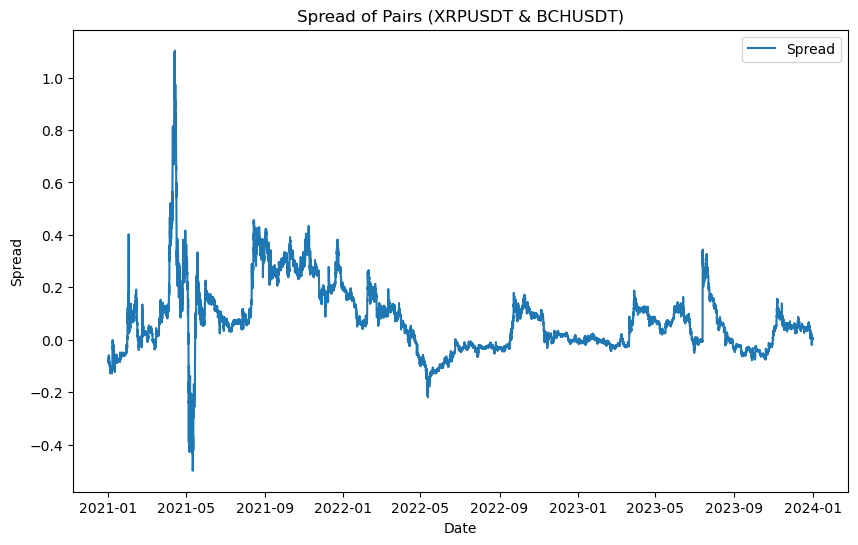

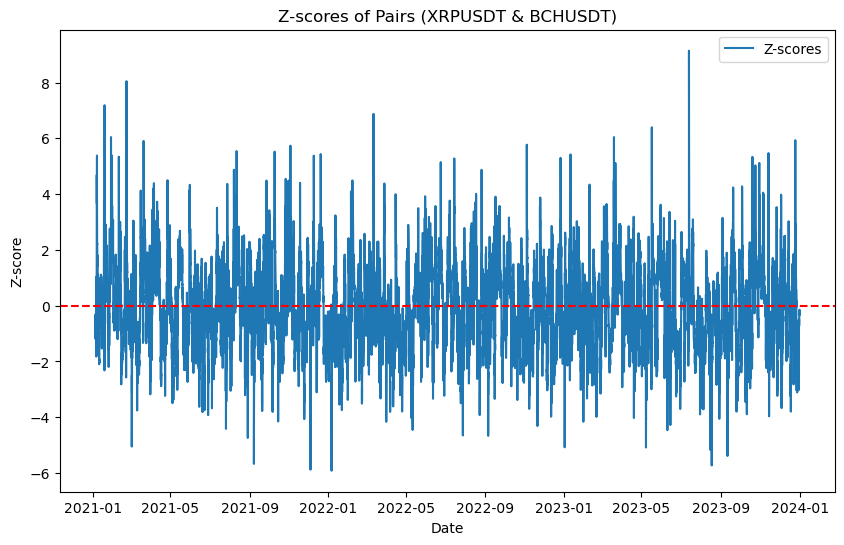

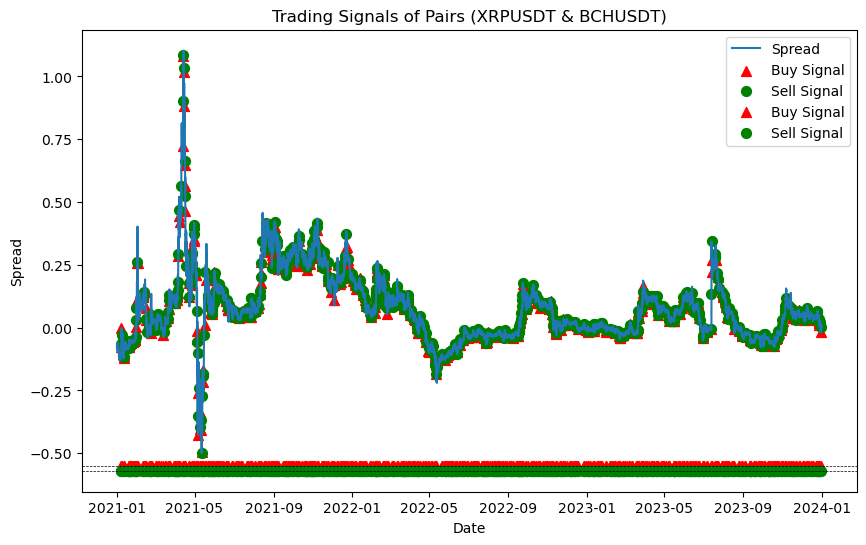

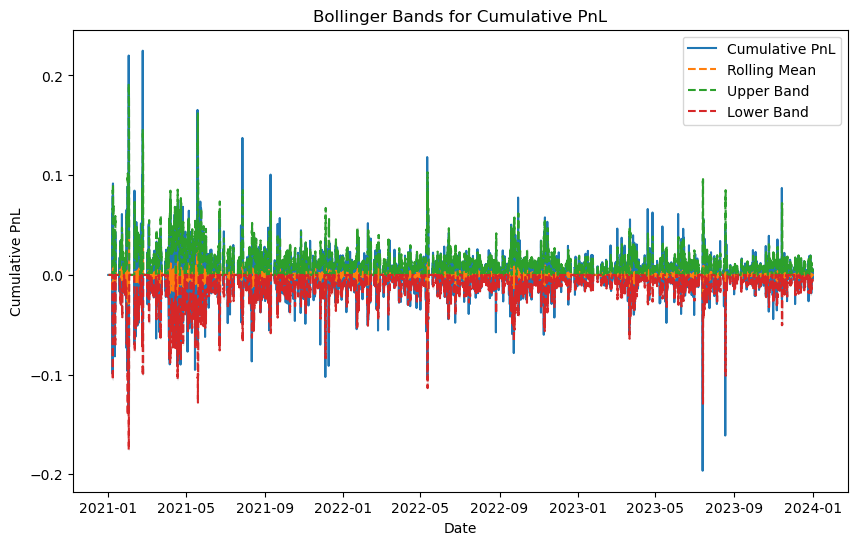

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2020-12-31 17:00:00  0.21814   342.45  0.000648   0.082809 -0.086668   
2020-12-31 18:00:00  0.21825   342.90  0.000648   0.082877 -0.086822   
2020-12-31 19:00:00  0.21910   342.39  0.000648   0.082944 -0.085614   
2020-12-31 20:00:00  0.22109   341.34  0.000647   0.083009 -0.082918   
2020-12-31 21:00:00  0.22448   342.86  0.000647   0.083073 -0.080487   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00  0.62060   261.40  0.001241   0.288718  0.007459   
2023-12-31 20:00:00  0.61830   260.50  0.001241   0.288757  0.006281   
2023-12-31 21:00:00  0.61930   261.30  0.001241   0.288796  0.006294   
2023-12-31 22:00:00  0.61140   256.00  0.001241   0.288835  0.004976   
2023-12-31 23:00:00  0.61560   259.70  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2020-12-31 17:00:00        NaN         NaN       NaN     NaN       NaN   
2020-12-31 18:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 19:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 20:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 21:00:00        NaN         NaN       NaN     NaN       0.0   
...                        ...         ...       ...     ...       ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0       0.0   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0       0.0   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0       0.0   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN       0.0   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN       0.0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2020-12-31 17:00:00       NaN       NaN         NaN         NaN        NaN   
2020-12-31 18:00:00  0.000504  0.001313         0.0        -0.0        0.0   
2020-12-31 19:00:00  0.003887 -0.001488         0.0        -0.0        0.0   
2020-12-31 20:00:00  0.009042 -0.003071         0.0        -0.0        0.0   
2020-12-31 21:00:00  0.015217  0.004443         0.0        -0.0        0.0   
...                       ...       ...         ...         ...        ...   
2023-12-31 19:00:00 -0.000805 -0.007242         0.0        -0.0        0.0   
2023-12-31 20:00:00 -0.003713 -0.003449         0.0        -0.0        0.0   
2023-12-31 21:00:00  0.001616  0.003066         0.0        -0.0        0.0   
2023-12-31 22:00:00 -0.012838 -0.020492         0.0        -0.0        0.0   
2023-12-31 23:00:00  0.006846  0.014350         0.0        -0.0        0.0   

Assets                 cumpnl  max_cumpnl  stop_loss_signal  
Date                                                         
2020-12-31 17:00:00       NaN         NaN               NaN  
2020-12-31 18:00:00  0.000000    0.000000               NaN  
2020-12-31 19:00:00  0.000000    0.000000               NaN  
2020-12-31 20:00:00  0.000000    0.000000               NaN  
2020-12-31 21:00:00  0.000000    0.000000               NaN  
...                       ...         ...               ...  
2023-12-31 19:00:00  1.629239    1.659833               NaN  
2023-12-31 20:00:00  1.629239    1.659833               NaN  
2023-12-31 21:00:00  1.629239    1.659833               NaN  
2023-12-31 22:00:00  1.629239    1.659833               NaN  
2023-12-31 23:00:00  1.629239    1.659833               NaN  

[26273 rows x 18 columns]

In [100]:
stoploss2_pairs1_train_2123 = \
   bollinger_band_stop_loss(pairs1_train_2123, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
stoploss2_pairs1_train_2123

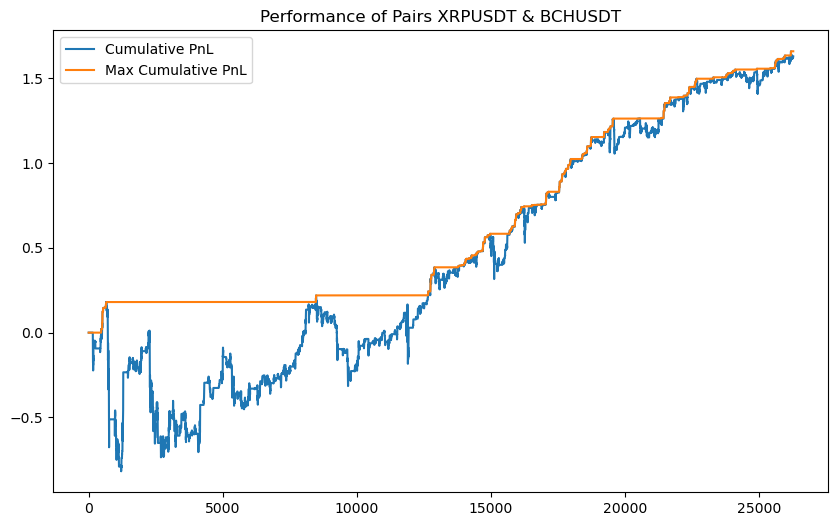

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021-2023  Strategy 2      0.684103                   37.506237   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          162.92392        -99.834676  -51 days +12:00:00

In [101]:
pairs1_train_2123_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_train_2123['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2021-2023','Strategy 2')

pairs1_train_2123_stoploss2_performance

In [102]:
def compare_stop_loss_strategies(original_data, boll_data, label,name):
    plt.figure(figsize=(10, 6))
    plt.plot(original_data.index, original_data[label], label='Original Strategy')
    plt.plot(boll_data.index, boll_data[label], label='Bollinger Band Stop Loss Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Comparison Chart of Cumulative Returns for Stop Loss Strategies in {name}')
    plt.legend()
    plt.show()

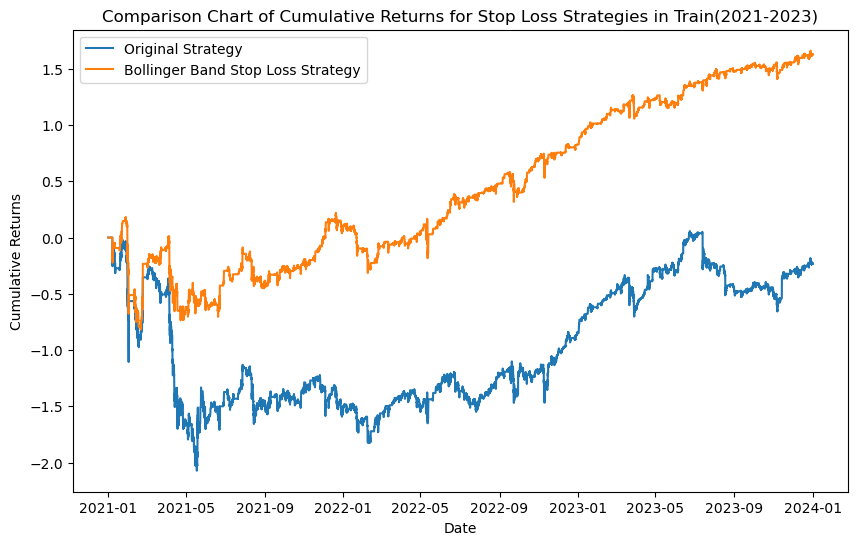

In [103]:
compare_stop_loss_strategies(pairs1_train_2123, stoploss2_pairs1_train_2123, 'cumpnl', 'Train(2021-2023)')

### 4.3.2.2 Stop-Loss Strategy 2 - Train Data (2022-2023)

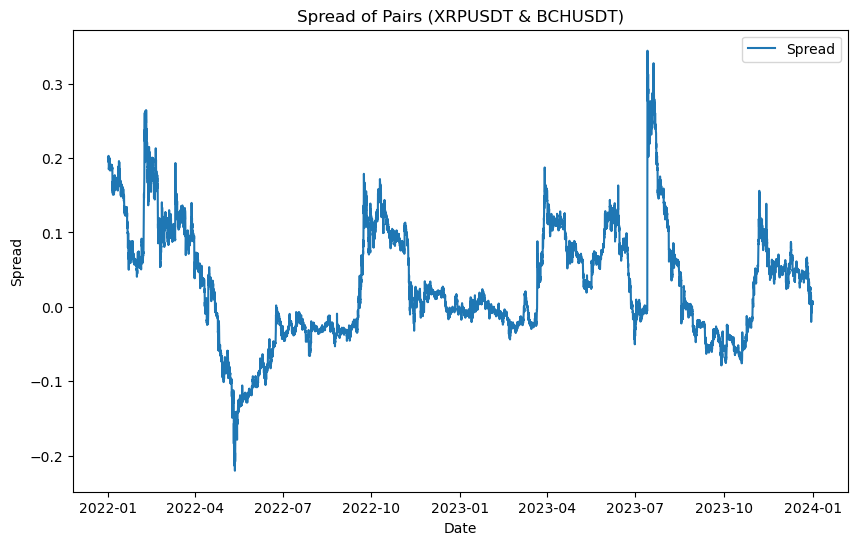

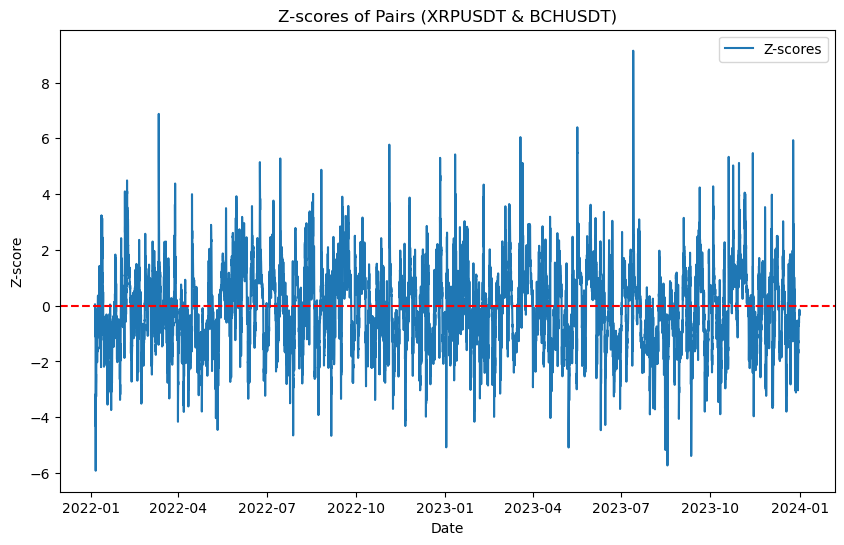

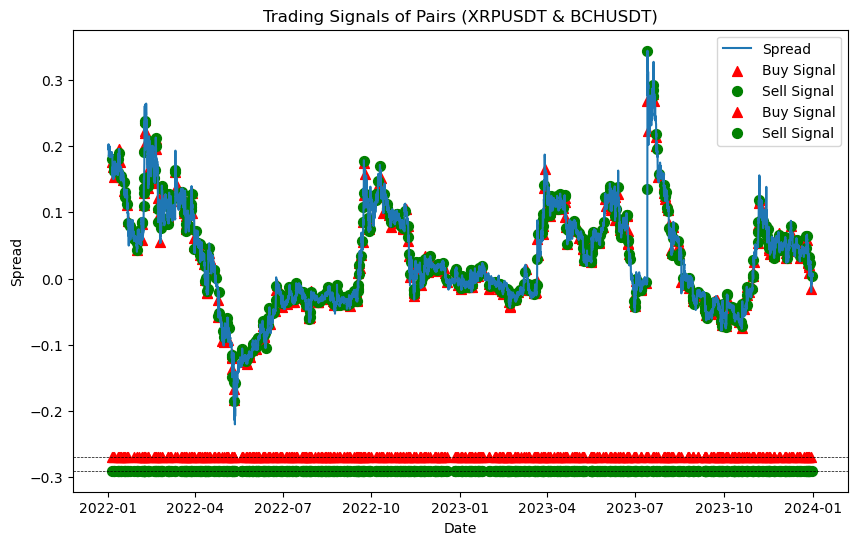

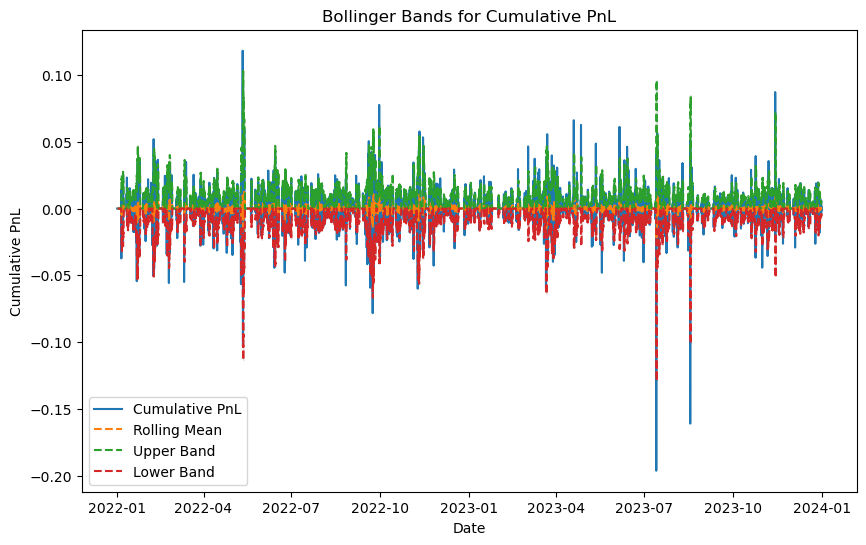

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-01-01 12:00:00   0.8425    438.5  0.001344   0.053213  0.199841   
2022-01-01 13:00:00   0.8409    437.2  0.001344   0.053485  0.199873   
2022-01-01 14:00:00   0.8399    440.1  0.001344   0.053755  0.194861   
2022-01-01 15:00:00   0.8425    441.4  0.001343   0.054026  0.195600   
2022-01-01 16:00:00   0.8448    442.7  0.001343   0.054293  0.196041   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00   0.6206    261.4  0.001241   0.288718  0.007459   
2023-12-31 20:00:00   0.6183    260.5  0.001241   0.288757  0.006281   
2023-12-31 21:00:00   0.6193    261.3  0.001241   0.288796  0.006294   
2023-12-31 22:00:00   0.6114    256.0  0.001241   0.288835  0.004976   
2023-12-31 23:00:00   0.6156    259.7  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2022-01-01 12:00:00        NaN         NaN       NaN     NaN       NaN   
2022-01-01 13:00:00        NaN         NaN       NaN     NaN       0.0   
2022-01-01 14:00:00        NaN         NaN       NaN     NaN       0.0   
2022-01-01 15:00:00        NaN         NaN       NaN     NaN       0.0   
2022-01-01 16:00:00        NaN         NaN       NaN     NaN       0.0   
...                        ...         ...       ...     ...       ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0       0.0   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0       0.0   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0       0.0   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN       0.0   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN       0.0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2022-01-01 12:00:00       NaN       NaN         NaN         NaN        NaN   
2022-01-01 13:00:00 -0.001901 -0.002969         0.0        -0.0        0.0   
2022-01-01 14:00:00 -0.001190  0.006611         0.0        -0.0       -0.0   
2022-01-01 15:00:00  0.003091  0.002950         0.0        -0.0        0.0   
2022-01-01 16:00:00  0.002726  0.002941         0.0        -0.0        0.0   
...                       ...       ...         ...         ...        ...   
2023-12-31 19:00:00 -0.000805 -0.007242         0.0        -0.0        0.0   
2023-12-31 20:00:00 -0.003713 -0.003449         0.0        -0.0        0.0   
2023-12-31 21:00:00  0.001616  0.003066         0.0        -0.0        0.0   
2023-12-31 22:00:00 -0.012838 -0.020492         0.0        -0.0        0.0   
2023-12-31 23:00:00  0.006846  0.014350         0.0        -0.0        0.0   

Assets                 cumpnl  max_cumpnl  stop_loss_signal  
Date                                                         
2022-01-01 12:00:00       NaN         NaN               NaN  
2022-01-01 13:00:00  0.000000    0.000000               NaN  
2022-01-01 14:00:00  0.000000    0.000000               NaN  
2022-01-01 15:00:00  0.000000    0.000000               NaN  
2022-01-01 16:00:00  0.000000    0.000000               NaN  
...                       ...         ...               ...  
2023-12-31 19:00:00  1.509078    1.539672               NaN  
2023-12-31 20:00:00  1.509078    1.539672               NaN  
2023-12-31 21:00:00  1.509078    1.539672               NaN  
2023-12-31 22:00:00  1.509078    1.539672               NaN  
2023-12-31 23:00:00  1.509078    1.539672               NaN  

[17507 rows x 18 columns]

In [104]:
stoploss2_pairs1_train_2223 = \
   bollinger_band_stop_loss(pairs1_train_2223, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
stoploss2_pairs1_train_2223

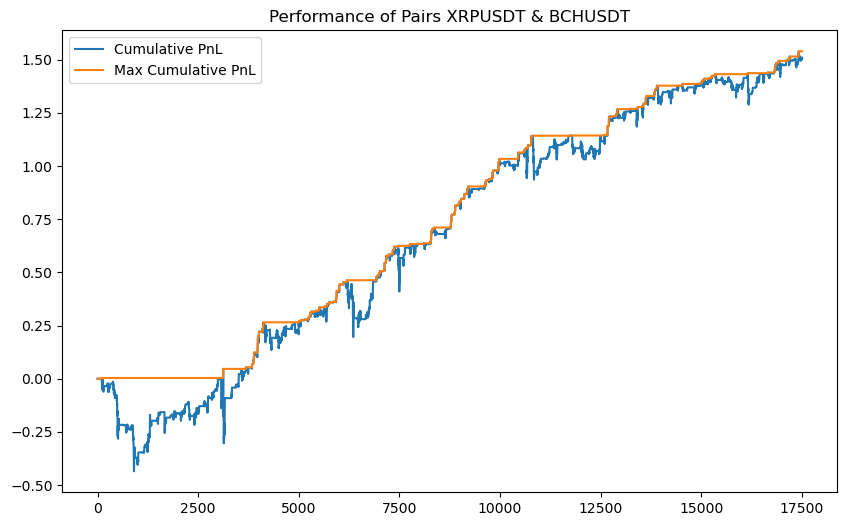

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022-2023  Strategy 2      1.352549                   52.135847   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         150.907761        -43.863347  -38 days +08:00:00

In [105]:
pairs1_train_2223_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_train_2223['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2022-2023','Strategy 2')

pairs1_train_2223_stoploss2_performance

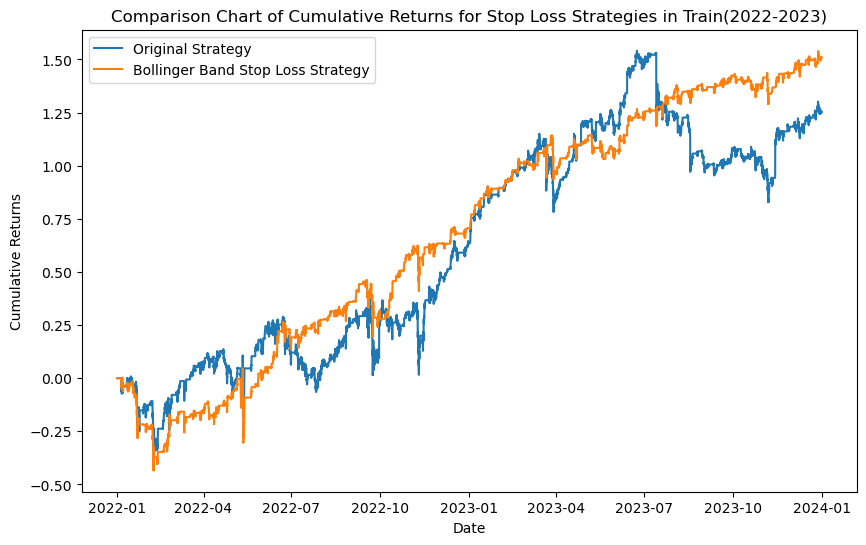

In [106]:
compare_stop_loss_strategies(pairs1_train_2223, stoploss2_pairs1_train_2223, 'cumpnl', 'Train(2022-2023)')

### 4.3 Devide Train Data (Single Year)

In [107]:
pairs1_train_21 = pairs_1.loc['2020-01-01':'2021-12-31']
pairs1_train_22 = pairs_1.loc['2021-01-01':'2022-12-31']
pairs1_train_23 = pairs_1.loc['2022-01-01':'2023-12-31']

### 4.3.1 Train Data (Year 2021)

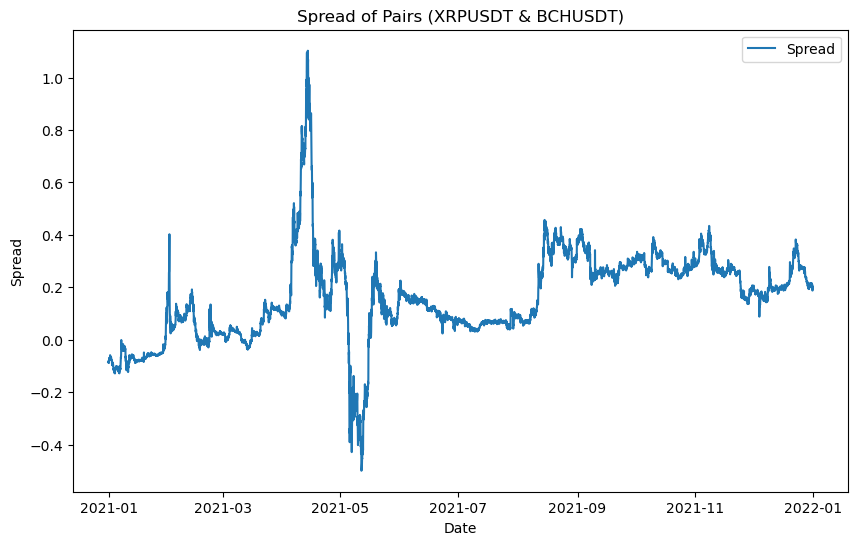

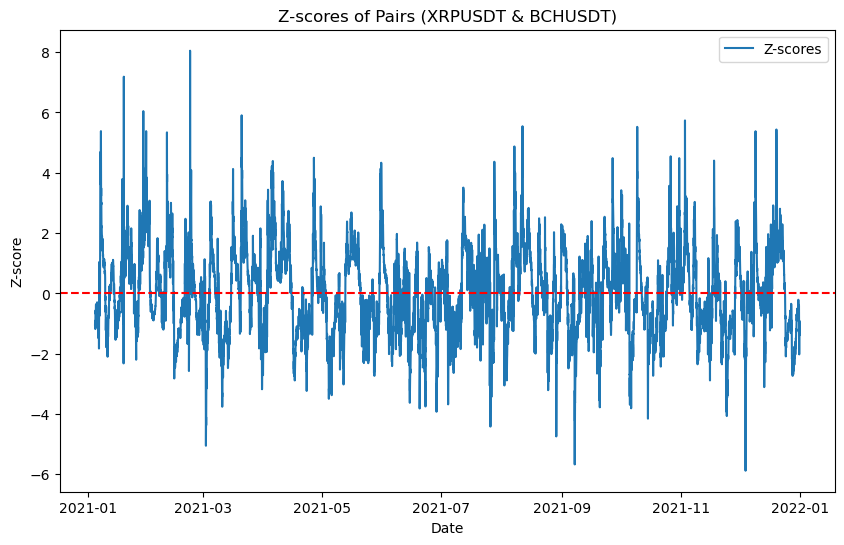

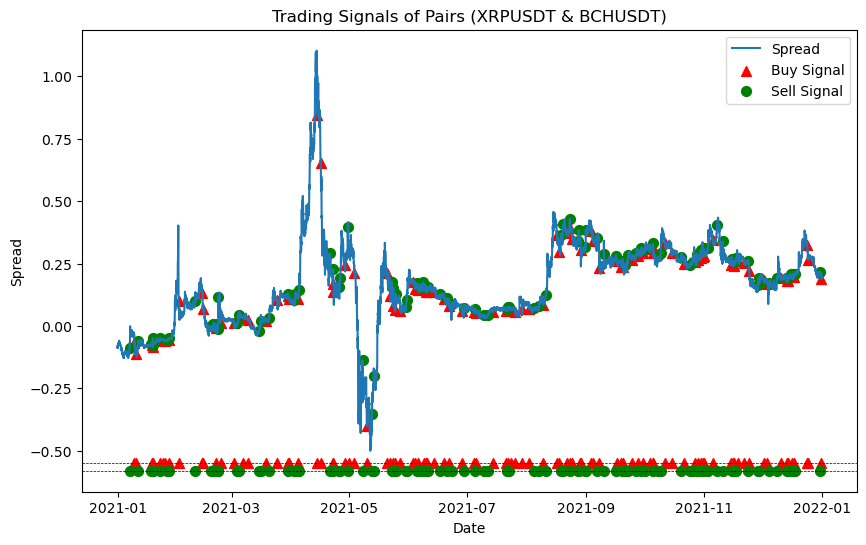

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2020-12-31 17:00:00  0.21814   342.45  0.000648   0.082809 -0.086668   
2020-12-31 18:00:00  0.21825   342.90  0.000648   0.082877 -0.086822   
2020-12-31 19:00:00  0.21910   342.39  0.000648   0.082944 -0.085614   
2020-12-31 20:00:00  0.22109   341.34  0.000647   0.083009 -0.082918   
2020-12-31 21:00:00  0.22448   342.86  0.000647   0.083073 -0.080487   
...                      ...      ...       ...        ...       ...   
2021-12-31 19:00:00  0.80340   420.20  0.001350   0.048521  0.187443   
2021-12-31 20:00:00  0.81320   420.50  0.001350   0.048802  0.196712   
2021-12-31 21:00:00  0.82820   428.10  0.001350   0.049083  0.201329   
2021-12-31 22:00:00  0.82480   430.10  0.001349   0.049360  0.195109   
2021-12-31 23:00:00  0.82970   430.20  0.001349   0.049635  0.199753   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2020-12-31 17:00:00        NaN         NaN       NaN     NaN         0   
2020-12-31 18:00:00        NaN         NaN       NaN     NaN         0   
2020-12-31 19:00:00        NaN         NaN       NaN     NaN         0   
2020-12-31 20:00:00        NaN         NaN       NaN     NaN         0   
2020-12-31 21:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2021-12-31 19:00:00   0.213440    0.012853 -2.022594     1.0         1   
2021-12-31 20:00:00   0.212930    0.012591 -1.288108     NaN         1   
2021-12-31 21:00:00   0.212492    0.012295 -0.907967     NaN         1   
2021-12-31 22:00:00   0.212032    0.012159 -1.391834     NaN         1   
2021-12-31 23:00:00   0.211614    0.011923 -0.994756     NaN         1   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2020-12-31 17:00:00       NaN       NaN         NaN         NaN        NaN   
2020-12-31 18:00:00  0.000504  0.001313         0.0   -0.000000   0.000000   
2020-12-31 19:00:00  0.003887 -0.001488         0.0   -0.000000   0.000000   
2020-12-31 20:00:00  0.009042 -0.003071         0.0   -0.000000   0.000000   
2020-12-31 21:00:00  0.015217  0.004443         0.0   -0.000000   0.000000   
...                       ...       ...         ...         ...        ...   
2021-12-31 19:00:00 -0.024589 -0.023287         0.0   -0.000000   0.000000   
2021-12-31 20:00:00  0.012124  0.000714         1.0   -0.001350   0.012123   
2021-12-31 21:00:00  0.018278  0.017912         1.0   -0.001350   0.018253   
2021-12-31 22:00:00 -0.004114  0.004661         1.0   -0.001350  -0.004120   
2021-12-31 23:00:00  0.005923  0.000232         1.0   -0.001349   0.005923   

Assets                 cumpnl  max_cumpnl  
Date                                       
2020-12-31 17:00:00       NaN         NaN  
2020-12-31 18:00:00  0.000000         0.0  
2020-12-31 19:00:00  0.000000         0.0  
2020-12-31 20:00:00  0.000000         0.0  
2020-12-31 21:00:00  0.000000         0.0  
...                       ...         ...  
2021-12-31 19:00:00 -1.550267         0.0  
2021-12-31 20:00:00 -1.538144         0.0  
2021-12-31 21:00:00 -1.519890         0.0  
2021-12-31 22:00:00 -1.524010         0.0  
2021-12-31 23:00:00 -1.518087         0.0  

[8754 rows x 17 columns]

In [108]:
pairs1_train_21 = \
   pairs_trading_strategy(pairs1_train_21,'XRPUSDT','BCHUSDT',
                          z_signal_in, z_signal_out, min_spread, MA_window, OLS_window
                         )
pairs1_train_21

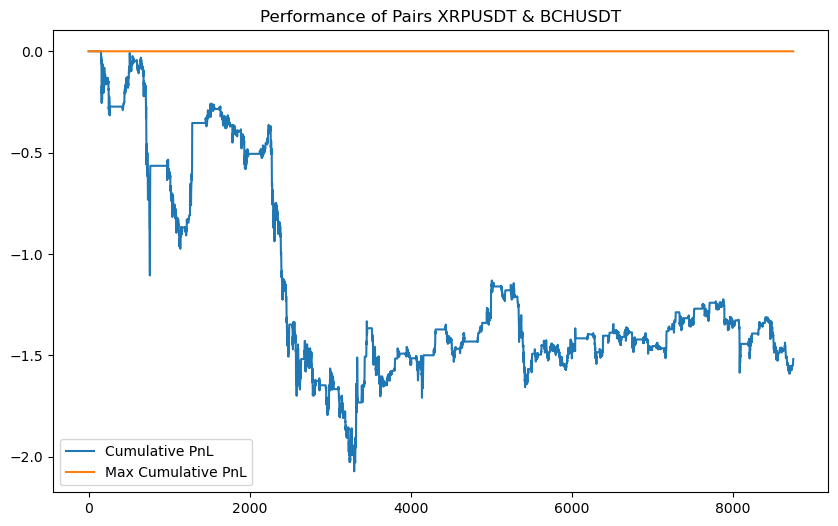

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021        No     -1.017756                 -104.894237   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         -151.80874       -207.200261 -138 days +07:00:00

In [109]:
pairs1_train_21_performance = \
   pnlPerformance(pairs1_train_21['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2021','No')
pairs1_train_21_performance

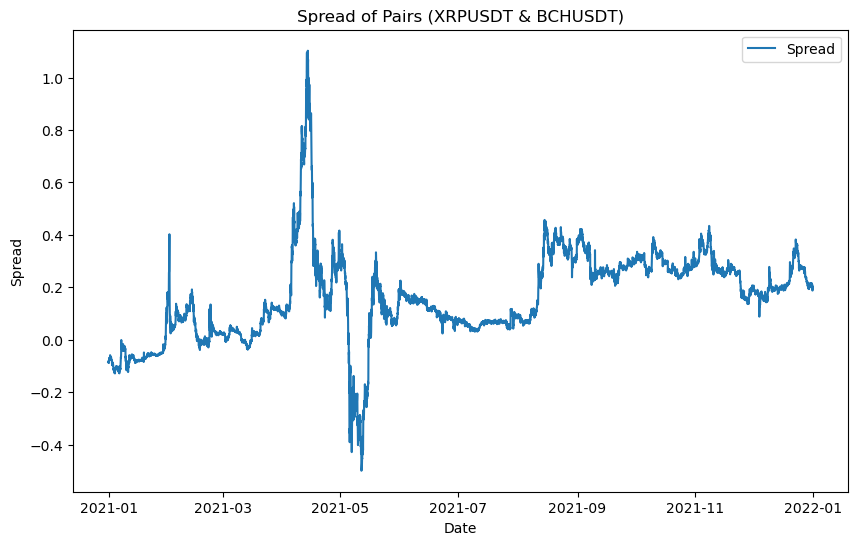

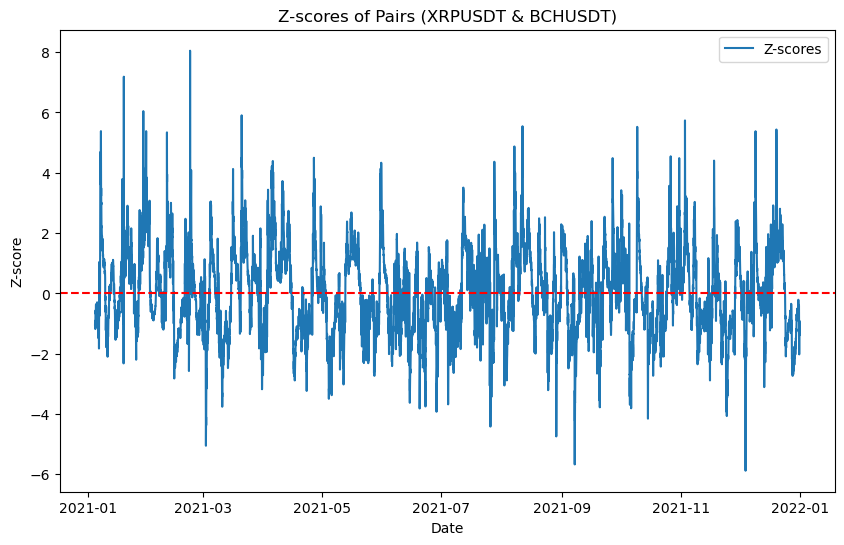

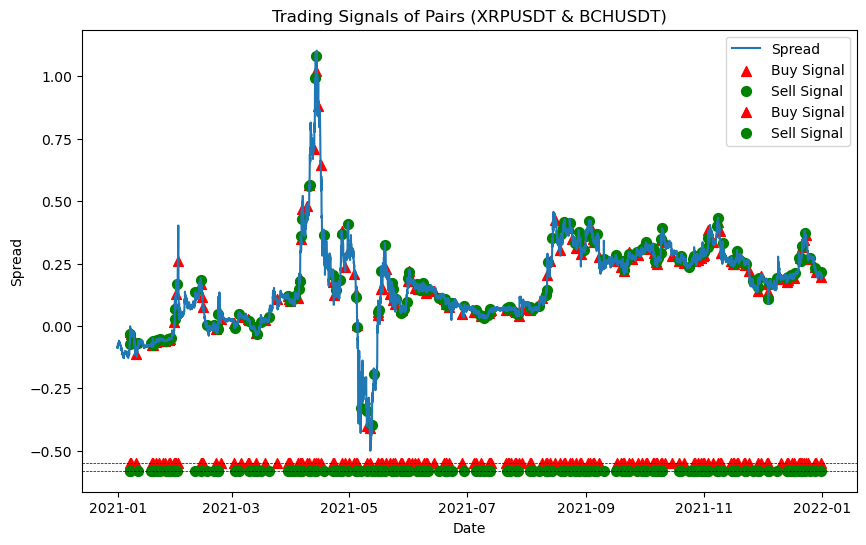

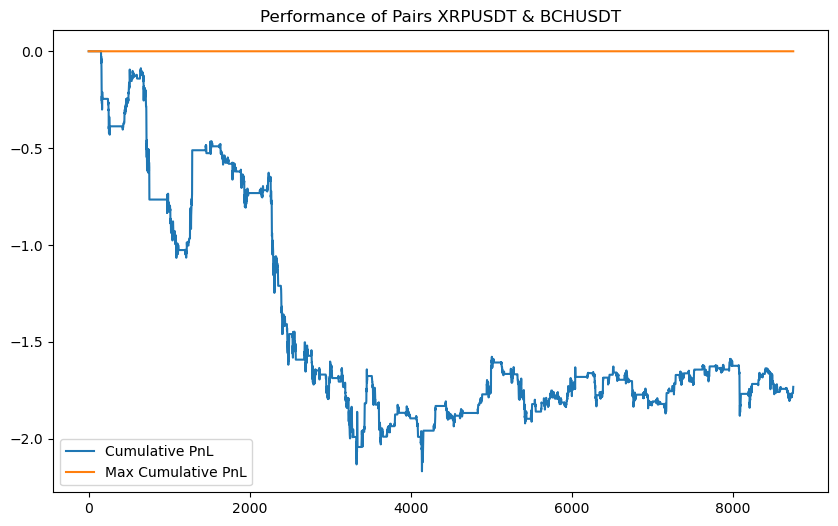

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021  Strategy1     -1.373676                 -119.694748   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train        -173.228858       -216.807407 -173 days +05:00:00

In [110]:
stoploss1_pairs1_train_21 = stop_loss_strategy1(pairs1_train_21, 'XRPUSDT','BCHUSDT',num_consecutive_losses=4)
pairs1_train_21_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_train_21['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2021','Strategy1')
pairs1_train_21_stoploss1_performance

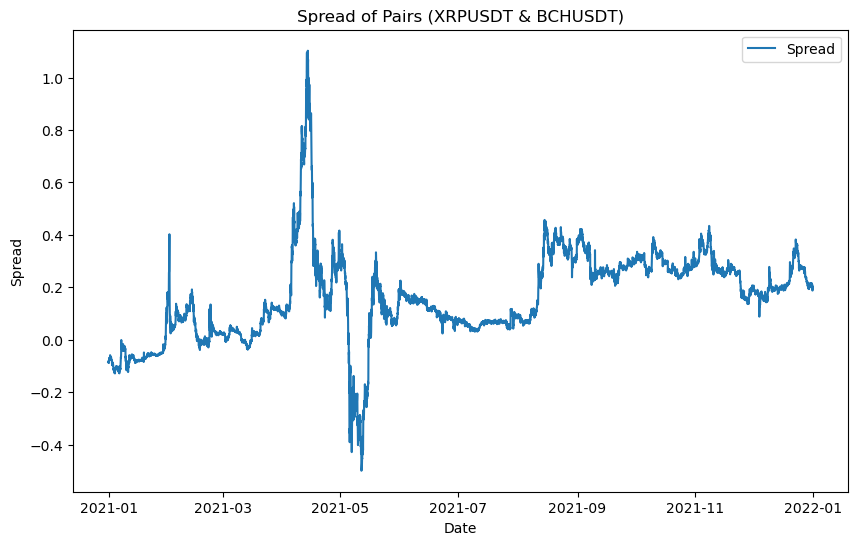

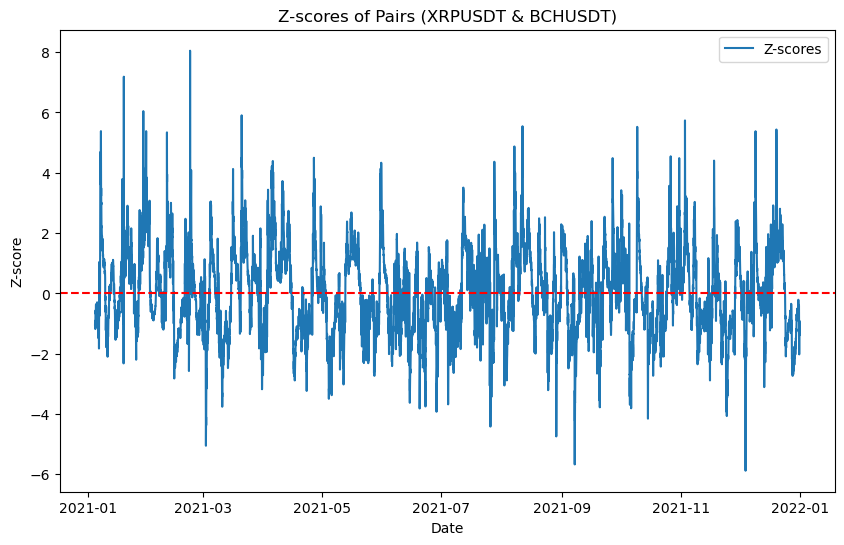

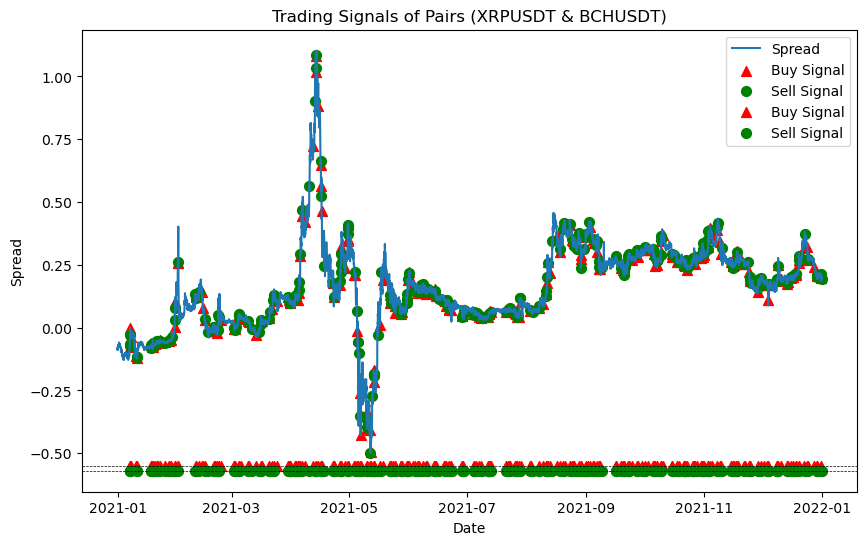

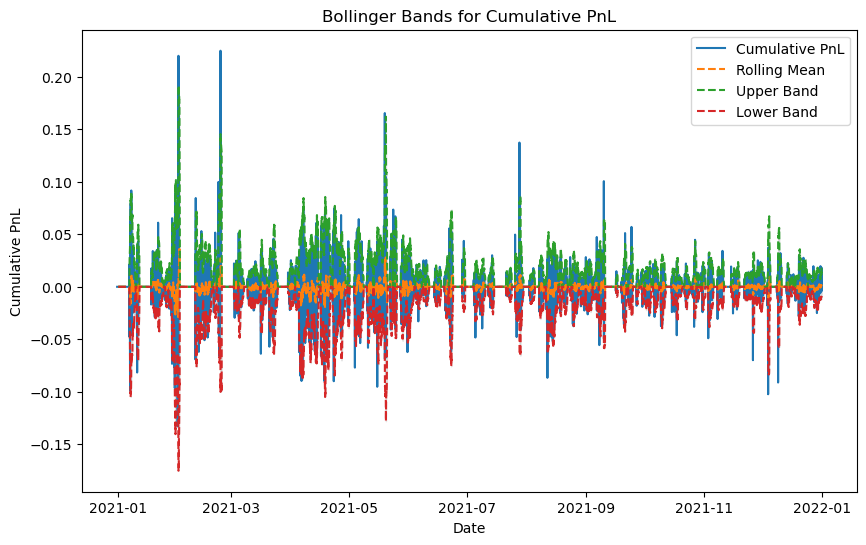

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2020-12-31 17:00:00  0.21814   342.45  0.000648   0.082809 -0.086668   
2020-12-31 18:00:00  0.21825   342.90  0.000648   0.082877 -0.086822   
2020-12-31 19:00:00  0.21910   342.39  0.000648   0.082944 -0.085614   
2020-12-31 20:00:00  0.22109   341.34  0.000647   0.083009 -0.082918   
2020-12-31 21:00:00  0.22448   342.86  0.000647   0.083073 -0.080487   
...                      ...      ...       ...        ...       ...   
2021-12-31 19:00:00  0.80340   420.20  0.001350   0.048521  0.187443   
2021-12-31 20:00:00  0.81320   420.50  0.001350   0.048802  0.196712   
2021-12-31 21:00:00  0.82820   428.10  0.001350   0.049083  0.201329   
2021-12-31 22:00:00  0.82480   430.10  0.001349   0.049360  0.195109   
2021-12-31 23:00:00  0.82970   430.20  0.001349   0.049635  0.199753   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2020-12-31 17:00:00        NaN         NaN       NaN     NaN       NaN   
2020-12-31 18:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 19:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 20:00:00        NaN         NaN       NaN     NaN       0.0   
2020-12-31 21:00:00        NaN         NaN       NaN     NaN       0.0   
...                        ...         ...       ...     ...       ...   
2021-12-31 19:00:00   0.213440    0.012853 -2.022594     1.0       0.0   
2021-12-31 20:00:00   0.212930    0.012591 -1.288108     NaN       1.0   
2021-12-31 21:00:00   0.212492    0.012295 -0.907967     0.0       1.0   
2021-12-31 22:00:00   0.212032    0.012159 -1.391834     NaN       0.0   
2021-12-31 23:00:00   0.211614    0.011923 -0.994756     NaN       0.0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2020-12-31 17:00:00       NaN       NaN         NaN         NaN        NaN   
2020-12-31 18:00:00  0.000504  0.001313         0.0    -0.00000   0.000000   
2020-12-31 19:00:00  0.003887 -0.001488         0.0    -0.00000   0.000000   
2020-12-31 20:00:00  0.009042 -0.003071         0.0    -0.00000   0.000000   
2020-12-31 21:00:00  0.015217  0.004443         0.0    -0.00000   0.000000   
...                       ...       ...         ...         ...        ...   
2021-12-31 19:00:00 -0.024589 -0.023287         0.0    -0.00000   0.000000   
2021-12-31 20:00:00  0.012124  0.000714         1.0    -0.00135   0.012123   
2021-12-31 21:00:00  0.018278  0.017912         1.0    -0.00135   0.018253   
2021-12-31 22:00:00 -0.004114  0.004661         0.0    -0.00000  -0.000000   
2021-12-31 23:00:00  0.005923  0.000232         0.0    -0.00000   0.000000   

Assets                 cumpnl  max_cumpnl  stop_loss_signal  
Date                                                         
2020-12-31 17:00:00       NaN         NaN               NaN  
2020-12-31 18:00:00  0.000000    0.000000               NaN  
2020-12-31 19:00:00  0.000000    0.000000               NaN  
2020-12-31 20:00:00  0.000000    0.000000               NaN  
2020-12-31 21:00:00  0.000000    0.000000               NaN  
...                       ...         ...               ...  
2021-12-31 19:00:00  0.078503    0.219637               NaN  
2021-12-31 20:00:00  0.090626    0.219637               NaN  
2021-12-31 21:00:00  0.108879    0.219637               0.0  
2021-12-31 22:00:00  0.108879    0.219637               NaN  
2021-12-31 23:00:00  0.108879    0.219637               NaN  

[8754 rows x 18 columns]

In [111]:
stoploss2_pairs1_train_21 = \
   bollinger_band_stop_loss(pairs1_train_21, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
stoploss2_pairs1_train_21

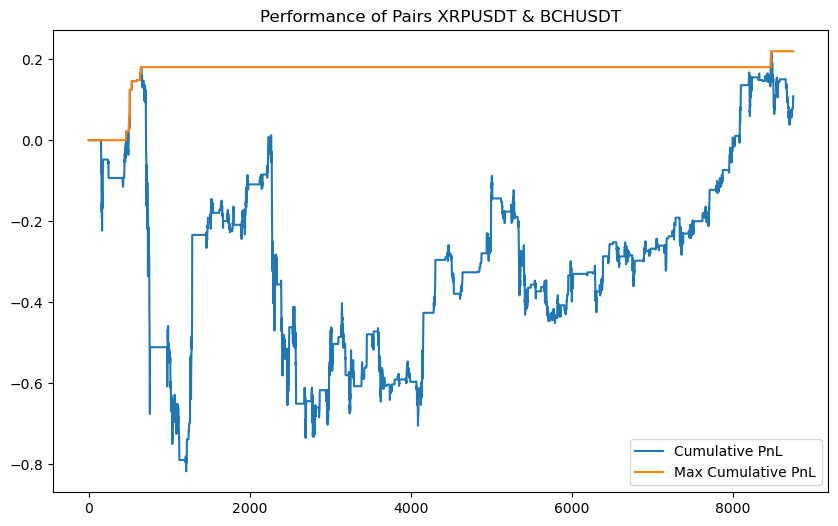

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021  Strategy2      0.096735                    7.523169   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          10.887946        -99.834676  -51 days +12:00:00

In [112]:
pairs1_train_21_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_train_21['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2021','Strategy2')
pairs1_train_21_stoploss2_performance

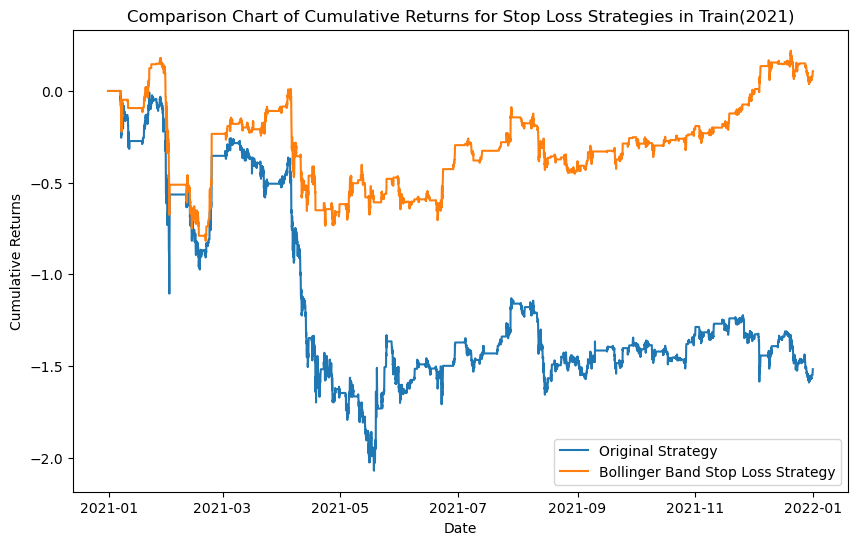

In [113]:
compare_stop_loss_strategies(pairs1_train_21, stoploss2_pairs1_train_21, 'cumpnl', 'Train(2021)')

### 4.3.2 Train Data (Year 2022)

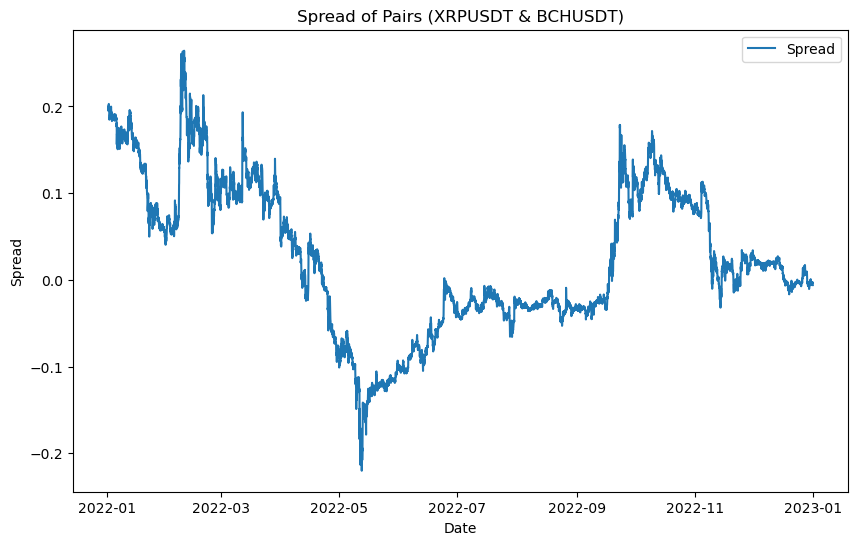

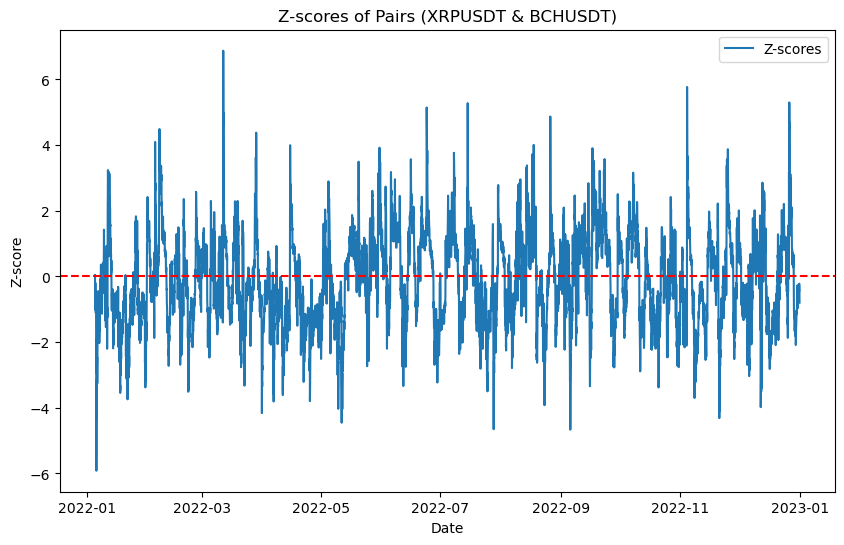

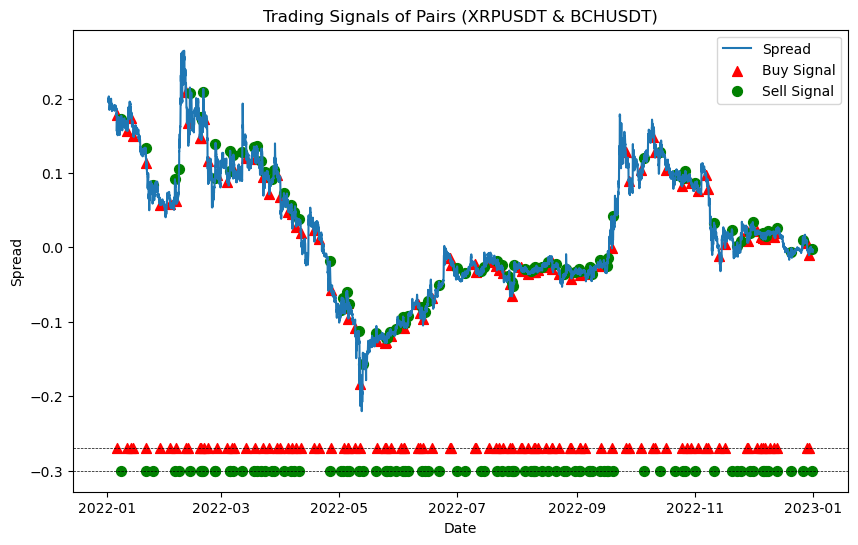

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-01-01 12:00:00   0.8425    438.5  0.001344   0.053213  0.199841   
2022-01-01 13:00:00   0.8409    437.2  0.001344   0.053485  0.199873   
2022-01-01 14:00:00   0.8399    440.1  0.001344   0.053755  0.194861   
2022-01-01 15:00:00   0.8425    441.4  0.001343   0.054026  0.195600   
2022-01-01 16:00:00   0.8448    442.7  0.001343   0.054293  0.196041   
...                      ...      ...       ...        ...       ...   
2022-12-31 19:00:00   0.3427     97.2  0.001660   0.183983 -0.002589   
2022-12-31 20:00:00   0.3429     97.6  0.001660   0.183957 -0.003043   
2022-12-31 21:00:00   0.3420     97.2  0.001660   0.183930 -0.003269   
2022-12-31 22:00:00   0.3407     97.1  0.001660   0.183900 -0.004392   
2022-12-31 23:00:00   0.3389     97.0  0.001660   0.183872 -0.006015   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2022-01-01 12:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 13:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 14:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 15:00:00        NaN         NaN       NaN     NaN         0   
2022-01-01 16:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2022-12-31 19:00:00  -0.001375    0.005496 -0.220870     0.0         0   
2022-12-31 20:00:00  -0.001509    0.005385 -0.284798     NaN         0   
2022-12-31 21:00:00  -0.001620    0.005317 -0.310191     NaN         0   
2022-12-31 22:00:00  -0.001770    0.005200 -0.504223     NaN         0   
2022-12-31 23:00:00  -0.001899    0.005158 -0.797803     NaN         0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2022-01-01 12:00:00       NaN       NaN         NaN         NaN        NaN   
2022-01-01 13:00:00 -0.001901 -0.002969         0.0   -0.000000   0.000000   
2022-01-01 14:00:00 -0.001190  0.006611         0.0   -0.000000  -0.000000   
2022-01-01 15:00:00  0.003091  0.002950         0.0   -0.000000   0.000000   
2022-01-01 16:00:00  0.002726  0.002941         0.0   -0.000000   0.000000   
...                       ...       ...         ...         ...        ...   
2022-12-31 19:00:00  0.003508  0.000000         1.0   -0.001659   0.003508   
2022-12-31 20:00:00  0.000583  0.004107         0.0   -0.000000   0.000000   
2022-12-31 21:00:00 -0.002628 -0.004107         0.0   -0.000000   0.000000   
2022-12-31 22:00:00 -0.003808 -0.001029         0.0   -0.000000   0.000000   
2022-12-31 23:00:00 -0.005297 -0.001030         0.0   -0.000000   0.000000   

Assets                 cumpnl  max_cumpnl  
Date                                       
2022-01-01 12:00:00       NaN         NaN  
2022-01-01 13:00:00  0.000000    0.000000  
2022-01-01 14:00:00  0.000000    0.000000  
2022-01-01 15:00:00  0.000000    0.000000  
2022-01-01 16:00:00  0.000000    0.000000  
...                       ...         ...  
2022-12-31 19:00:00  0.637024    0.645134  
2022-12-31 20:00:00  0.637024    0.645134  
2022-12-31 21:00:00  0.637024    0.645134  
2022-12-31 22:00:00  0.637024    0.645134  
2022-12-31 23:00:00  0.637024    0.645134  

[8748 rows x 17 columns]

In [114]:
pairs1_train_22 = \
   pairs_trading_strategy(pairs1_train_22,'XRPUSDT','BCHUSDT',
                          z_signal_in, z_signal_out, min_spread, MA_window, OLS_window
                         )
pairs1_train_22

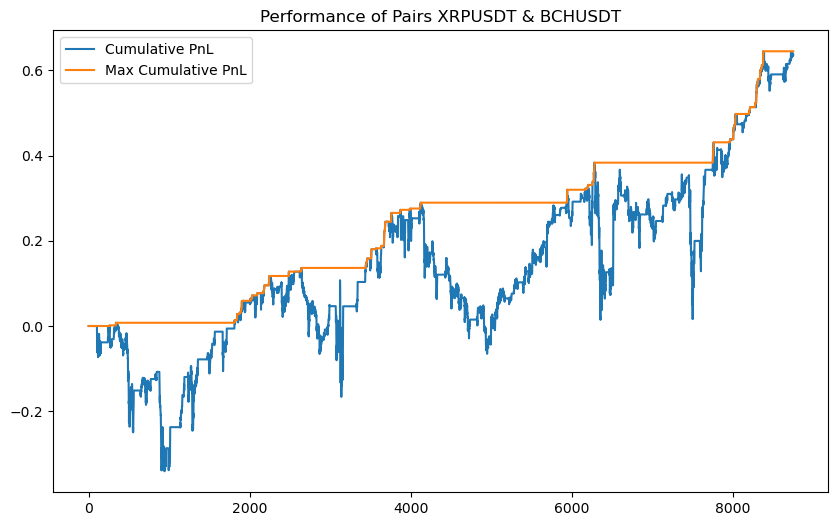

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022        No      0.756918                   44.046209   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          63.702412        -36.886213 -265 days +07:00:00

In [115]:
pairs1_train_22_performance = \
   pnlPerformance(pairs1_train_22['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Train','2022','No')
pairs1_train_22_performance

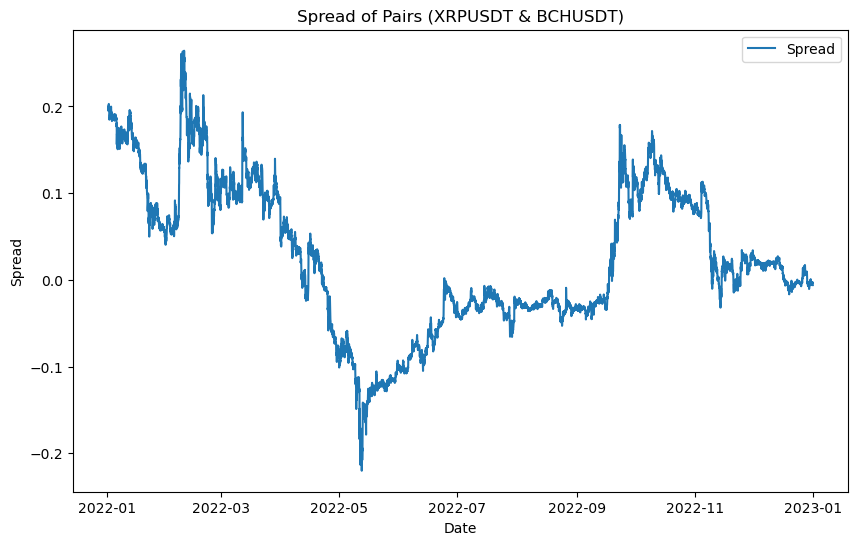

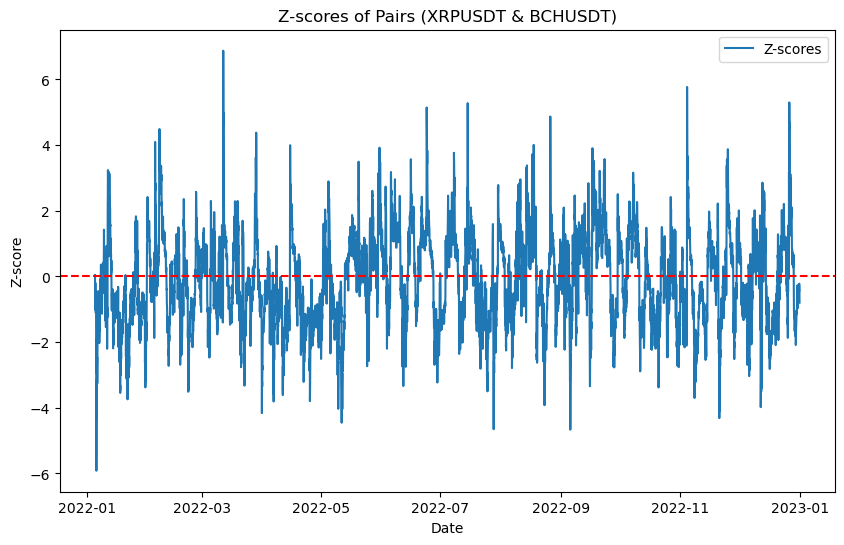

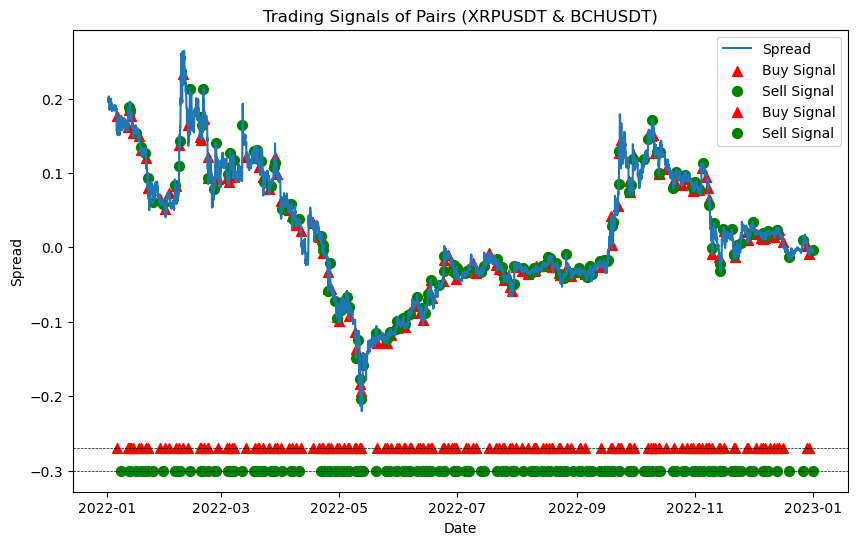

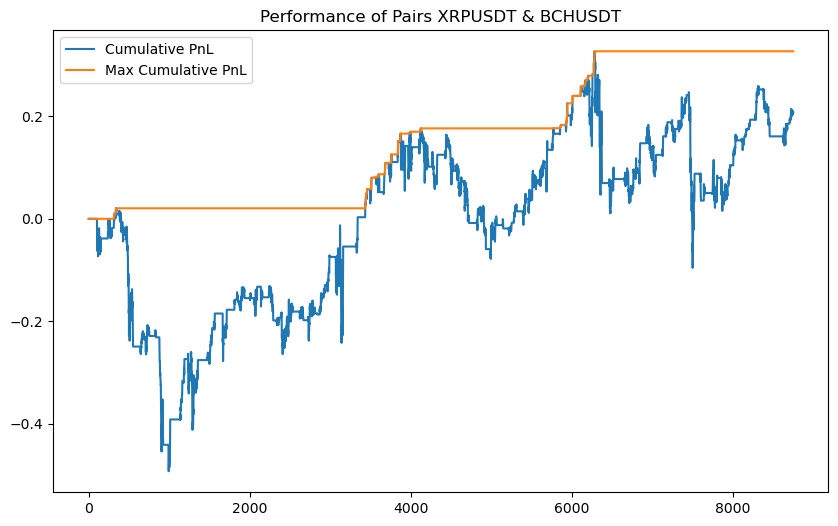

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022  Strategy1        0.2807                   14.310007   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          20.696036         -51.30478  -42 days +15:00:00

In [116]:
stoploss1_pairs1_train_22 = stop_loss_strategy1(pairs1_train_22, 'XRPUSDT','BCHUSDT',num_consecutive_losses=4)
pairs1_train_22_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_train_22['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2022','Strategy1')
pairs1_train_22_stoploss1_performance

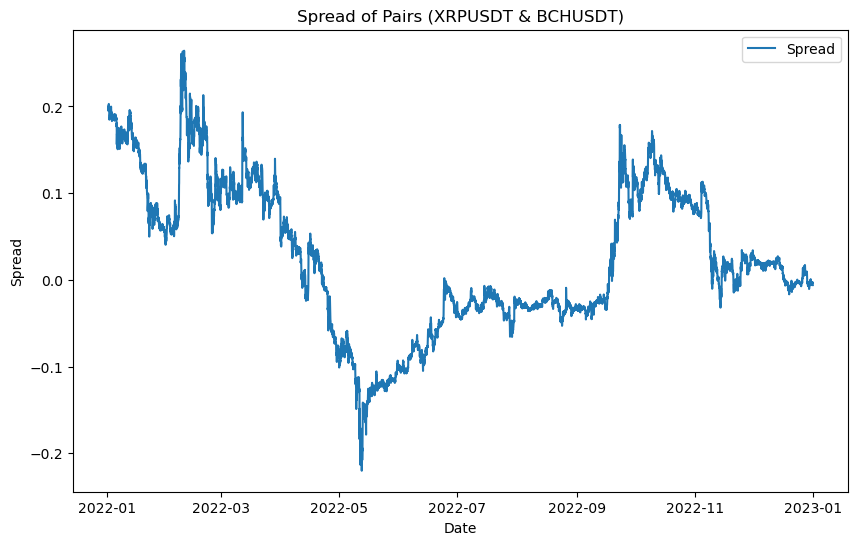

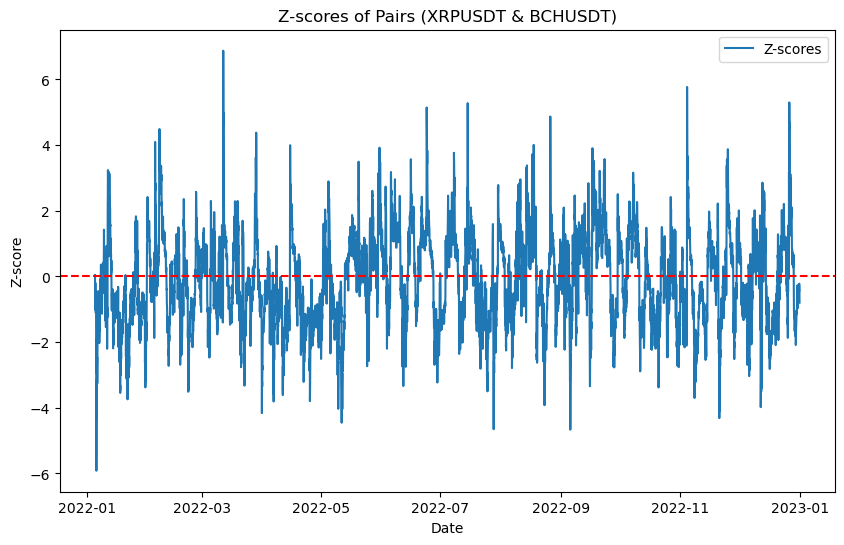

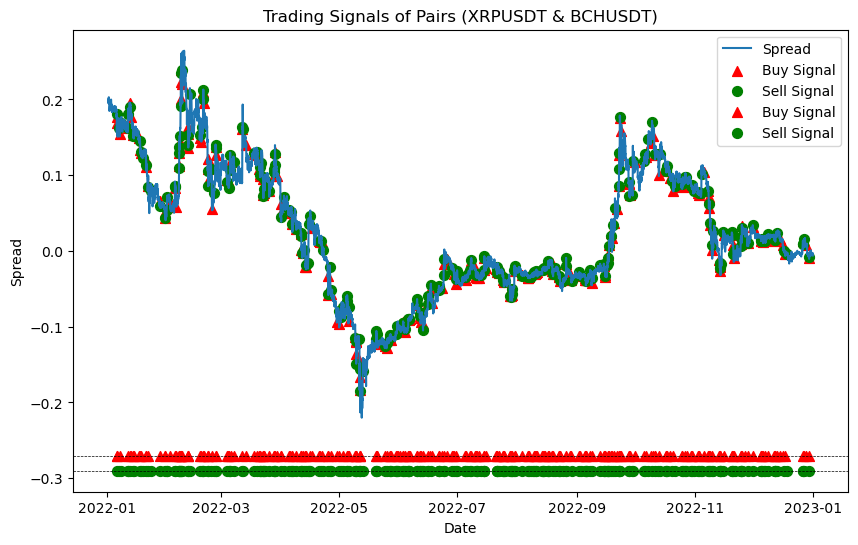

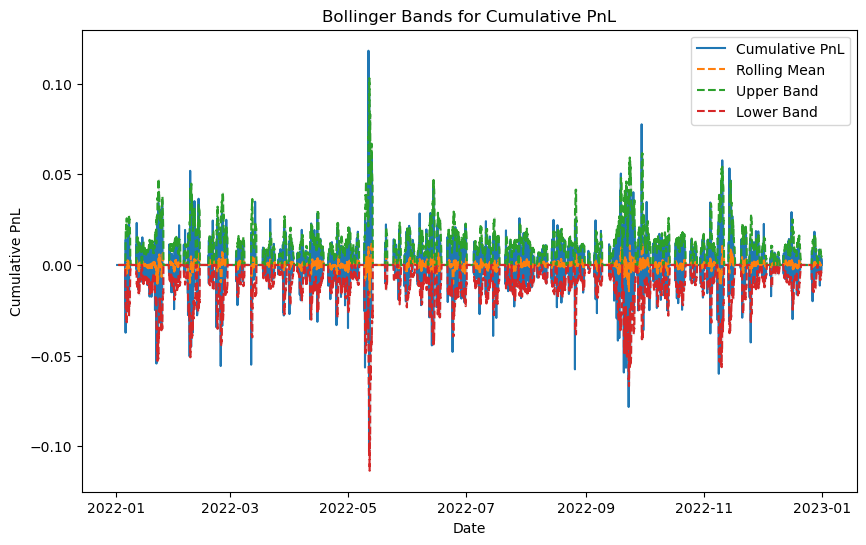

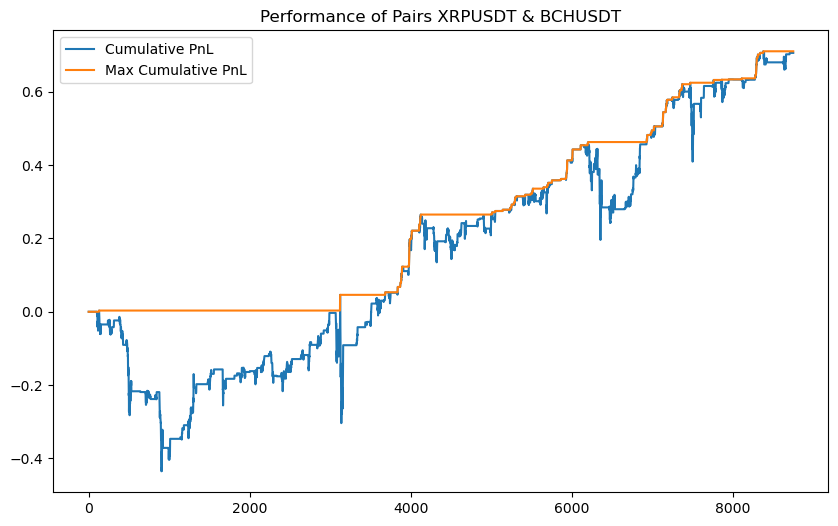

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022  Strategy2      1.100226                    48.84769   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          70.646618        -43.863347  -38 days +08:00:00

In [117]:
stoploss2_pairs1_train_22 = \
   bollinger_band_stop_loss(pairs1_train_22, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
pairs1_train_22_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_train_22['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2022','Strategy2')
pairs1_train_22_stoploss2_performance

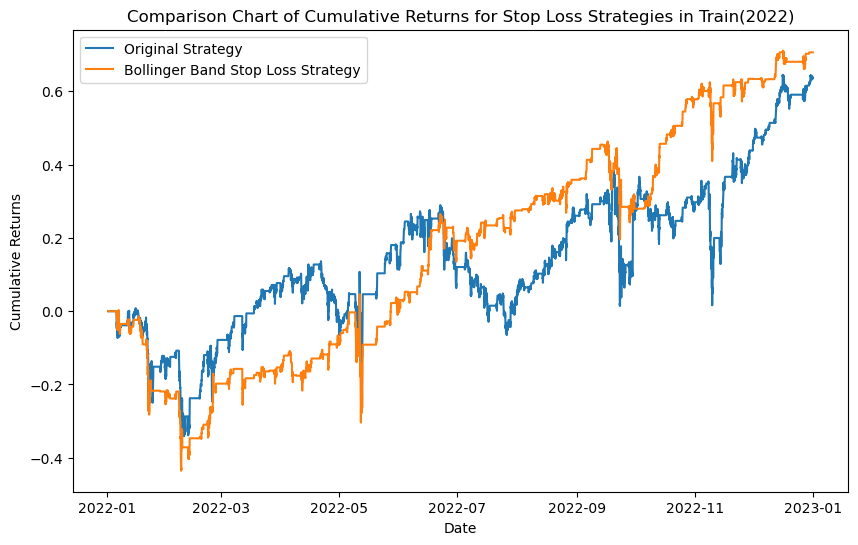

In [118]:
compare_stop_loss_strategies(pairs1_train_22, stoploss2_pairs1_train_22, 'cumpnl', 'Train(2022)')

### 4.3.3 Train Data (Year 2023)

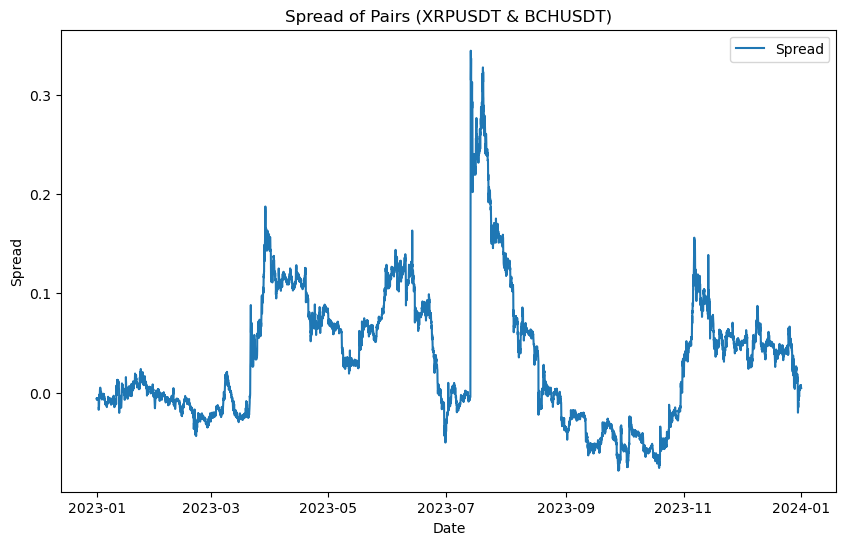

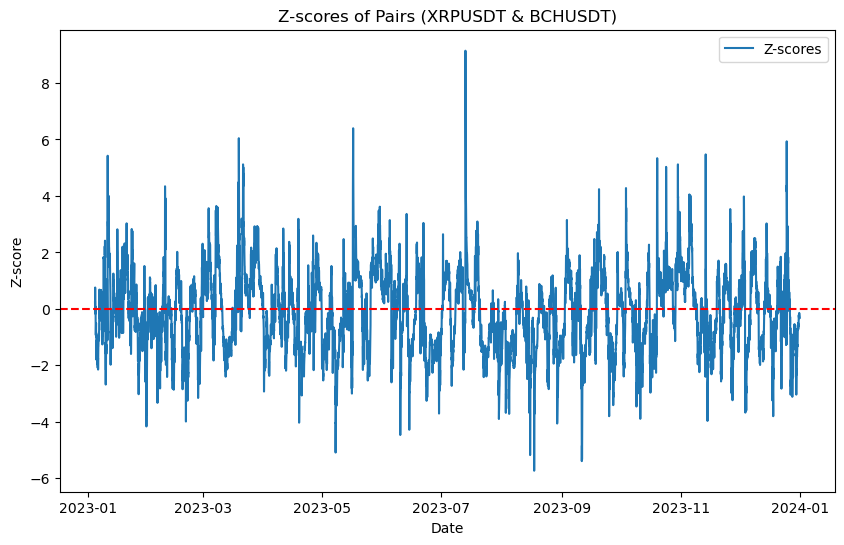

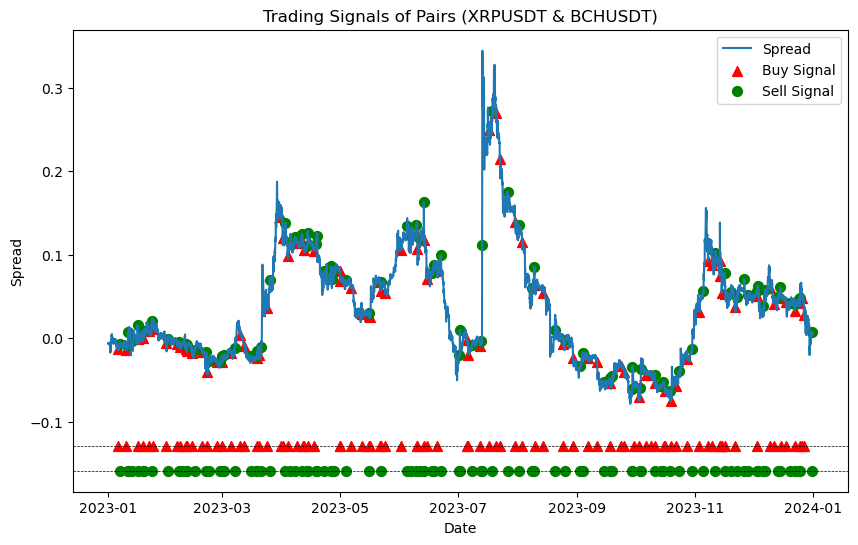

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2022-12-31 23:00:00   0.3389     97.0  0.001660   0.183872 -0.006015   
2023-01-01 00:00:00   0.3385     96.4  0.001660   0.183843 -0.005408   
2023-01-01 01:00:00   0.3387     96.5  0.001661   0.183815 -0.005362   
2023-01-01 02:00:00   0.3380     96.6  0.001661   0.183787 -0.006218   
2023-01-01 03:00:00   0.3381     96.5  0.001661   0.183759 -0.005940   
...                      ...      ...       ...        ...       ...   
2023-12-31 19:00:00   0.6206    261.4  0.001241   0.288718  0.007459   
2023-12-31 20:00:00   0.6183    260.5  0.001241   0.288757  0.006281   
2023-12-31 21:00:00   0.6193    261.3  0.001241   0.288796  0.006294   
2023-12-31 22:00:00   0.6114    256.0  0.001241   0.288835  0.004976   
2023-12-31 23:00:00   0.6156    259.7  0.001240   0.288876  0.004592   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2022-12-31 23:00:00        NaN         NaN       NaN     NaN         0   
2023-01-01 00:00:00        NaN         NaN       NaN     NaN         0   
2023-01-01 01:00:00        NaN         NaN       NaN     NaN         0   
2023-01-01 02:00:00        NaN         NaN       NaN     NaN         0   
2023-01-01 03:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2023-12-31 19:00:00   0.009135    0.011676 -0.143558     0.0         0   
2023-12-31 20:00:00   0.008829    0.011378 -0.223871     0.0         0   
2023-12-31 21:00:00   0.008610    0.011232 -0.206135     0.0         0   
2023-12-31 22:00:00   0.008319    0.010978 -0.304529     NaN         0   
2023-12-31 23:00:00   0.008137    0.010902 -0.325233     NaN         0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2022-12-31 23:00:00       NaN       NaN         NaN         NaN        NaN   
2023-01-01 00:00:00 -0.001181 -0.006205         0.0        -0.0        0.0   
2023-01-01 01:00:00  0.000591  0.001037         0.0        -0.0        0.0   
2023-01-01 02:00:00 -0.002069  0.001036         0.0        -0.0       -0.0   
2023-01-01 03:00:00  0.000296 -0.001036         0.0        -0.0        0.0   
...                       ...       ...         ...         ...        ...   
2023-12-31 19:00:00 -0.000805 -0.007242         0.0        -0.0        0.0   
2023-12-31 20:00:00 -0.003713 -0.003449         0.0        -0.0        0.0   
2023-12-31 21:00:00  0.001616  0.003066         0.0        -0.0        0.0   
2023-12-31 22:00:00 -0.012838 -0.020492         0.0        -0.0        0.0   
2023-12-31 23:00:00  0.006846  0.014350         0.0        -0.0        0.0   

Assets                 cumpnl  max_cumpnl  
Date                                       
2022-12-31 23:00:00       NaN         NaN  
2023-01-01 00:00:00  0.000000    0.000000  
2023-01-01 01:00:00  0.000000    0.000000  
2023-01-01 02:00:00  0.000000    0.000000  
2023-01-01 03:00:00  0.000000    0.000000  
...                       ...         ...  
2023-12-31 19:00:00  0.497774    0.787309  
2023-12-31 20:00:00  0.497774    0.787309  
2023-12-31 21:00:00  0.497774    0.787309  
2023-12-31 22:00:00  0.497774    0.787309  
2023-12-31 23:00:00  0.497774    0.787309  

[8760 rows x 17 columns]

In [119]:
pairs1_train_23 = \
   pairs_trading_strategy(pairs1_train_23,'XRPUSDT','BCHUSDT',
                          z_signal_in, z_signal_out, min_spread, MA_window, OLS_window
                         )
pairs1_train_23

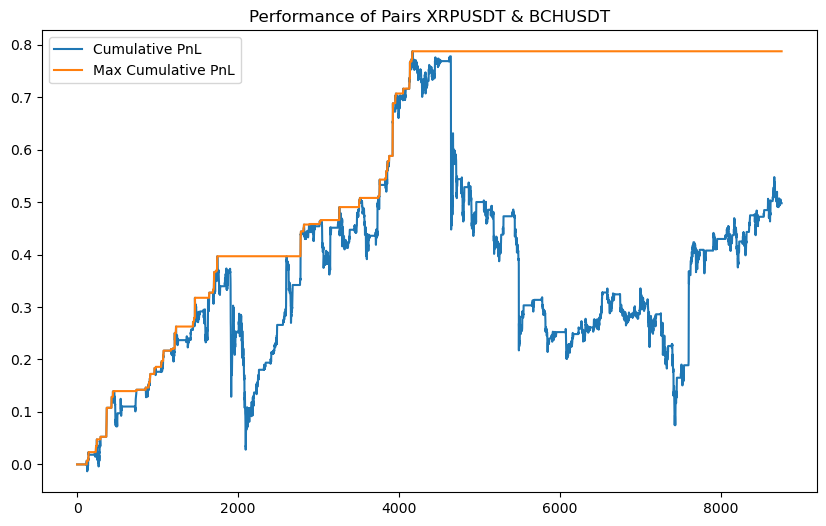

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2023        No      0.705125                   34.370759   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          49.777361        -71.267322 -310 days +03:00:00

In [120]:
pairs1_train_23_performance = \
   pnlPerformance(pairs1_train_23['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Train','2023','No')
pairs1_train_23_performance

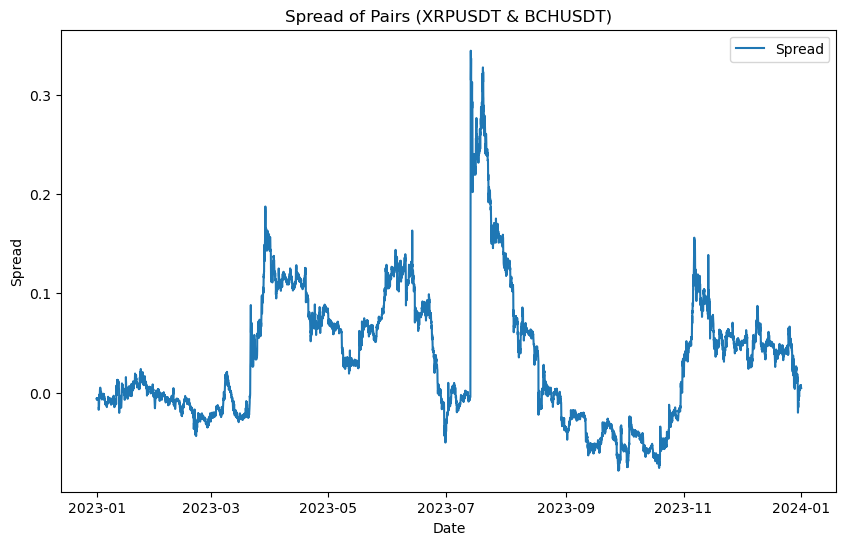

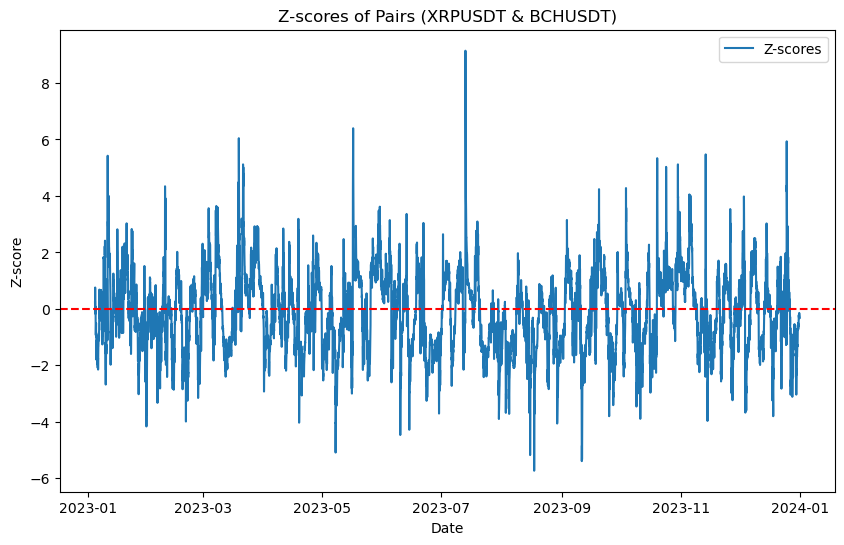

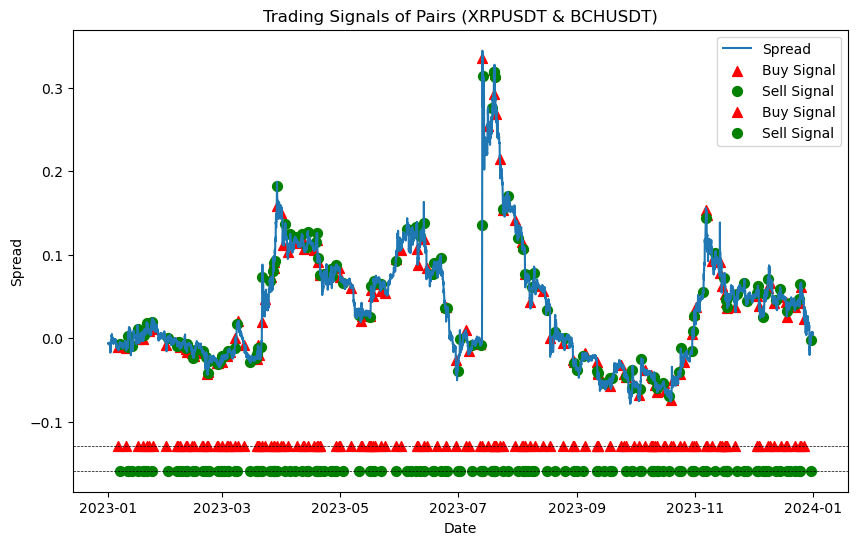

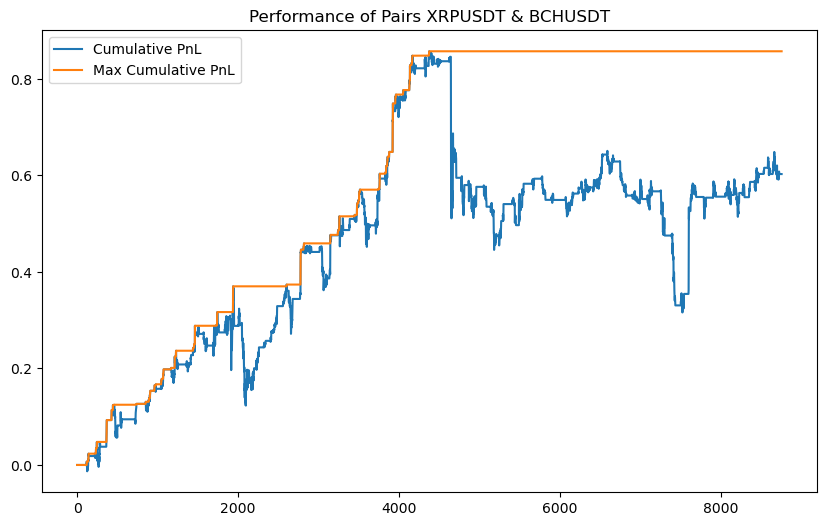

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2023  Strategy1      0.984536                   41.630078   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train           60.29065        -54.134008 -314 days +10:00:00

In [121]:
stoploss1_pairs1_train_23 = stop_loss_strategy1(pairs1_train_23, 'XRPUSDT','BCHUSDT',num_consecutive_losses=4)
pairs1_train_23_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_train_23['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2023','Strategy1')
pairs1_train_23_stoploss1_performance

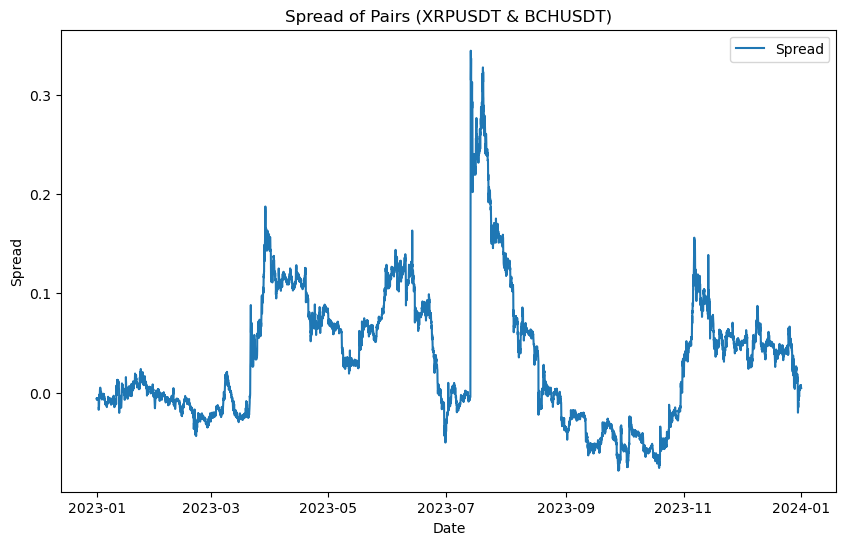

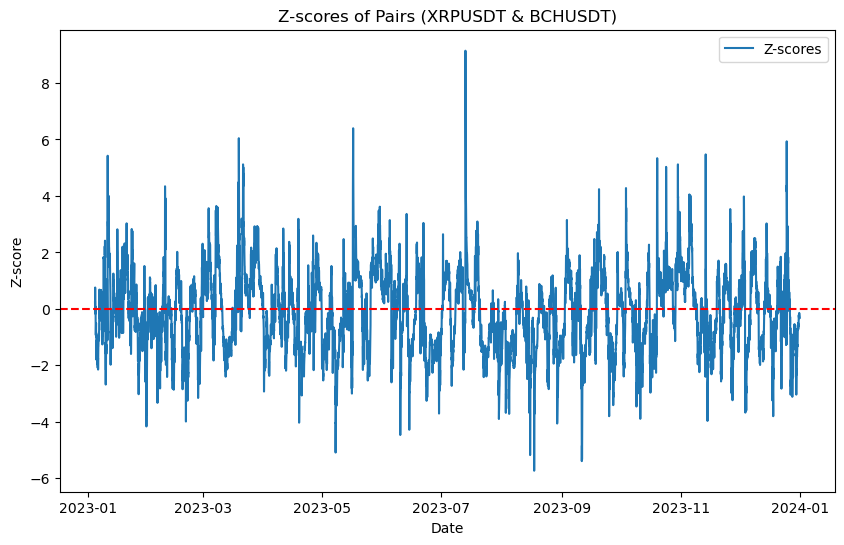

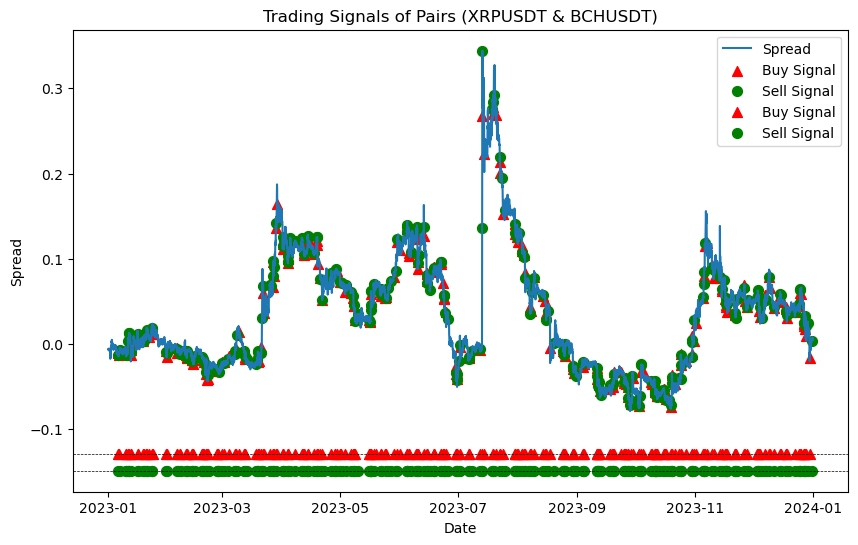

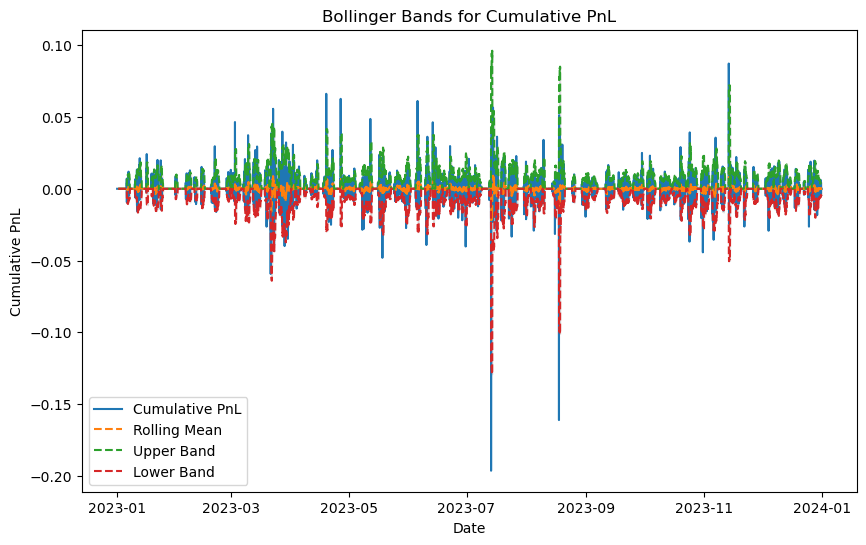

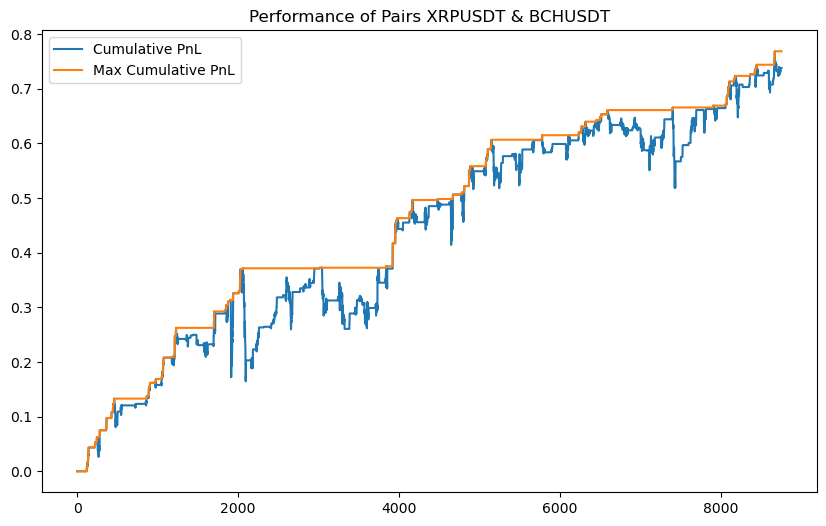

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2023  Strategy2      1.614497                   50.956881   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          73.798168        -20.683336  -88 days +15:00:00

In [122]:
stoploss2_pairs1_train_23 = \
   bollinger_band_stop_loss(pairs1_train_23, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
pairs1_train_23_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_train_23['hourlypnl'].dropna(),
                  'XRPUSDT & BCHUSDT','Train','2023','Strategy2')
pairs1_train_23_stoploss2_performance

In [123]:
compare_stop_loss_strategies(pairs1_train_23, stoploss2_pairs1_train_23, 'cumpnl', 'Train(2023)')

### 5. Test Data（2024）

In [124]:
pairs1_test = pairs_1.loc['2023-01-01':]
pairs1_test

Assets               XRPUSDT  BCHUSDT
Date                                 
2023-01-01 00:00:00   0.3385     96.4
2023-01-01 01:00:00   0.3387     96.5
2023-01-01 02:00:00   0.3380     96.6
2023-01-01 03:00:00   0.3381     96.5
2023-01-01 04:00:00   0.3361     96.2
...                      ...      ...
2024-05-30 20:00:00   0.5188    467.3
2024-05-30 21:00:00   0.5202    467.7
2024-05-30 22:00:00   0.5197    466.5
2024-05-30 23:00:00   0.5186    465.1
2024-05-31 00:00:00   0.5198    464.6

[12384 rows x 2 columns]

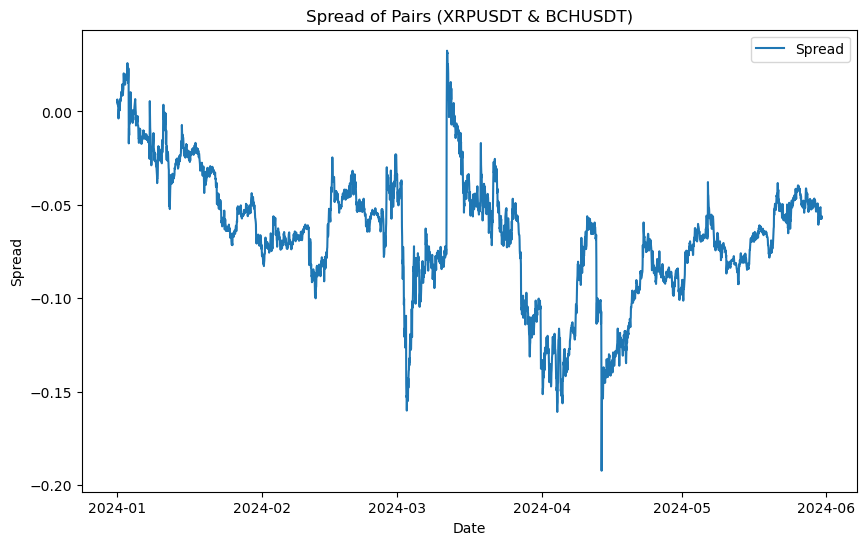

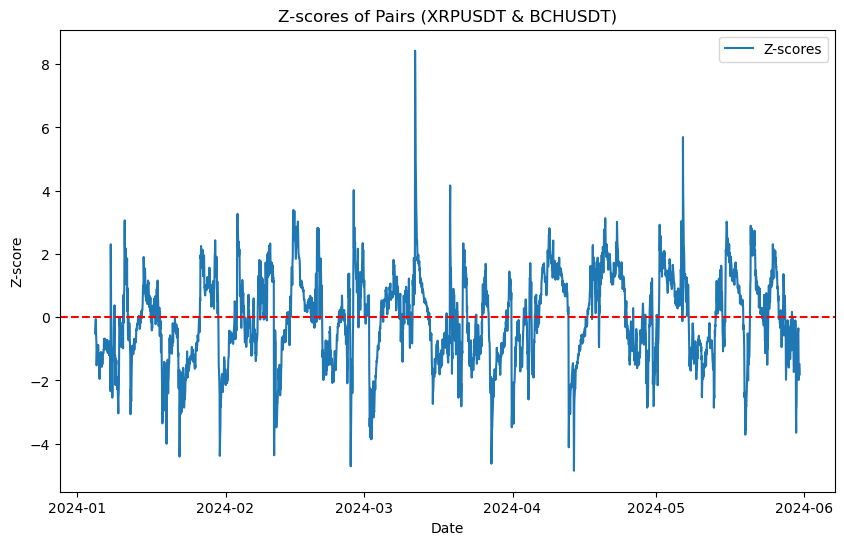

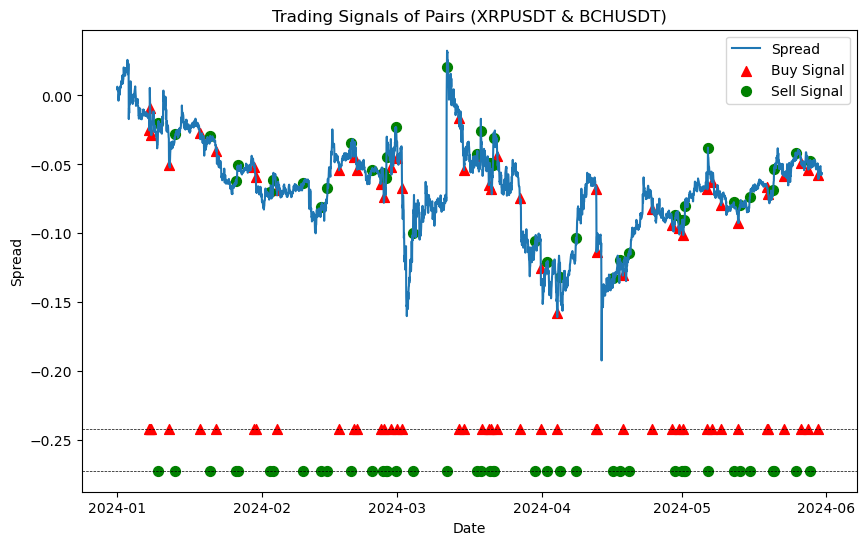

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2024-01-01 00:00:00   0.6162    259.9  0.001240   0.288918  0.004950   
2024-01-01 01:00:00   0.6185    260.6  0.001240   0.288959  0.006388   
2024-01-01 02:00:00   0.6154    260.0  0.001240   0.289001  0.004039   
2024-01-01 03:00:00   0.6130    258.3  0.001240   0.289044  0.003753   
2024-01-01 04:00:00   0.6116    257.2  0.001239   0.289087  0.003723   
...                      ...      ...       ...        ...       ...   
2024-05-30 20:00:00   0.5188    467.3  0.000057   0.549651 -0.057494   
2024-05-30 21:00:00   0.5202    467.7  0.000057   0.549687 -0.056093   
2024-05-30 22:00:00   0.5197    466.5  0.000057   0.549720 -0.056501   
2024-05-30 23:00:00   0.5186    465.1  0.000057   0.549754 -0.057498   
2024-05-31 00:00:00   0.5198    464.6  0.000057   0.549792 -0.056246   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2024-01-01 00:00:00        NaN         NaN       NaN     NaN         0   
2024-01-01 01:00:00        NaN         NaN       NaN     NaN         0   
2024-01-01 02:00:00        NaN         NaN       NaN     NaN         0   
2024-01-01 03:00:00        NaN         NaN       NaN     NaN         0   
2024-01-01 04:00:00        NaN         NaN       NaN     NaN         0   
...                        ...         ...       ...     ...       ...   
2024-05-30 20:00:00  -0.050137    0.003706 -1.985317     1.0         1   
2024-05-30 21:00:00  -0.050225    0.003752 -1.563783     NaN         1   
2024-05-30 22:00:00  -0.050307    0.003808 -1.626658     NaN         1   
2024-05-30 23:00:00  -0.050372    0.003881 -1.836314     NaN         1   
2024-05-31 00:00:00  -0.050395    0.003909 -1.496777     NaN         1   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2024-01-01 00:00:00       NaN       NaN         NaN         NaN        NaN   
2024-01-01 01:00:00  0.003726  0.002690         0.0   -0.000000   0.000000   
2024-01-01 02:00:00 -0.005025 -0.002305         0.0   -0.000000   0.000000   
2024-01-01 03:00:00 -0.003908 -0.006560         0.0   -0.000000   0.000000   
2024-01-01 04:00:00 -0.002286 -0.004268         0.0   -0.000000   0.000000   
...                       ...       ...         ...         ...        ...   
2024-05-30 20:00:00 -0.006149 -0.003845         1.0   -0.000057  -0.006149   
2024-05-30 21:00:00  0.002695  0.000856         1.0   -0.000057   0.002695   
2024-05-30 22:00:00 -0.000962 -0.002569         1.0   -0.000057  -0.000961   
2024-05-30 23:00:00 -0.002119 -0.003006         1.0   -0.000057  -0.002119   
2024-05-31 00:00:00  0.002311 -0.001076         1.0   -0.000057   0.002311   

Assets                 cumpnl  max_cumpnl  
Date                                       
2024-01-01 00:00:00       NaN         NaN  
2024-01-01 01:00:00  0.000000    0.000000  
2024-01-01 02:00:00  0.000000    0.000000  
2024-01-01 03:00:00  0.000000    0.000000  
2024-01-01 04:00:00  0.000000    0.000000  
...                       ...         ...  
2024-05-30 20:00:00  0.489155    0.529506  
2024-05-30 21:00:00  0.491850    0.529506  
2024-05-30 22:00:00  0.490889    0.529506  
2024-05-30 23:00:00  0.488770    0.529506  
2024-05-31 00:00:00  0.491081    0.529506  

[3625 rows x 17 columns]

In [125]:
pairs1_test = \
   pairs_trading_strategy(pairs1_test,'XRPUSDT','BCHUSDT',
                          z_signal_in, z_signal_out, min_spread, MA_window, OLS_window
                         )
pairs1_test

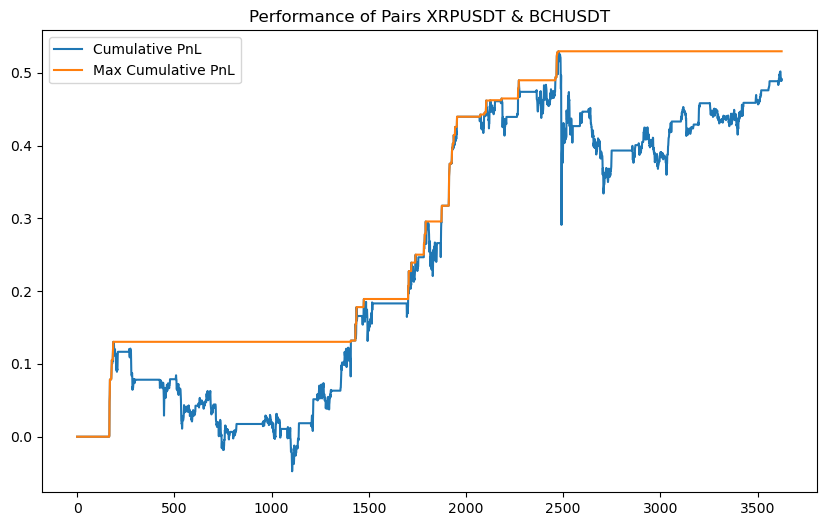

Year Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Test  2024        No      1.931665                   81.955289   

      Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Test          49.108129        -23.850902 -104 days +05:00:00

In [126]:
pairs1_test_performance = \
   pnlPerformance(pairs1_test['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Test','2024','No')
pairs1_test_performance

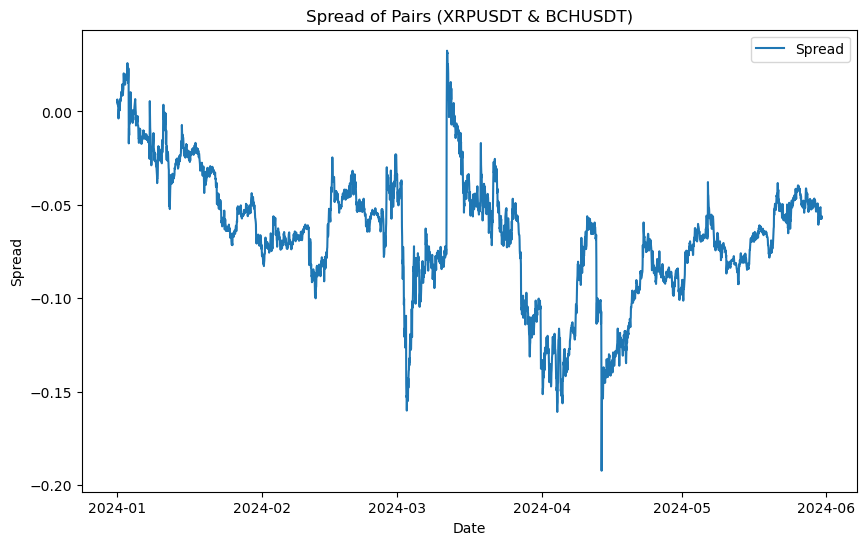

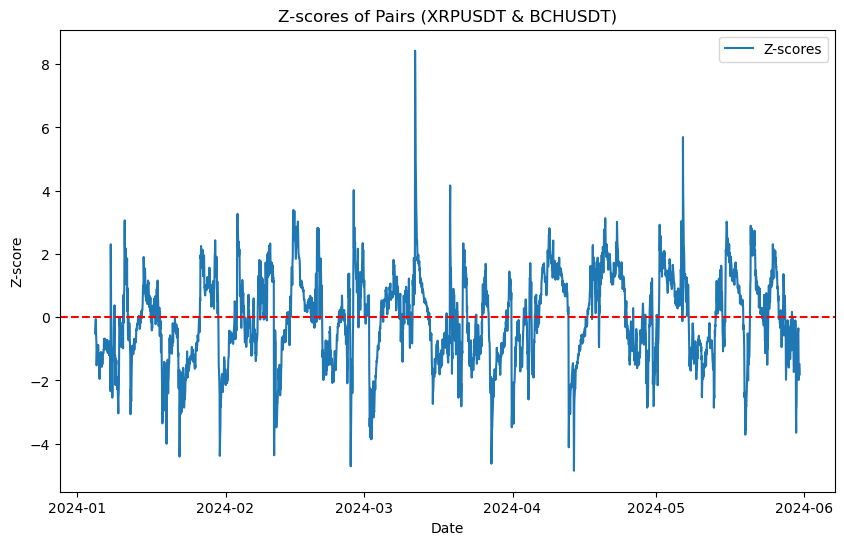

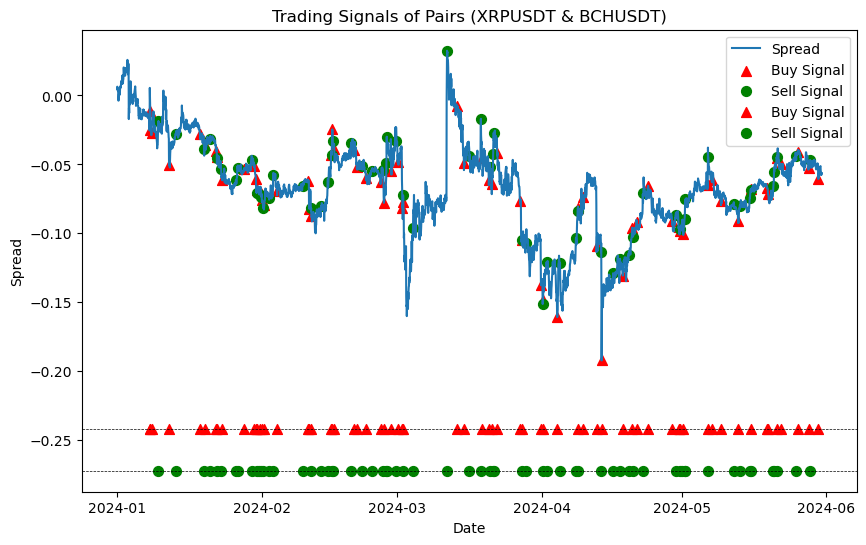

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2024-01-01 00:00:00   0.6162    259.9  0.001240   0.288918  0.004950   
2024-01-01 01:00:00   0.6185    260.6  0.001240   0.288959  0.006388   
2024-01-01 02:00:00   0.6154    260.0  0.001240   0.289001  0.004039   
2024-01-01 03:00:00   0.6130    258.3  0.001240   0.289044  0.003753   
2024-01-01 04:00:00   0.6116    257.2  0.001239   0.289087  0.003723   
...                      ...      ...       ...        ...       ...   
2024-05-30 20:00:00   0.5188    467.3  0.000057   0.549651 -0.057494   
2024-05-30 21:00:00   0.5202    467.7  0.000057   0.549687 -0.056093   
2024-05-30 22:00:00   0.5197    466.5  0.000057   0.549720 -0.056501   
2024-05-30 23:00:00   0.5186    465.1  0.000057   0.549754 -0.057498   
2024-05-31 00:00:00   0.5198    464.6  0.000057   0.549792 -0.056246   

Assets               Spread_MA  Spread_Std    zscors  signal  position  ...  \
Date                                                                    ...   
2024-01-01 00:00:00        NaN         NaN       NaN     NaN       NaN  ...   
2024-01-01 01:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2024-01-01 02:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2024-01-01 03:00:00        NaN         NaN       NaN     NaN       0.0  ...   
2024-01-01 04:00:00        NaN         NaN       NaN     NaN       0.0  ...   
...                        ...         ...       ...     ...       ...  ...   
2024-05-30 20:00:00  -0.050137    0.003706 -1.985317     1.0       1.0  ...   
2024-05-30 21:00:00  -0.050225    0.003752 -1.563783     NaN       1.0  ...   
2024-05-30 22:00:00  -0.050307    0.003808 -1.626658     NaN       1.0  ...   
2024-05-30 23:00:00  -0.050372    0.003881 -1.836314     NaN       1.0  ...   
2024-05-31 00:00:00  -0.050395    0.003909 -1.496777     NaN       1.0  ...   

Assets               return_X  position_Y  position_X  hourlypnl    cumpnl  \
Date                                                                         
2024-01-01 00:00:00       NaN         NaN         NaN        NaN       NaN   
2024-01-01 01:00:00  0.002690         0.0   -0.000000   0.000000  0.000000   
2024-01-01 02:00:00 -0.002305         0.0   -0.000000   0.000000  0.000000   
2024-01-01 03:00:00 -0.006560         0.0   -0.000000   0.000000  0.000000   
2024-01-01 04:00:00 -0.004268         0.0   -0.000000   0.000000  0.000000   
...                       ...         ...         ...        ...       ...   
2024-05-30 20:00:00 -0.003845         1.0   -0.000057  -0.006149  0.436832   
2024-05-30 21:00:00  0.000856         1.0   -0.000057   0.002695  0.439527   
2024-05-30 22:00:00 -0.002569         1.0   -0.000057  -0.000961  0.438566   
2024-05-30 23:00:00 -0.003006         1.0   -0.000057  -0.002119  0.436447   
2024-05-31 00:00:00 -0.001076         1.0   -0.000057   0.002311  0.438758   

Assets               max_cumpnl  return_XR  return_BC  XRposition  BCposition  
Date                                                                           
2024-01-01 00:00:00         NaN        NaN        NaN         NaN         NaN  
2024-01-01 01:00:00     0.00000   0.003726   0.002690         0.0   -0.000000  
2024-01-01 02:00:00     0.00000  -0.005025  -0.002305         0.0   -0.000000  
2024-01-01 03:00:00     0.00000  -0.003908  -0.006560         0.0   -0.000000  
2024-01-01 04:00:00     0.00000  -0.002286  -0.004268         0.0   -0.000000  
...                         ...        ...        ...         ...         ...  
2024-05-30 20:00:00     0.47115  -0.006149  -0.003845         1.0   -0.000057  
2024-05-30 21:00:00     0.47115   0.002695   0.000856         1.0   -0.000057  
2024-05-30 22:00:00     0.47115  -0.000962  -0.002569         1.0   -0.000057  
2024-05-30 23:00:00     0.47115  -0.002119  -0.003006         1.0   -0.000057  
2024-05-31 00:00:00     0.47115   0.002311  -0.001076       

In [127]:
stoploss1_pairs1_test = stop_loss_strategy1(pairs1_test, 'XRPUSDT', 'BCHUSDT',num_consecutive_losses=4)
stoploss1_pairs1_test

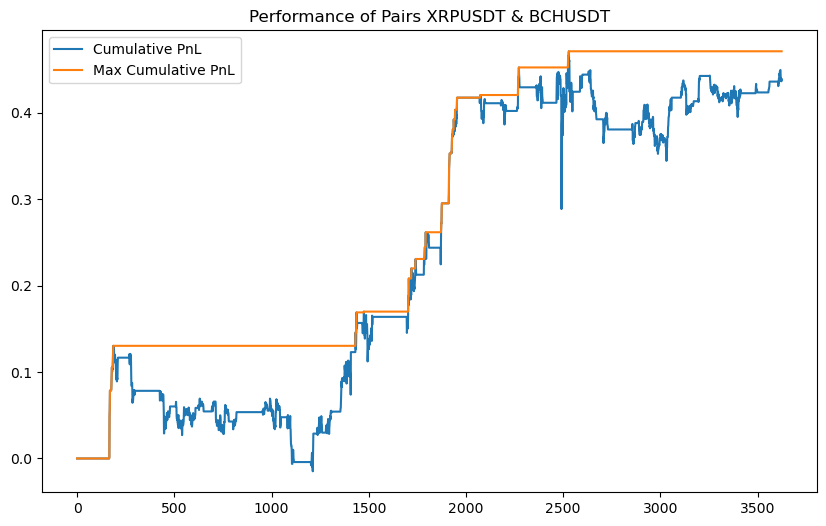

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Test  2024  Strategy1      1.928425                   73.223252   

      Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Test          43.875837        -16.383913 -104 days +05:00:00

In [128]:
pairs1_test_stoploss1_performance = \
   pnlPerformance(stoploss1_pairs1_test['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Test','2024','Strategy1')
pairs1_test_stoploss1_performance

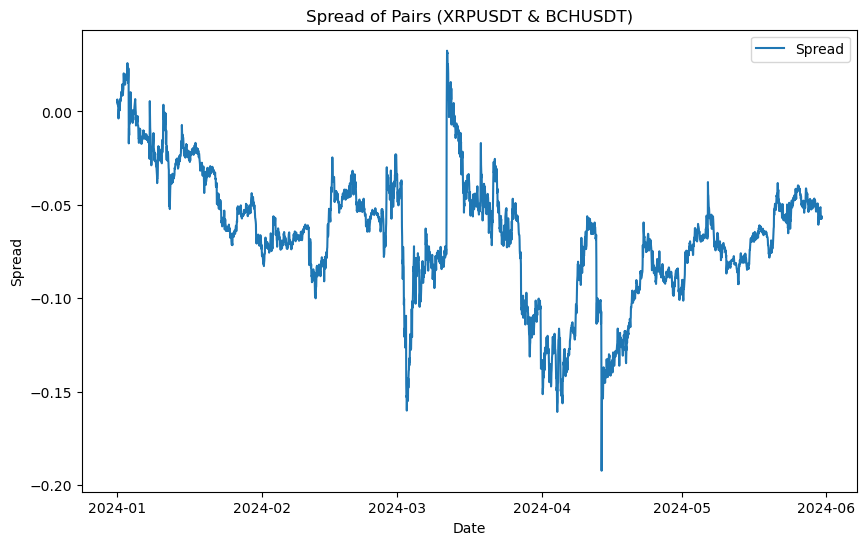

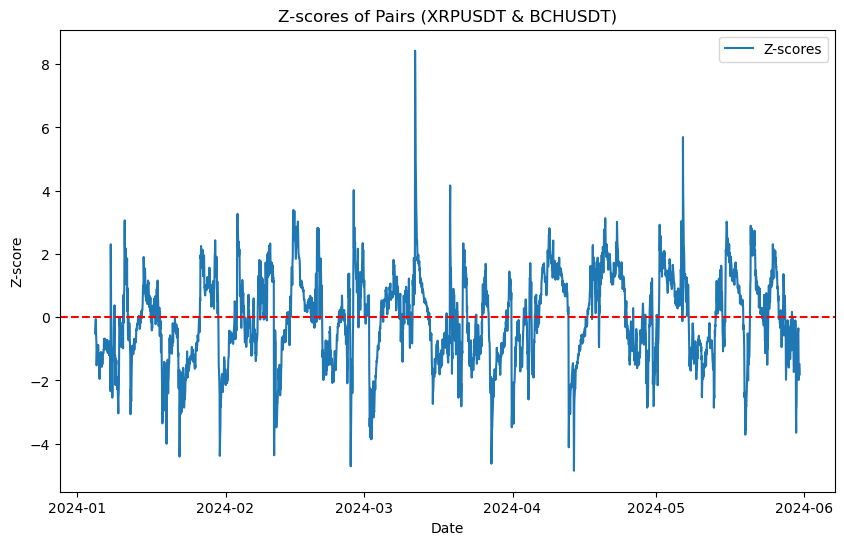

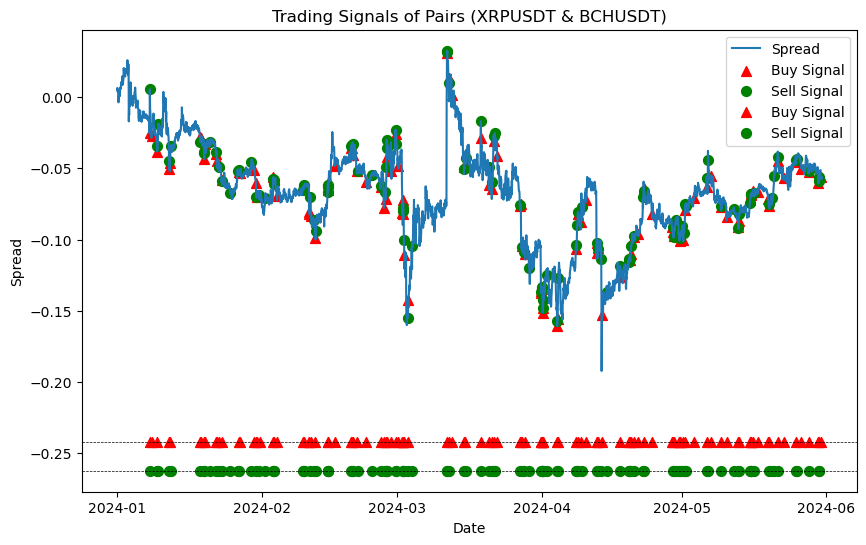

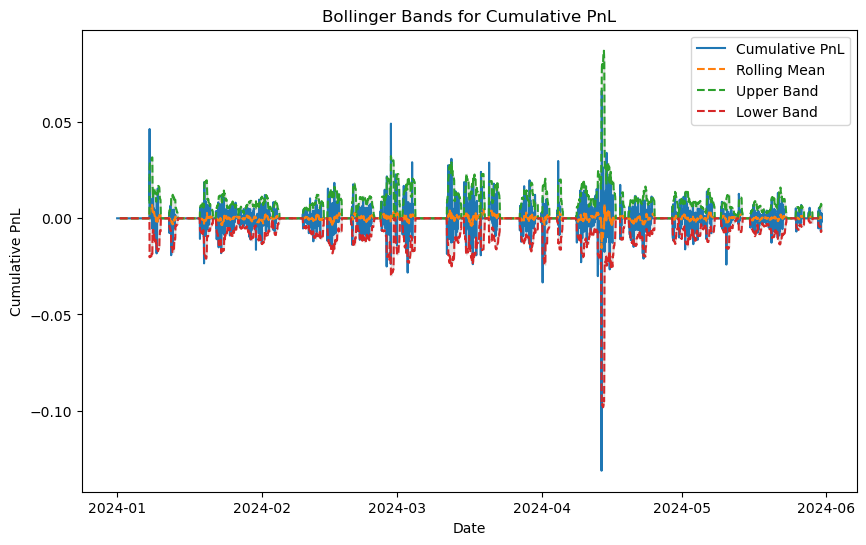

Assets               XRPUSDT  BCHUSDT      beta  intercept    spread  \
Date                                                                   
2024-01-01 00:00:00   0.6162    259.9  0.001240   0.288918  0.004950   
2024-01-01 01:00:00   0.6185    260.6  0.001240   0.288959  0.006388   
2024-01-01 02:00:00   0.6154    260.0  0.001240   0.289001  0.004039   
2024-01-01 03:00:00   0.6130    258.3  0.001240   0.289044  0.003753   
2024-01-01 04:00:00   0.6116    257.2  0.001239   0.289087  0.003723   
...                      ...      ...       ...        ...       ...   
2024-05-30 20:00:00   0.5188    467.3  0.000057   0.549651 -0.057494   
2024-05-30 21:00:00   0.5202    467.7  0.000057   0.549687 -0.056093   
2024-05-30 22:00:00   0.5197    466.5  0.000057   0.549720 -0.056501   
2024-05-30 23:00:00   0.5186    465.1  0.000057   0.549754 -0.057498   
2024-05-31 00:00:00   0.5198    464.6  0.000057   0.549792 -0.056246   

Assets               Spread_MA  Spread_Std    zscors  signal  position  \
Date                                                                     
2024-01-01 00:00:00        NaN         NaN       NaN     NaN       NaN   
2024-01-01 01:00:00        NaN         NaN       NaN     NaN       0.0   
2024-01-01 02:00:00        NaN         NaN       NaN     NaN       0.0   
2024-01-01 03:00:00        NaN         NaN       NaN     NaN       0.0   
2024-01-01 04:00:00        NaN         NaN       NaN     NaN       0.0   
...                        ...         ...       ...     ...       ...   
2024-05-30 20:00:00  -0.050137    0.003706 -1.985317     1.0       0.0   
2024-05-30 21:00:00  -0.050225    0.003752 -1.563783     NaN       1.0   
2024-05-30 22:00:00  -0.050307    0.003808 -1.626658     NaN       1.0   
2024-05-30 23:00:00  -0.050372    0.003881 -1.836314     NaN       1.0   
2024-05-31 00:00:00  -0.050395    0.003909 -1.496777     NaN       1.0   

Assets               return_Y  return_X  position_Y  position_X  hourlypnl  \
Date                                                                         
2024-01-01 00:00:00       NaN       NaN         NaN         NaN        NaN   
2024-01-01 01:00:00  0.003726  0.002690         0.0   -0.000000   0.000000   
2024-01-01 02:00:00 -0.005025 -0.002305         0.0   -0.000000   0.000000   
2024-01-01 03:00:00 -0.003908 -0.006560         0.0   -0.000000   0.000000   
2024-01-01 04:00:00 -0.002286 -0.004268         0.0   -0.000000   0.000000   
...                       ...       ...         ...         ...        ...   
2024-05-30 20:00:00 -0.006149 -0.003845         0.0   -0.000000   0.000000   
2024-05-30 21:00:00  0.002695  0.000856         1.0   -0.000057   0.002695   
2024-05-30 22:00:00 -0.000962 -0.002569         1.0   -0.000057  -0.000961   
2024-05-30 23:00:00 -0.002119 -0.003006         1.0   -0.000057  -0.002119   
2024-05-31 00:00:00  0.002311 -0.001076         1.0   -0.000057   0.002311   

Assets                 cumpnl  max_cumpnl  stop_loss_signal  
Date                                                         
2024-01-01 00:00:00       NaN         NaN               NaN  
2024-01-01 01:00:00  0.000000    0.000000               NaN  
2024-01-01 02:00:00  0.000000    0.000000               NaN  
2024-01-01 03:00:00  0.000000    0.000000               NaN  
2024-01-01 04:00:00  0.000000    0.000000               NaN  
...                       ...         ...               ...  
2024-05-30 20:00:00  0.377253    0.377253               NaN  
2024-05-30 21:00:00  0.379948    0.379948               NaN  
2024-05-30 22:00:00  0.378986    0.379948               NaN  
2024-05-30 23:00:00  0.376868    0.379948               NaN  
2024-05-31 00:00:00  0.379179    0.379948               NaN  

[3625 rows x 18 columns]

In [129]:
stoploss2_pairs1_test = \
   bollinger_band_stop_loss(pairs1_test, 'hourlypnl','XRPUSDT','BCHUSDT',boll_window,std_multiplier)
stoploss2_pairs1_test

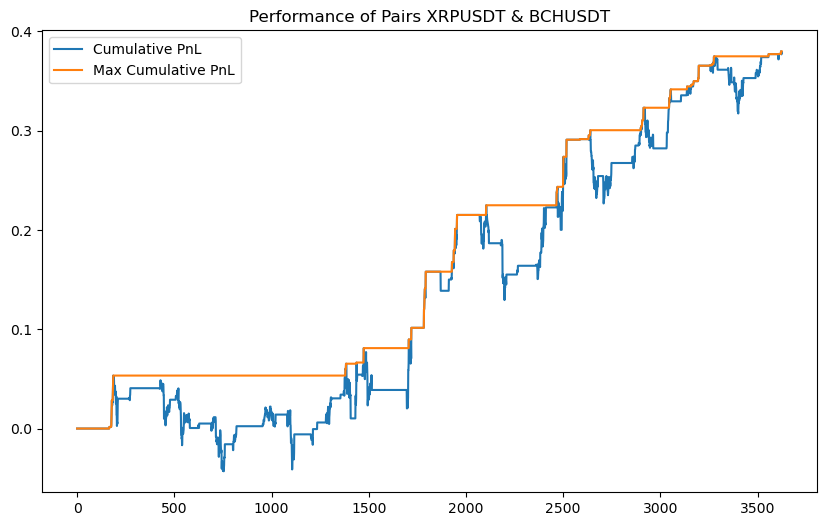

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Test  2024  Strategy2       2.34119                   63.280218   

      Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Test          37.917909         -9.638509  -32 days +14:00:00

In [130]:
pairs1_test_stoploss2_performance = \
   pnlPerformance(stoploss2_pairs1_test['hourlypnl'].dropna(),'XRPUSDT & BCHUSDT','Test','2024','Strategy2')
pairs1_test_stoploss2_performance

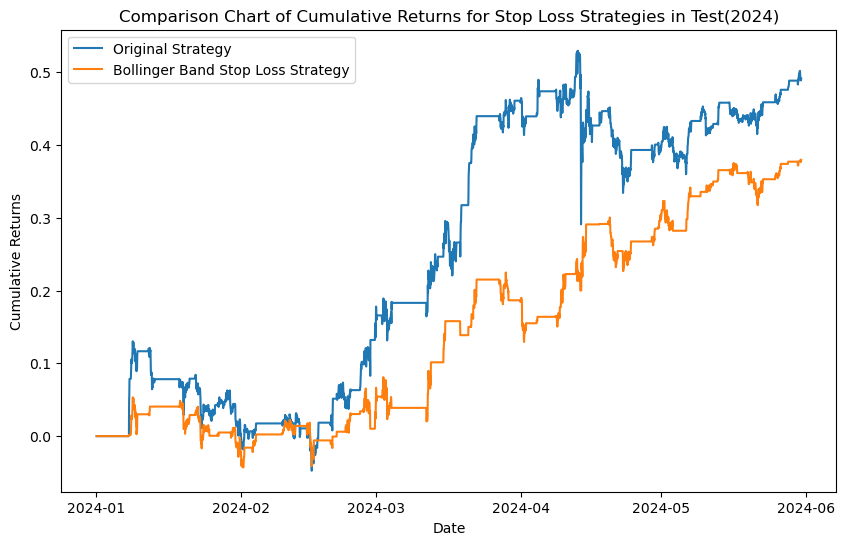

In [131]:
compare_stop_loss_strategies(pairs1_test, stoploss2_pairs1_test, 'cumpnl', 'Test(2024)')

### 6. conclusion

In [132]:
conclu_performance = pd.concat([pairs1_train_2123_performance,
                                pairs1_train_2123_stoploss1_performance,
                                pairs1_train_2123_stoploss2_performance,
                                pairs1_train_2223_performance,
                                pairs1_train_2223_stoploss1_performance,
                                pairs1_train_2223_stoploss2_performance,
                                pairs1_train_21_performance,
                                pairs1_train_21_stoploss1_performance,
                                pairs1_train_21_stoploss2_performance, 
                                pairs1_train_22_performance,
                                pairs1_train_22_stoploss1_performance,
                                pairs1_train_22_stoploss2_performance,
                                pairs1_train_23_performance,
                                pairs1_train_23_stoploss1_performance,
                                pairs1_train_23_stoploss2_performance,
                                pairs1_test_performance,
                                pairs1_test_stoploss1_performance,
                                pairs1_test_stoploss2_performance])
conclu_performance

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021-2023          No     -0.072397                   -5.352018   
Train  2021-2023  Strategy 1     -0.280951                  -17.763218   
Train  2021-2023  Strategy 2      0.684103                   37.506237   
Train  2022-2023          No      0.804799                   43.234076   
Train  2022-2023  Strategy 1      0.682684                   32.008314   
Train  2022-2023  Strategy 2      1.352549                   52.135847   
Train       2021          No     -1.017756                 -104.894237   
Train       2021   Strategy1     -1.373676                 -119.694748   
Train       2021   Strategy2      0.096735                    7.523169   
Train       2022          No      0.756918                   44.046209   
Train       2022   Strategy1      0.280700                   14.310007   
Train       2022   Strategy2      1.100226                   48.847690   
Train       2023          No      0.705125                   34.370759   
Train       2023   Strategy1      0.984536                   41.630078   
Train       2023   Strategy2      1.614497                   50.956881   
Test        2024          No      1.931665                   81.955289   
Test        2024   Strategy1      1.928425                   73.223252   
Test        2024   Strategy2      2.341190                   63.280218   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         -23.248711       -207.200261 -138 days +07:00:00  
Train         -77.161916       -219.061716 -408 days +20:00:00  
Train         162.923920        -99.834676  -51 days +12:00:00  
Train         125.141491        -71.267322 -675 days +16:00:00  
Train          92.648404        -54.134008 -679 days +23:00:00  
Train         150.907761        -43.863347  -38 days +08:00:00  
Train        -151.808740       -207.200261 -138 days +07:00:00  
Train        -173.228858       -216.807407 -173 days +05:00:00  
Train          10.887946        -99.834676  -51 days +12:00:00  
Train          63.702412        -36.886213 -265 days +07:00:00  
Train          20.696036        -51.304780  -42 days +15:00:00  
Train          70.646618        -43.863347  -38 days +08:00:00  
Train          49.777361        -71.267322 -310 days +03:00:00  
Train          60.290650        -54.134008 -314 days +10:00:00  
Train          73.798168        -20.683336  -88 days +15:00:00  
Test           49.108129        -23.850902 -104 days +05:00:00  
Test           43.875837        -16.383913 -104 days +05:00:00  
Test           37.917909         -9.638509  -32 days +14:00:00

In [133]:
conclu1 = conclu_performance[0:6]
conclu1

Year   Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021-2023          No     -0.072397                   -5.352018   
Train  2021-2023  Strategy 1     -0.280951                  -17.763218   
Train  2021-2023  Strategy 2      0.684103                   37.506237   
Train  2022-2023          No      0.804799                   43.234076   
Train  2022-2023  Strategy 1      0.682684                   32.008314   
Train  2022-2023  Strategy 2      1.352549                   52.135847   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train         -23.248711       -207.200261 -138 days +07:00:00  
Train         -77.161916       -219.061716 -408 days +20:00:00  
Train         162.923920        -99.834676  -51 days +12:00:00  
Train         125.141491        -71.267322 -675 days +16:00:00  
Train          92.648404        -54.134008 -679 days +23:00:00  
Train         150.907761        -43.863347  -38 days +08:00:00

In [134]:
conclu2 = conclu_performance[6:9]
conclu2

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2021         No     -1.017756                 -104.894237   
Train  2021  Strategy1     -1.373676                 -119.694748   
Train  2021  Strategy2      0.096735                    7.523169   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train        -151.808740       -207.200261 -138 days +07:00:00  
Train        -173.228858       -216.807407 -173 days +05:00:00  
Train          10.887946        -99.834676  -51 days +12:00:00

In [135]:
conclu3 = conclu_performance[9:12]
conclu3

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2022         No      0.756918                   44.046209   
Train  2022  Strategy1      0.280700                   14.310007   
Train  2022  Strategy2      1.100226                   48.847690   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          63.702412        -36.886213 -265 days +07:00:00  
Train          20.696036        -51.304780  -42 days +15:00:00  
Train          70.646618        -43.863347  -38 days +08:00:00

In [136]:
conclu4 = conclu_performance[12:15]
conclu4

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Train  2023         No      0.705125                   34.370759   
Train  2023  Strategy1      0.984536                   41.630078   
Train  2023  Strategy2      1.614497                   50.956881   

       Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Train          49.777361        -71.267322 -310 days +03:00:00  
Train          60.290650        -54.134008 -314 days +10:00:00  
Train          73.798168        -20.683336  -88 days +15:00:00

In [137]:
conclu5 = conclu_performance[15:18]
conclu5

Year  Stop-Loss  Sharpe Ratio  Average Annual Returns (%)  \
Test  2024         No      1.931665                   81.955289   
Test  2024  Strategy1      1.928425                   73.223252   
Test  2024  Strategy2      2.341190                   63.280218   

      Total Returns (%)  Max Drawdown (%) Max Drawdown Period  
Test          49.108129        -23.850902 -104 days +05:00:00  
Test          43.875837        -16.383913 -104 days +05:00:00  
Test          37.917909         -9.638509  -32 days +14:00:00